In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
caption_data = pd.read_csv("../archive/captions.txt")
caption_data.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [4]:
caption_data.isna().sum()

image      0
caption    0
dtype: int64

In [34]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [35]:
model = VGG16(weights='imagenet')

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 85s 0us/step


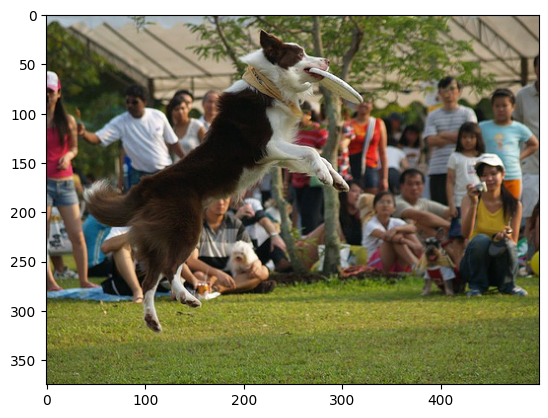

In [38]:
image_dir = "../archive/Images/"
first_image = caption_data.loc[500]["image"]

img = image.load_img(f"{image_dir}/{first_image}")
plt.imshow(img)

In [80]:
def split_image_func(image, patch_size):
    width, height = image.size
    patches = []
    for i in range(0, width, patch_size):
        for j in range(0, height, patch_size):
            box = (i, j, i + patch_size, j + patch_size)
            patch = image.crop(box)
            patches.append(patch)
    return patches

def preprocess_image(img_path, split_image=False, patch_size=50):
    img = image.load_img(img_path, target_size=(224, 224)) #target size of (224, 224)
    if split_image:
        patches = split_image_func(img, patch_size=patch_size)
        image_array = []
        for patch in patches:
            img_array = patch.resize((224, 224))
            img_array = image.img_to_array(img_array)
            img_array = np.expand_dims(img_array, axis=0) # Add an extra dimension for batch size
            img_array = preprocess_input(img_array)
            image_array.append(img_array)
    else:
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Add an extra dimension for batch size
        image_array = preprocess_input(img_array)
    return img, image_array

def get_prediction(image_model, image_path, split_image=False, patch_size=50):
    img, img_array = preprocess_image(image_path, split_image=split_image, patch_size=patch_size)
    prediction = []
    if type(img_array) == list:
        for arr in img_array:
            pred = image_model.predict(arr)
            pred = decode_predictions(pred, top=2)
            prediction.append(pred)
    else:
        prediction = image_model.predict(img_array)
        prediction = decode_predictions(prediction, top=5)
    return img, prediction


In [89]:
img, prediction = get_prediction(model, f"{image_dir}/{first_image}", split_image=True, patch_size=200)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


[[[('n03733131', 'maypole', 0.25090227),
   ('n02108000', 'EntleBucher', 0.1099568)]],
 [[('n03445777', 'golf_ball', 0.027673507),
   ('n04409515', 'tennis_ball', 0.017843865)]],
 [[('n03355925', 'flagpole', 0.053918716),
   ('n06874185', 'traffic_light', 0.045183964)]],
 [[('n03729826', 'matchstick', 0.028782275),
   ('n01930112', 'nematode', 0.02745301)]]]

In [92]:
img, prediction = get_prediction(model, f"{image_dir}/{first_image}", split_image=False)
prediction[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


[('n03733131', 'maypole', 0.45241234),
 ('n02091831', 'Saluki', 0.08325037),
 ('n02108000', 'EntleBucher', 0.05118372),
 ('n02111129', 'Leonberg', 0.041814115),
 ('n02105855', 'Shetland_sheepdog', 0.036102958)]

In [94]:
h = caption_data.head()
h.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [93]:
for pred in prediction[0]:
    print(pred[1])

maypole
Saluki
EntleBucher
Leonberg
Shetland_sheepdog


In [103]:
seen_image = {}
image_net_pred = []
for i,row in caption_data.iterrows():
    if row["image"] not in seen_image:
        _, prediction = get_prediction(model, f"{image_dir}/{row["image"]}", split_image=False)
        prediction = [pred[1] for pred in prediction[0]]
        image_net_pred.append(prediction)
        seen_image[row["image"]] = prediction
    else:
        image_net_pred.append(seen_image.get(row["image"]))
        
image_net_pred

ImageNet prediction progress: 0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 1it [00:00,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 6it [00:00, 22.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 11it [00:00, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 16it [00:00, 32.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 21it [00:00, 33.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 26it [00:00, 35.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 31it [00:00, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 36it [00:01, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 41it [00:01, 35.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 46it [00:01, 35.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 51it [00:01, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 56it [00:01, 35.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 61it [00:01, 36.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 66it [00:01, 36.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 71it [00:02, 36.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 76it [00:02, 35.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 81it [00:02, 35.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 86it [00:02, 35.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 91it [00:02, 35.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 96it [00:02, 36.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 101it [00:02, 36.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 106it [00:03, 35.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 111it [00:03, 36.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 116it [00:03, 36.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 121it [00:03, 36.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 126it [00:03, 37.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 131it [00:03, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 136it [00:03, 37.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 141it [00:03, 37.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 146it [00:04, 37.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 151it [00:04, 37.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 156it [00:04, 36.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 161it [00:04, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 166it [00:04, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 171it [00:04, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 176it [00:04, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 181it [00:05, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 186it [00:05, 34.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 191it [00:05, 35.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 196it [00:05, 36.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 201it [00:05, 36.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 206it [00:05, 36.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 211it [00:05, 36.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 216it [00:06, 36.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 221it [00:06, 36.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 226it [00:06, 35.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 231it [00:06, 35.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 236it [00:06, 35.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 241it [00:06, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 246it [00:06, 36.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 251it [00:07, 36.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 256it [00:07, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 261it [00:07, 35.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 266it [00:07, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 271it [00:07, 35.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 276it [00:07, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 281it [00:07, 36.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 286it [00:08, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 291it [00:08, 36.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 296it [00:08, 36.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 301it [00:08, 36.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 306it [00:08, 36.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 311it [00:08, 36.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 316it [00:08, 37.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 321it [00:08, 37.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 326it [00:09, 37.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 331it [00:09, 37.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 336it [00:09, 37.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 341it [00:09, 37.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 346it [00:09, 37.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 351it [00:09, 37.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 356it [00:09, 37.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 361it [00:10, 35.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 366it [00:10, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 371it [00:10, 35.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 376it [00:10, 36.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 381it [00:10, 36.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 386it [00:10, 37.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 391it [00:10, 37.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 396it [00:10, 37.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 401it [00:11, 37.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 406it [00:11, 37.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 411it [00:11, 37.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 416it [00:11, 37.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 421it [00:11, 37.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 426it [00:11, 36.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 431it [00:11, 36.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 436it [00:12, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 441it [00:12, 37.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 446it [00:12, 37.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 451it [00:12, 37.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 456it [00:12, 37.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 461it [00:12, 36.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 466it [00:12, 36.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 471it [00:13, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 476it [00:13, 36.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 481it [00:13, 36.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 486it [00:13, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 491it [00:13, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 496it [00:13, 35.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 501it [00:13, 35.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 506it [00:14, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 511it [00:14, 36.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 516it [00:14, 36.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 521it [00:14, 37.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 526it [00:14, 37.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 531it [00:14, 37.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 536it [00:14, 37.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 541it [00:14, 37.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 546it [00:15, 37.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 551it [00:15, 37.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 556it [00:15, 35.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 561it [00:15, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 566it [00:15, 36.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 571it [00:15, 37.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 576it [00:15, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 581it [00:16, 34.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 586it [00:16, 35.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 591it [00:16, 36.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 596it [00:16, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 601it [00:16, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 606it [00:16, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 611it [00:16, 36.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 616it [00:17, 36.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 621it [00:17, 37.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 626it [00:17, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 631it [00:17, 36.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 636it [00:17, 36.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 641it [00:17, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 646it [00:17, 36.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 651it [00:17, 36.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 656it [00:18, 36.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 661it [00:18, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 666it [00:18, 36.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 671it [00:18, 35.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 676it [00:18, 34.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 681it [00:18, 34.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 686it [00:18, 35.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 691it [00:19, 36.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 696it [00:19, 34.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 701it [00:19, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 706it [00:19, 35.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 711it [00:19, 35.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 716it [00:19, 35.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 721it [00:19, 36.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 726it [00:20, 36.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 731it [00:20, 37.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 736it [00:20, 35.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 741it [00:20, 36.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 746it [00:20, 36.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 751it [00:20, 36.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 756it [00:20, 37.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 761it [00:21, 37.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 766it [00:21, 37.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 771it [00:21, 35.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 776it [00:21, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 781it [00:21, 36.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 786it [00:21, 36.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 791it [00:21, 36.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 796it [00:22, 36.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 801it [00:22, 34.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 806it [00:22, 34.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 811it [00:22, 34.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 816it [00:22, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 821it [00:22, 35.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 826it [00:22, 36.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 831it [00:22, 36.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 836it [00:23, 35.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 841it [00:23, 35.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 846it [00:23, 34.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 851it [00:23, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 856it [00:23, 33.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 861it [00:23, 34.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 866it [00:24, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 871it [00:24, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 876it [00:24, 35.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 881it [00:24, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 886it [00:24, 36.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 891it [00:24, 36.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 896it [00:24, 36.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 901it [00:24, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 906it [00:25, 36.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 911it [00:25, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 916it [00:25, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 921it [00:25, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 926it [00:25, 35.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 931it [00:25, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 936it [00:25, 36.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 941it [00:26, 36.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 946it [00:26, 36.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 951it [00:26, 37.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 956it [00:26, 36.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 961it [00:26, 36.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 966it [00:26, 36.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 971it [00:26, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 976it [00:27, 35.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 981it [00:27, 35.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 986it [00:27, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 991it [00:27, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 996it [00:27, 36.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1001it [00:27, 36.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1006it [00:27, 37.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1011it [00:27, 36.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 1016it [00:28, 36.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 1021it [00:28, 36.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1026it [00:28, 36.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1031it [00:28, 36.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1036it [00:28, 36.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 1041it [00:28, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 1046it [00:29, 33.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1051it [00:29, 34.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 1056it [00:29, 34.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 1061it [00:29, 35.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 1066it [00:29, 34.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 1071it [00:29, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 1076it [00:29, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1081it [00:30, 34.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 1086it [00:30, 34.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1091it [00:30, 35.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 1096it [00:30, 33.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1101it [00:30, 34.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 1106it [00:30, 35.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1111it [00:30, 35.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1116it [00:30, 36.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 1121it [00:31, 20.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1126it [00:31, 23.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1131it [00:31, 26.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1136it [00:31, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1141it [00:32, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 1146it [00:32, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 1151it [00:32, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 1156it [00:32, 31.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 1161it [00:32, 32.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 1166it [00:32, 33.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 1171it [00:32, 34.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 1176it [00:33, 34.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 1181it [00:33, 34.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 1186it [00:33, 35.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 1191it [00:33, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1196it [00:33, 35.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 1201it [00:33, 34.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 1206it [00:33, 29.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1211it [00:34, 31.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 1216it [00:34, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 1221it [00:34, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 1226it [00:34, 31.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 1231it [00:34, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 1236it [00:34, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 1241it [00:35, 31.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1246it [00:35, 32.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1251it [00:35, 34.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 1256it [00:35, 35.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1261it [00:35, 36.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 1266it [00:35, 34.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1271it [00:35, 35.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


ImageNet prediction progress: 1276it [00:36, 17.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 1281it [00:36, 20.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1286it [00:36, 23.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1291it [00:36, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 1296it [00:37, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1301it [00:37, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 1306it [00:37, 31.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


ImageNet prediction progress: 1311it [00:37, 33.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1316it [00:37, 34.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1321it [00:37, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 1326it [00:37, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 1331it [00:38, 36.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1336it [00:38, 37.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1341it [00:38, 37.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1346it [00:38, 37.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1351it [00:38, 38.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 1356it [00:38, 38.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1361it [00:38, 38.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1366it [00:38, 38.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1371it [00:39, 38.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1376it [00:39, 39.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1381it [00:39, 38.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


ImageNet prediction progress: 1386it [00:39, 39.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1391it [00:39, 39.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 1396it [00:39, 38.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 1401it [00:39, 37.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1406it [00:39, 37.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1411it [00:40, 38.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1416it [00:40, 38.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1421it [00:40, 38.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 1426it [00:40, 38.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1431it [00:40, 38.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1436it [00:40, 38.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1441it [00:40, 38.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1446it [00:40, 39.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1451it [00:41, 39.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 1456it [00:41, 37.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1461it [00:41, 37.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1466it [00:41, 37.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1471it [00:41, 38.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 1476it [00:41, 37.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 1481it [00:41, 36.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 1486it [00:42, 34.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 1491it [00:42, 29.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 1496it [00:42, 29.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 1501it [00:42, 30.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1506it [00:42, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1511it [00:42, 33.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 1516it [00:43, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 1521it [00:43, 33.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1526it [00:43, 34.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 1531it [00:43, 35.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1536it [00:43, 36.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1541it [00:43, 37.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1546it [00:43, 37.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1551it [00:43, 38.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1556it [00:44, 38.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1561it [00:44, 38.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1566it [00:44, 38.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 1571it [00:44, 32.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1576it [00:44, 33.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1581it [00:44, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1586it [00:44, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1591it [00:45, 36.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 1596it [00:45, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 1601it [00:45, 32.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1606it [00:45, 34.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1611it [00:45, 35.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 1616it [00:45, 35.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1621it [00:45, 36.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1626it [00:46, 37.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1631it [00:46, 37.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1636it [00:46, 37.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1641it [00:46, 38.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 1646it [00:46, 38.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1651it [00:46, 38.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1656it [00:46, 38.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1661it [00:47, 38.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1666it [00:47, 38.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1671it [00:47, 39.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 1676it [00:47, 37.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1681it [00:47, 38.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1686it [00:47, 38.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1691it [00:47, 38.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 1696it [00:47, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 1701it [00:48, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 1706it [00:48, 35.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1711it [00:48, 36.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1716it [00:48, 37.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1721it [00:48, 38.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1726it [00:48, 38.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1731it [00:48, 38.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1736it [00:48, 38.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 1741it [00:49, 37.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1746it [00:49, 38.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


ImageNet prediction progress: 1751it [00:49, 38.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


ImageNet prediction progress: 1756it [00:49, 39.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 1761it [00:49, 37.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1766it [00:49, 37.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1771it [00:49, 37.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1776it [00:50, 38.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


ImageNet prediction progress: 1781it [00:50, 38.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


ImageNet prediction progress: 1786it [00:50, 39.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1791it [00:50, 39.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 1796it [00:50, 39.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 1801it [00:50, 38.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1806it [00:50, 39.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1811it [00:50, 39.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1816it [00:51, 38.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1821it [00:51, 39.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 1826it [00:51, 36.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


ImageNet prediction progress: 1831it [00:51, 37.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


ImageNet prediction progress: 1836it [00:51, 38.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1841it [00:51, 37.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 1846it [00:51, 36.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 1851it [00:52, 37.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 1856it [00:52, 37.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 1861it [00:52, 36.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 1866it [00:52, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1871it [00:52, 36.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1876it [00:52, 37.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1881it [00:52, 37.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1886it [00:52, 37.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


ImageNet prediction progress: 1891it [00:53, 38.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 1896it [00:53, 35.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


ImageNet prediction progress: 1901it [00:53, 24.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 1906it [00:53, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 1911it [00:53, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 1916it [00:54, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1921it [00:54, 30.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 1926it [00:54, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 1931it [00:54, 32.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 1936it [00:54, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 1941it [00:54, 32.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 1946it [00:54, 33.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 1951it [00:55, 34.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 1956it [00:55, 34.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 1961it [00:55, 35.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1966it [00:55, 36.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1971it [00:55, 37.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 1976it [00:55, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 1981it [00:55, 37.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 1986it [00:56, 37.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1991it [00:56, 38.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 1996it [00:56, 38.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2001it [00:56, 38.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2006it [00:56, 38.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 2011it [00:56, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 2016it [00:56, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 2021it [00:57, 32.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2026it [00:57, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2031it [00:57, 35.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2036it [00:57, 36.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 2041it [00:57, 37.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 2046it [00:57, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 2051it [00:57, 35.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2056it [00:57, 36.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2061it [00:58, 37.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2066it [00:58, 37.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2071it [00:58, 38.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2076it [00:58, 38.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2081it [00:58, 38.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2086it [00:58, 38.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2091it [00:58, 38.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2096it [00:58, 38.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 2101it [00:59, 37.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 2106it [00:59, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 2111it [00:59, 35.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2116it [00:59, 35.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 2121it [00:59, 36.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2126it [00:59, 36.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2131it [00:59, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2136it [01:00, 37.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2141it [01:00, 37.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 2146it [01:00, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2151it [01:00, 33.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2156it [01:00, 34.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 2161it [01:00, 33.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 2166it [01:00, 34.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2171it [01:01, 34.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 2176it [01:01, 35.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2181it [01:01, 36.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 2186it [01:01, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 2191it [01:01, 35.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2196it [01:01, 36.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2201it [01:01, 36.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 2206it [01:02, 37.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2211it [01:02, 37.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 2216it [01:02, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 2221it [01:02, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 2226it [01:02, 33.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2231it [01:02, 34.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2236it [01:02, 35.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 2241it [01:03, 35.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 2246it [01:03, 35.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 2251it [01:03, 35.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 2256it [01:03, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 2261it [01:03, 35.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 2266it [01:03, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 2271it [01:03, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 2276it [01:04, 34.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2281it [01:04, 35.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2286it [01:04, 35.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2291it [01:04, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 2296it [01:04, 35.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2301it [01:04, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 2306it [01:04, 34.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 2311it [01:05, 31.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 2316it [01:05, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 2321it [01:05, 27.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 2326it [01:05, 28.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 2331it [01:05, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 2336it [01:06, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2341it [01:06, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 2346it [01:06, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 2351it [01:06, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2356it [01:06, 31.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 2361it [01:06, 31.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 2366it [01:06, 32.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2371it [01:07, 33.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 2376it [01:07, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


ImageNet prediction progress: 2381it [01:07, 24.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 2386it [01:07, 26.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 2391it [01:07, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 2396it [01:08, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 2401it [01:08, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 2406it [01:08, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 2411it [01:08, 32.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 2416it [01:08, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 2421it [01:08, 32.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2426it [01:08, 33.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 2431it [01:09, 34.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2436it [01:09, 36.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2441it [01:09, 36.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2446it [01:09, 37.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2451it [01:09, 37.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 2456it [01:09, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 2461it [01:09, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 2466it [01:10, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2471it [01:10, 32.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 2476it [01:10, 33.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2481it [01:10, 34.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2486it [01:10, 35.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 2491it [01:10, 30.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 2496it [01:11, 31.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2501it [01:11, 33.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2506it [01:11, 34.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 2511it [01:11, 35.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 2516it [01:11, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 2521it [01:11, 34.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 2526it [01:11, 32.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 2531it [01:12, 32.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 2536it [01:12, 31.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2541it [01:12, 33.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2546it [01:12, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 2551it [01:12, 35.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 2556it [01:12, 35.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 2561it [01:12, 35.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2566it [01:13, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 2571it [01:13, 36.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 2576it [01:13, 35.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 2581it [01:13, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 2586it [01:13, 36.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 2591it [01:13, 35.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2596it [01:13, 35.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2601it [01:13, 36.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 2606it [01:14, 33.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 2611it [01:14, 32.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 2616it [01:14, 33.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2621it [01:14, 34.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2626it [01:14, 35.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 2631it [01:14, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 2636it [01:15, 33.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 2641it [01:15, 33.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 2646it [01:15, 34.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2651it [01:15, 35.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2656it [01:15, 35.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2661it [01:15, 36.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 2666it [01:15, 33.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 2671it [01:16, 34.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 2676it [01:16, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 2681it [01:16, 35.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2686it [01:16, 36.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 2691it [01:16, 35.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 2696it [01:16, 32.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 2701it [01:16, 32.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 2706it [01:17, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 2711it [01:17, 33.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2716it [01:17, 33.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 2721it [01:17, 33.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2726it [01:17, 34.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2731it [01:17, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2736it [01:17, 36.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2741it [01:18, 36.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 2746it [01:18, 35.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 2751it [01:18, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 2756it [01:18, 32.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 2761it [01:18, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 2766it [01:18, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 2771it [01:18, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2776it [01:19, 33.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 2781it [01:19, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 2786it [01:19, 30.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 2791it [01:19, 30.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 2796it [01:19, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 2801it [01:19, 32.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 2806it [01:20, 33.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 2811it [01:20, 31.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 2816it [01:20, 32.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 2821it [01:20, 33.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 2826it [01:20, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2831it [01:20, 34.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2836it [01:20, 35.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2841it [01:21, 36.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 2846it [01:21, 34.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2851it [01:21, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2856it [01:21, 36.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2861it [01:21, 37.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 2866it [01:21, 36.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 2871it [01:21, 36.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 2876it [01:22, 36.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 2881it [01:22, 34.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2886it [01:22, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 2891it [01:22, 35.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2896it [01:22, 36.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 2901it [01:22, 37.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2906it [01:22, 37.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2911it [01:23, 37.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 2916it [01:23, 35.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 2921it [01:23, 36.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 2926it [01:23, 36.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 2931it [01:23, 36.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2936it [01:23, 36.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2941it [01:23, 37.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 2946it [01:23, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 2951it [01:24, 37.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 2956it [01:24, 37.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 2961it [01:24, 38.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 2966it [01:24, 36.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 2971it [01:24, 36.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2976it [01:24, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 2981it [01:24, 36.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 2986it [01:25, 36.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 2991it [01:25, 36.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 2996it [01:25, 36.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 3001it [01:25, 36.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3006it [01:25, 36.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3011it [01:25, 37.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3016it [01:25, 37.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3021it [01:25, 38.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3026it [01:26, 38.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 3031it [01:26, 38.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3036it [01:26, 38.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 3041it [01:26, 36.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3046it [01:26, 37.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3051it [01:26, 37.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3056it [01:26, 37.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3061it [01:27, 38.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3066it [01:27, 38.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3071it [01:27, 38.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 3076it [01:27, 36.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3081it [01:27, 36.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 3086it [01:27, 36.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3091it [01:27, 37.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3096it [01:27, 37.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3101it [01:28, 37.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3106it [01:28, 38.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3111it [01:28, 38.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 3116it [01:28, 36.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 3121it [01:28, 36.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3126it [01:28, 36.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3131it [01:28, 37.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3136it [01:29, 37.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 3141it [01:29, 38.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 3146it [01:29, 36.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


ImageNet prediction progress: 3151it [01:29, 37.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3156it [01:29, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 3161it [01:29, 37.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3166it [01:29, 38.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 3171it [01:29, 38.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3176it [01:30, 38.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 3181it [01:30, 36.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 3186it [01:30, 36.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 3191it [01:30, 35.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3196it [01:30, 36.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3201it [01:30, 36.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3206it [01:30, 37.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 3211it [01:31, 35.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3216it [01:31, 36.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3221it [01:31, 37.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 3226it [01:31, 37.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3231it [01:31, 37.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3236it [01:31, 37.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 3241it [01:31, 36.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3246it [01:32, 36.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3251it [01:32, 37.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3256it [01:32, 37.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3261it [01:32, 38.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3266it [01:32, 38.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 3271it [01:32, 36.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


ImageNet prediction progress: 3276it [01:32, 36.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3281it [01:32, 37.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 3286it [01:33, 36.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 3291it [01:33, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 3296it [01:33, 34.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3301it [01:33, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3306it [01:33, 35.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3311it [01:33, 36.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 3316it [01:33, 34.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 3321it [01:34, 35.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3326it [01:34, 35.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3331it [01:34, 36.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3336it [01:34, 36.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 3341it [01:34, 36.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 3346it [01:34, 34.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 3351it [01:34, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3356it [01:35, 35.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3361it [01:35, 36.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3366it [01:35, 36.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 3371it [01:35, 36.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 3376it [01:35, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 3381it [01:35, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3386it [01:35, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3391it [01:36, 35.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3396it [01:36, 36.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3401it [01:36, 36.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3406it [01:36, 36.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 3411it [01:36, 33.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 3416it [01:36, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3421it [01:36, 35.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3426it [01:37, 36.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3431it [01:37, 36.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3436it [01:37, 37.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3441it [01:37, 37.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 3446it [01:37, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 3451it [01:37, 35.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 3456it [01:37, 35.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 3461it [01:38, 35.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 3466it [01:38, 35.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 3471it [01:38, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 3476it [01:38, 29.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 3481it [01:38, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 3486it [01:38, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 3491it [01:39, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3496it [01:39, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 3501it [01:39, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3506it [01:39, 35.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 3511it [01:39, 34.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3516it [01:39, 35.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3521it [01:39, 36.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3526it [01:39, 36.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3531it [01:40, 37.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3536it [01:40, 37.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 3541it [01:40, 36.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 3546it [01:40, 35.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 3551it [01:40, 34.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3556it [01:40, 35.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 3561it [01:40, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3566it [01:41, 33.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 3571it [01:41, 32.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3576it [01:41, 34.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 3581it [01:41, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 3586it [01:41, 35.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3591it [01:41, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 3596it [01:41, 35.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 3601it [01:42, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3606it [01:42, 35.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3611it [01:42, 35.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 3616it [01:42, 35.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3621it [01:42, 36.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 3626it [01:42, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 3631it [01:42, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 3636it [01:43, 32.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 3641it [01:43, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 3646it [01:43, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3651it [01:43, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 3656it [01:43, 34.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 3661it [01:43, 34.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3666it [01:43, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3671it [01:44, 36.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3676it [01:44, 36.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 3681it [01:44, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3686it [01:44, 36.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 3691it [01:44, 36.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 3696it [01:44, 36.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 3701it [01:44, 36.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3706it [01:45, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3711it [01:45, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 3716it [01:45, 35.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3721it [01:45, 35.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3726it [01:45, 36.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 3731it [01:45, 36.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3736it [01:45, 36.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3741it [01:46, 37.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 3746it [01:46, 35.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 3751it [01:46, 35.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3756it [01:46, 36.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3761it [01:46, 36.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3766it [01:46, 37.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3771it [01:46, 37.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 3776it [01:47, 35.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3781it [01:47, 36.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3786it [01:47, 36.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 3791it [01:47, 36.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3796it [01:47, 37.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 3801it [01:47, 37.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 3806it [01:47, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3811it [01:47, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3816it [01:48, 35.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 3821it [01:48, 35.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 3826it [01:48, 33.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 3831it [01:48, 33.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3836it [01:48, 34.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 3841it [01:48, 34.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 3846it [01:48, 35.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 3851it [01:49, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 3856it [01:49, 35.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3861it [01:49, 35.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 3866it [01:49, 36.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 3871it [01:49, 34.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 3876it [01:49, 35.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 3881it [01:49, 35.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 3886it [01:50, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 3891it [01:50, 34.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3896it [01:50, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 3901it [01:50, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3906it [01:50, 35.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 3911it [01:50, 35.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 3916it [01:50, 35.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 3921it [01:51, 33.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 3926it [01:51, 33.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 3931it [01:51, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 3936it [01:51, 35.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 3941it [01:51, 35.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 3946it [01:51, 32.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 3951it [01:52, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 3956it [01:52, 34.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 3961it [01:52, 33.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 3966it [01:52, 34.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 3971it [01:52, 32.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3976it [01:52, 34.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 3981it [01:52, 34.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 3986it [01:53, 34.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 3991it [01:53, 35.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 3996it [01:53, 31.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 4001it [01:53, 32.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4006it [01:53, 33.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 4011it [01:53, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 4016it [01:53, 31.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 4021it [01:54, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4026it [01:54, 31.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 4031it [01:54, 32.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 4036it [01:54, 31.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4041it [01:54, 33.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 4046it [01:54, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 4051it [01:55, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 4056it [01:55, 31.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 4061it [01:55, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 4066it [01:55, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4071it [01:55, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4076it [01:55, 33.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 4081it [01:55, 34.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4086it [01:56, 35.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 4091it [01:56, 33.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 4096it [01:56, 33.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4101it [01:56, 34.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4106it [01:56, 34.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4111it [01:56, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4116it [01:56, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 4121it [01:57, 34.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4126it [01:57, 35.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 4131it [01:57, 35.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4136it [01:57, 35.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 4141it [01:57, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 4146it [01:57, 33.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4151it [01:58, 34.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 4156it [01:58, 32.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 4161it [01:58, 32.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 4166it [01:58, 32.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 4171it [01:58, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 4176it [01:58, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 4181it [01:58, 33.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4186it [01:59, 34.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4191it [01:59, 34.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 4196it [01:59, 32.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4201it [01:59, 33.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4206it [01:59, 34.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 4211it [01:59, 34.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 4216it [01:59, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 4221it [02:00, 32.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4226it [02:00, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4231it [02:00, 34.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 4236it [02:00, 34.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4241it [02:00, 35.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 4246it [02:00, 33.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 4251it [02:00, 33.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 4256it [02:01, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4261it [02:01, 34.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4266it [02:01, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 4271it [02:01, 33.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4276it [02:01, 34.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4281it [02:01, 35.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 4286it [02:01, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 4291it [02:02, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4296it [02:02, 35.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 4301it [02:02, 33.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4306it [02:02, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4311it [02:02, 34.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 4316it [02:02, 35.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4321it [02:02, 35.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 4326it [02:03, 34.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4331it [02:03, 35.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4336it [02:03, 35.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4341it [02:03, 35.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4346it [02:03, 36.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 4351it [02:03, 34.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4356it [02:03, 34.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 4361it [02:04, 34.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4366it [02:04, 35.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4371it [02:04, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 4376it [02:04, 36.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 4381it [02:04, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 4386it [02:04, 34.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 4391it [02:04, 34.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 4396it [02:05, 34.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 4401it [02:05, 33.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 4406it [02:05, 34.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 4411it [02:05, 31.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4416it [02:05, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 4421it [02:05, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4426it [02:06, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 4431it [02:06, 34.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 4436it [02:06, 32.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 4441it [02:06, 33.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4446it [02:06, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4451it [02:06, 35.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4456it [02:06, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4461it [02:07, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 4466it [02:07, 35.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 4471it [02:07, 35.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4476it [02:07, 36.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 4481it [02:07, 36.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4486it [02:07, 36.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 4491it [02:07, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4496it [02:08, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 4501it [02:08, 34.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 4506it [02:08, 35.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4511it [02:08, 35.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4516it [02:08, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 4521it [02:08, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4526it [02:08, 34.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 4531it [02:09, 35.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4536it [02:09, 35.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4541it [02:09, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4546it [02:09, 36.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 4551it [02:09, 33.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 4556it [02:09, 33.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 4561it [02:09, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 4566it [02:10, 34.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 4571it [02:10, 32.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 4576it [02:10, 32.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4581it [02:10, 33.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4586it [02:10, 34.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 4591it [02:10, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 4596it [02:11, 29.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 4601it [02:11, 30.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4606it [02:11, 32.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 4611it [02:11, 33.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4616it [02:11, 35.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4621it [02:11, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 4626it [02:11, 34.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4631it [02:11, 35.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4636it [02:12, 36.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4641it [02:12, 37.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 4646it [02:12, 37.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4651it [02:12, 37.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 4656it [02:12, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4661it [02:12, 36.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4666it [02:12, 36.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4671it [02:13, 37.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4676it [02:13, 37.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4681it [02:13, 37.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 4686it [02:13, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4691it [02:13, 36.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 4696it [02:13, 37.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 4701it [02:13, 37.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4706it [02:13, 37.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4711it [02:14, 37.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 4716it [02:14, 35.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4721it [02:14, 36.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4726it [02:14, 36.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4731it [02:14, 37.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4736it [02:14, 37.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4741it [02:14, 38.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 4746it [02:15, 36.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4751it [02:15, 36.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4756it [02:15, 37.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4761it [02:15, 37.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4766it [02:15, 37.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 4771it [02:15, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 4776it [02:15, 34.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 4781it [02:16, 35.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4786it [02:16, 36.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4791it [02:16, 37.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4796it [02:16, 37.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4801it [02:16, 37.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4806it [02:16, 38.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 4811it [02:16, 36.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4816it [02:16, 36.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4821it [02:17, 37.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4826it [02:17, 37.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4831it [02:17, 37.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 4836it [02:17, 38.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4841it [02:17, 38.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4846it [02:17, 38.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 4851it [02:17, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 4856it [02:18, 35.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 4861it [02:18, 31.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 4866it [02:18, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 4871it [02:18, 28.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 4876it [02:18, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 4881it [02:18, 31.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 4886it [02:19, 32.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 4891it [02:19, 33.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 4896it [02:19, 32.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4901it [02:19, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4906it [02:19, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4911it [02:19, 35.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4916it [02:19, 36.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 4921it [02:20, 35.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 4926it [02:20, 35.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4931it [02:20, 36.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4936it [02:20, 37.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4941it [02:20, 37.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4946it [02:20, 37.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 4951it [02:20, 37.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 4956it [02:20, 37.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 4961it [02:21, 34.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4966it [02:21, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 4971it [02:21, 36.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4976it [02:21, 37.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 4981it [02:21, 37.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 4986it [02:21, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 4991it [02:21, 36.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 4996it [02:22, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5001it [02:22, 37.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5006it [02:22, 37.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 5011it [02:22, 35.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5016it [02:22, 36.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5021it [02:22, 37.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5026it [02:22, 37.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5031it [02:23, 37.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5036it [02:23, 37.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5041it [02:23, 37.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 5046it [02:23, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5051it [02:23, 36.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5056it [02:23, 37.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5061it [02:23, 37.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5066it [02:23, 37.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 5071it [02:24, 35.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 5076it [02:24, 33.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 5081it [02:24, 33.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 5086it [02:24, 34.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 5091it [02:24, 34.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5096it [02:24, 35.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5101it [02:25, 35.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 5106it [02:25, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 5111it [02:25, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 5116it [02:25, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 5121it [02:25, 33.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 5126it [02:25, 34.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 5131it [02:25, 34.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5136it [02:26, 35.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 5141it [02:26, 33.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 5146it [02:26, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5151it [02:26, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 5156it [02:26, 34.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5161it [02:26, 35.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 5166it [02:26, 36.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 5171it [02:27, 36.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 5176it [02:27, 32.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 5181it [02:27, 32.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 5186it [02:27, 32.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 5191it [02:27, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5196it [02:27, 33.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 5201it [02:27, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5206it [02:28, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5211it [02:28, 36.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 5216it [02:28, 35.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5221it [02:28, 36.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 5226it [02:28, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5231it [02:28, 37.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5236it [02:28, 37.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 5241it [02:29, 36.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5246it [02:29, 36.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 5251it [02:29, 37.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5256it [02:29, 37.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 5261it [02:29, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5266it [02:29, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5271it [02:29, 36.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5276it [02:30, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 5281it [02:30, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 5286it [02:30, 35.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5291it [02:30, 35.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5296it [02:30, 36.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 5301it [02:30, 36.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5306it [02:30, 37.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 5311it [02:30, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5316it [02:31, 36.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5321it [02:31, 36.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5326it [02:31, 37.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5331it [02:31, 37.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 5336it [02:31, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5341it [02:31, 35.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5346it [02:31, 36.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 5351it [02:32, 37.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5356it [02:32, 37.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 5361it [02:32, 35.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 5366it [02:32, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 5371it [02:32, 36.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5376it [02:32, 36.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 5381it [02:32, 33.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 5386it [02:33, 34.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5391it [02:33, 35.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 5396it [02:33, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 5401it [02:33, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 5406it [02:33, 34.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 5411it [02:33, 34.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5416it [02:33, 35.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5421it [02:34, 36.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 5426it [02:34, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 5431it [02:34, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5436it [02:34, 35.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5441it [02:34, 36.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5446it [02:34, 37.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 5451it [02:34, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5456it [02:35, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 5461it [02:35, 36.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 5466it [02:35, 36.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5471it [02:35, 36.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 5476it [02:35, 35.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 5481it [02:35, 36.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5486it [02:35, 36.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 5491it [02:35, 36.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 5496it [02:36, 34.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5501it [02:36, 35.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5506it [02:36, 36.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5511it [02:36, 37.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5516it [02:36, 37.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 5521it [02:36, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 5526it [02:36, 35.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5531it [02:37, 36.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5536it [02:37, 36.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5541it [02:37, 37.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 5546it [02:37, 35.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5551it [02:37, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5556it [02:37, 37.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5561it [02:37, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 5566it [02:38, 36.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 5571it [02:38, 35.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 5576it [02:38, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5581it [02:38, 36.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 5586it [02:38, 37.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 5591it [02:38, 35.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5596it [02:38, 36.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5601it [02:38, 36.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5606it [02:39, 36.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 5611it [02:39, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 5616it [02:39, 34.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 5621it [02:39, 34.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 5626it [02:39, 35.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 5631it [02:39, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 5636it [02:40, 33.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 5641it [02:40, 33.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 5646it [02:40, 33.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5651it [02:40, 35.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 5656it [02:40, 34.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 5661it [02:40, 34.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 5666it [02:40, 34.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5671it [02:41, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 5676it [02:41, 34.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 5681it [02:41, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5686it [02:41, 35.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5691it [02:41, 36.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5696it [02:41, 37.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5701it [02:41, 37.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 5706it [02:41, 37.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 5711it [02:42, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 5716it [02:42, 36.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5721it [02:42, 36.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5726it [02:42, 37.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5731it [02:42, 37.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 5736it [02:42, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 5741it [02:42, 36.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5746it [02:43, 36.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5751it [02:43, 37.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 5756it [02:43, 37.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 5761it [02:43, 36.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5766it [02:43, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 5771it [02:43, 35.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 5776it [02:43, 35.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 5781it [02:44, 35.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 5786it [02:44, 36.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 5791it [02:44, 34.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 5796it [02:44, 34.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 5801it [02:44, 34.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5806it [02:44, 35.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 5811it [02:44, 33.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 5816it [02:45, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 5821it [02:45, 35.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 5826it [02:45, 35.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 5831it [02:45, 33.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 5836it [02:45, 31.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 5841it [02:45, 32.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 5846it [02:45, 33.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 5851it [02:46, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 5856it [02:46, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 5861it [02:46, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


ImageNet prediction progress: 5866it [02:46, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 5871it [02:46, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 5876it [02:46, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 5881it [02:47, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 5886it [02:47, 30.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 5891it [02:47, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 5896it [02:47, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 5901it [02:47, 32.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5906it [02:47, 34.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 5911it [02:48, 32.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 5916it [02:48, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 5921it [02:48, 33.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 5926it [02:48, 34.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 5931it [02:48, 33.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 5936it [02:48, 34.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 5941it [02:48, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 5946it [02:49, 35.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 5951it [02:49, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 5956it [02:49, 33.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 5961it [02:49, 33.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 5966it [02:49, 34.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 5971it [02:49, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 5976it [02:49, 33.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 5981it [02:50, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 5986it [02:50, 35.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 5991it [02:50, 33.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 5996it [02:50, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6001it [02:50, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6006it [02:50, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 6011it [02:50, 33.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 6016it [02:51, 33.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 6021it [02:51, 33.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 6026it [02:51, 34.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6031it [02:51, 34.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 6036it [02:51, 33.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 6041it [02:51, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 6046it [02:52, 32.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6051it [02:52, 33.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6056it [02:52, 34.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 6061it [02:52, 32.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6066it [02:52, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6071it [02:52, 34.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 6076it [02:52, 34.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 6081it [02:53, 33.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6086it [02:53, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6091it [02:53, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6096it [02:53, 34.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 6101it [02:53, 33.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6106it [02:53, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6111it [02:53, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 6116it [02:54, 34.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 6121it [02:54, 32.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6126it [02:54, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6131it [02:54, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6136it [02:54, 35.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6141it [02:54, 36.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6146it [02:54, 36.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 6151it [02:55, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 6156it [02:55, 34.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 6161it [02:55, 34.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6166it [02:55, 35.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 6171it [02:55, 33.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6176it [02:55, 34.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6181it [02:55, 35.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6186it [02:56, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 6191it [02:56, 36.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6196it [02:56, 36.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 6201it [02:56, 34.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6206it [02:56, 34.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 6211it [02:56, 36.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6216it [02:56, 36.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6221it [02:57, 36.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6226it [02:57, 36.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 6231it [02:57, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6236it [02:57, 35.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6241it [02:57, 36.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 6246it [02:57, 36.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6251it [02:57, 36.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6256it [02:58, 37.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 6261it [02:58, 35.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 6266it [02:58, 36.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 6271it [02:58, 36.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6276it [02:58, 36.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 6281it [02:58, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 6286it [02:58, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 6291it [02:59, 33.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 6296it [02:59, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


ImageNet prediction progress: 6301it [02:59, 35.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 6306it [02:59, 35.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 6311it [02:59, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 6316it [02:59, 34.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6321it [02:59, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


ImageNet prediction progress: 6326it [02:59, 36.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6331it [03:00, 37.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 6336it [03:00, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6341it [03:00, 35.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 6346it [03:00, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 6351it [03:00, 32.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 6356it [03:00, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 6361it [03:01, 31.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6366it [03:01, 32.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 6371it [03:01, 32.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6376it [03:01, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 6381it [03:01, 31.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 6386it [03:01, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6391it [03:01, 33.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 6396it [03:02, 33.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6401it [03:02, 33.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 6406it [03:02, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6411it [03:02, 34.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 6416it [03:02, 32.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 6421it [03:02, 33.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6426it [03:02, 34.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 6431it [03:03, 33.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 6436it [03:03, 32.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 6441it [03:03, 31.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 6446it [03:03, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6451it [03:03, 32.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6456it [03:03, 33.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6461it [03:04, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 6466it [03:04, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6471it [03:04, 32.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6476it [03:04, 33.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6481it [03:04, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6486it [03:04, 34.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 6491it [03:04, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6496it [03:05, 34.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 6501it [03:05, 32.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 6506it [03:05, 33.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6511it [03:05, 33.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6516it [03:05, 34.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 6521it [03:05, 32.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6526it [03:06, 33.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6531it [03:06, 34.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6536it [03:06, 34.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 6541it [03:06, 32.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6546it [03:06, 33.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6551it [03:06, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 6556it [03:06, 34.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 6561it [03:07, 32.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6566it [03:07, 33.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6571it [03:07, 34.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 6576it [03:07, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 6581it [03:07, 34.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6586it [03:07, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 6591it [03:07, 33.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6596it [03:08, 33.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 6601it [03:08, 31.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 6606it [03:08, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 6611it [03:08, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 6616it [03:08, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 6621it [03:08, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6626it [03:09, 30.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 6631it [03:09, 31.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6636it [03:09, 33.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6641it [03:09, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 6646it [03:09, 33.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6651it [03:09, 34.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6656it [03:09, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6661it [03:10, 35.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 6666it [03:10, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6671it [03:10, 35.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6676it [03:10, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6681it [03:10, 36.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 6686it [03:10, 34.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6691it [03:10, 35.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 6696it [03:11, 36.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6701it [03:11, 36.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 6706it [03:11, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6711it [03:11, 35.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6716it [03:11, 35.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6721it [03:11, 36.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 6726it [03:11, 36.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 6731it [03:12, 36.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6736it [03:12, 36.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 6741it [03:12, 35.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 6746it [03:12, 35.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6751it [03:12, 36.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6756it [03:12, 36.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 6761it [03:12, 34.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 6766it [03:12, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6771it [03:13, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6776it [03:13, 36.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 6781it [03:13, 34.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6786it [03:13, 35.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6791it [03:13, 35.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6796it [03:13, 35.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 6801it [03:14, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 6806it [03:14, 34.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 6811it [03:14, 35.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 6816it [03:14, 33.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6821it [03:14, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6826it [03:14, 34.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6831it [03:14, 34.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6836it [03:15, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 6841it [03:15, 35.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 6846it [03:15, 36.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 6851it [03:15, 33.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 6856it [03:15, 33.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6861it [03:15, 34.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6866it [03:15, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 6871it [03:16, 35.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 6876it [03:16, 33.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 6881it [03:16, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 6886it [03:16, 31.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 6891it [03:16, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 6896it [03:16, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 6901it [03:17, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 6906it [03:17, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 6911it [03:17, 30.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 6916it [03:17, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 6921it [03:17, 31.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 6926it [03:17, 32.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 6931it [03:17, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 6936it [03:18, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 6941it [03:18, 33.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 6946it [03:18, 34.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6951it [03:18, 34.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 6956it [03:18, 34.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 6961it [03:18, 33.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 6966it [03:18, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 6971it [03:19, 32.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 6976it [03:19, 33.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 6981it [03:19, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 6986it [03:19, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 6991it [03:19, 34.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 6996it [03:19, 34.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 7001it [03:19, 32.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 7006it [03:20, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7011it [03:20, 33.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 7016it [03:20, 32.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7021it [03:20, 33.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 7026it [03:20, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 7031it [03:20, 34.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7036it [03:21, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 7041it [03:21, 35.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7046it [03:21, 35.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 7051it [03:21, 33.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7056it [03:21, 34.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7061it [03:21, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 7066it [03:21, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7071it [03:22, 35.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 7076it [03:22, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 7081it [03:22, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7086it [03:22, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7091it [03:22, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 7096it [03:22, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 7101it [03:22, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 7106it [03:23, 33.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7111it [03:23, 34.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 7116it [03:23, 34.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


ImageNet prediction progress: 7121it [03:23, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 7126it [03:23, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 7131it [03:23, 35.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 7136it [03:23, 33.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7141it [03:24, 34.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 7146it [03:24, 34.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7151it [03:24, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 7156it [03:24, 33.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 7161it [03:24, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 7166it [03:24, 31.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 7171it [03:25, 29.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 7176it [03:25, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 7181it [03:25, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 7186it [03:25, 31.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 7191it [03:25, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 7196it [03:25, 29.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7201it [03:25, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 7206it [03:26, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7211it [03:26, 33.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 7216it [03:26, 32.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 7221it [03:26, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 7226it [03:26, 31.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 7231it [03:26, 31.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 7236it [03:27, 32.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 7241it [03:27, 30.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 7246it [03:27, 31.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 7251it [03:27, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 7256it [03:27, 32.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7261it [03:27, 33.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 7266it [03:27, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7271it [03:28, 32.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 7276it [03:28, 33.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 7281it [03:28, 33.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 7286it [03:28, 33.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 7291it [03:28, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 7296it [03:28, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 7301it [03:29, 32.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 7306it [03:29, 33.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 7311it [03:29, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 7316it [03:29, 32.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 7321it [03:29, 33.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 7326it [03:29, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7331it [03:29, 34.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 7336it [03:30, 34.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 7341it [03:30, 32.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 7346it [03:30, 33.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7351it [03:30, 34.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7356it [03:30, 33.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7361it [03:30, 34.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7366it [03:30, 35.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 7371it [03:31, 35.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7376it [03:31, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7381it [03:31, 36.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 7386it [03:31, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7391it [03:31, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7396it [03:31, 35.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7401it [03:31, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7406it [03:32, 36.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 7411it [03:32, 36.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7416it [03:32, 36.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 7421it [03:32, 34.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 7426it [03:32, 35.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7431it [03:32, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 7436it [03:32, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 7441it [03:33, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7446it [03:33, 36.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 7451it [03:33, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7456it [03:33, 35.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 7461it [03:33, 35.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 7466it [03:33, 35.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7471it [03:33, 36.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7476it [03:34, 36.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7481it [03:34, 36.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 7486it [03:34, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 7491it [03:34, 34.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7496it [03:34, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 7501it [03:34, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7506it [03:34, 34.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7511it [03:35, 35.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7516it [03:35, 35.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 7521it [03:35, 36.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 7526it [03:35, 33.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


ImageNet prediction progress: 7531it [03:35, 35.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7536it [03:35, 35.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7541it [03:35, 33.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 7546it [03:36, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 7551it [03:36, 34.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 7556it [03:36, 34.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 7561it [03:36, 34.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 7566it [03:36, 32.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 7571it [03:36, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 7576it [03:36, 33.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 7581it [03:37, 32.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 7586it [03:37, 32.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 7591it [03:37, 31.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 7596it [03:37, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 7601it [03:37, 30.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7606it [03:37, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 7611it [03:38, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7616it [03:38, 30.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 7621it [03:38, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 7626it [03:38, 29.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 7631it [03:38, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 7636it [03:38, 30.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7641it [03:39, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 7646it [03:39, 27.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 7651it [03:39, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 7656it [03:39, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 7661it [03:39, 25.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 7666it [03:40, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 7671it [03:40, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 7676it [03:40, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 7681it [03:40, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 7686it [03:40, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7691it [03:40, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 7696it [03:41, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 7701it [03:41, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 7706it [03:41, 32.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7711it [03:41, 32.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7716it [03:41, 33.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7721it [03:41, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7726it [03:41, 33.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 7731it [03:42, 32.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 7736it [03:42, 33.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 7741it [03:42, 32.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7746it [03:42, 33.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7751it [03:42, 34.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 7756it [03:42, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 7761it [03:43, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 7766it [03:43, 33.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7771it [03:43, 34.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 7776it [03:43, 33.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7781it [03:43, 32.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7786it [03:43, 33.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 7791it [03:43, 33.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 7796it [03:44, 32.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7801it [03:44, 34.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7806it [03:44, 34.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 7811it [03:44, 35.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7816it [03:44, 35.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7821it [03:44, 33.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7826it [03:44, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7831it [03:45, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 7836it [03:45, 33.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7841it [03:45, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 7846it [03:45, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 7851it [03:45, 33.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7856it [03:45, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7861it [03:45, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 7866it [03:46, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 7871it [03:46, 34.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7876it [03:46, 35.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 7881it [03:46, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 7886it [03:46, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7891it [03:46, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 7896it [03:46, 35.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 7901it [03:47, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7906it [03:47, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 7911it [03:47, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7916it [03:47, 34.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7921it [03:47, 35.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7926it [03:47, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 7931it [03:47, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7936it [03:48, 36.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 7941it [03:48, 34.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7946it [03:48, 35.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7951it [03:48, 35.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 7956it [03:48, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7961it [03:48, 34.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7966it [03:48, 35.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 7971it [03:49, 35.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7976it [03:49, 35.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 7981it [03:49, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 7986it [03:49, 35.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 7991it [03:49, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 7996it [03:49, 35.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8001it [03:49, 36.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8006it [03:50, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8011it [03:50, 36.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 8016it [03:50, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8021it [03:50, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8026it [03:50, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8031it [03:50, 36.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8036it [03:50, 36.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8041it [03:51, 36.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 8046it [03:51, 34.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8051it [03:51, 35.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 8056it [03:51, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8061it [03:51, 35.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8066it [03:51, 35.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 8071it [03:51, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8076it [03:52, 35.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8081it [03:52, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 8086it [03:52, 33.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8091it [03:52, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 8096it [03:52, 35.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 8101it [03:52, 32.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8106it [03:52, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8111it [03:53, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8116it [03:53, 35.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8121it [03:53, 35.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8126it [03:53, 35.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8131it [03:53, 33.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8136it [03:53, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8141it [03:53, 35.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8146it [03:54, 35.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8151it [03:54, 35.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8156it [03:54, 35.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8161it [03:54, 34.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8166it [03:54, 34.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8171it [03:54, 35.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8176it [03:54, 33.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8181it [03:55, 34.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8186it [03:55, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8191it [03:55, 35.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8196it [03:55, 36.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 8201it [03:55, 35.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 8206it [03:55, 33.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 8211it [03:55, 34.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8216it [03:56, 34.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8221it [03:56, 35.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8226it [03:56, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8231it [03:56, 35.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8236it [03:56, 34.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 8241it [03:56, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8246it [03:56, 35.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 8251it [03:57, 33.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8256it [03:57, 34.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8261it [03:57, 35.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8266it [03:57, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8271it [03:57, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8276it [03:57, 36.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 8281it [03:57, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8286it [03:58, 34.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 8291it [03:58, 34.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 8296it [03:58, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8301it [03:58, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8306it [03:58, 34.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8311it [03:58, 33.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8316it [03:58, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8321it [03:59, 34.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8326it [03:59, 33.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8331it [03:59, 34.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8336it [03:59, 34.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 8341it [03:59, 33.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 8346it [03:59, 34.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8351it [03:59, 34.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8356it [04:00, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8361it [04:00, 35.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 8366it [04:00, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8371it [04:00, 34.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8376it [04:00, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 8381it [04:00, 33.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8386it [04:00, 34.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8391it [04:01, 35.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8396it [04:01, 35.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8401it [04:01, 35.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8406it [04:01, 36.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 8411it [04:01, 34.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8416it [04:01, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8421it [04:01, 35.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 8426it [04:02, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8431it [04:02, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8436it [04:02, 35.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 8441it [04:02, 35.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8446it [04:02, 35.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8451it [04:02, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 8456it [04:02, 34.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8461it [04:03, 35.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8466it [04:03, 33.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 8471it [04:03, 33.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8476it [04:03, 32.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 8481it [04:03, 30.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 8486it [04:03, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8491it [04:04, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8496it [04:04, 33.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 8501it [04:04, 34.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8506it [04:04, 33.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8511it [04:04, 34.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8516it [04:04, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8521it [04:04, 33.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8526it [04:05, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 8531it [04:05, 34.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8536it [04:05, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8541it [04:05, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8546it [04:05, 36.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 8551it [04:05, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8556it [04:05, 35.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8561it [04:06, 35.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8566it [04:06, 33.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 8571it [04:06, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8576it [04:06, 34.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8581it [04:06, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8586it [04:06, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8591it [04:06, 35.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 8596it [04:07, 33.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8601it [04:07, 34.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8606it [04:07, 35.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 8611it [04:07, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8616it [04:07, 33.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 8621it [04:07, 32.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 8626it [04:08, 32.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8631it [04:08, 33.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 8636it [04:08, 33.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8641it [04:08, 34.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 8646it [04:08, 34.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8651it [04:08, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8656it [04:08, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8661it [04:09, 33.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 8666it [04:09, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 8671it [04:09, 35.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 8676it [04:09, 34.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8681it [04:09, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8686it [04:09, 33.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8691it [04:09, 34.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8696it [04:10, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8701it [04:10, 33.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8706it [04:10, 34.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8711it [04:10, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8716it [04:10, 35.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8721it [04:10, 35.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8726it [04:10, 36.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 8731it [04:11, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8736it [04:11, 34.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8741it [04:11, 35.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 8746it [04:11, 33.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8751it [04:11, 34.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8756it [04:11, 34.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 8761it [04:11, 33.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8766it [04:12, 34.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 8771it [04:12, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8776it [04:12, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8781it [04:12, 35.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8786it [04:12, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 8791it [04:12, 33.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8796it [04:12, 34.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8801it [04:13, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 8806it [04:13, 35.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8811it [04:13, 35.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8816it [04:13, 36.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 8821it [04:13, 34.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8826it [04:13, 34.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


ImageNet prediction progress: 8831it [04:13, 35.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8836it [04:14, 33.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 8841it [04:14, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8846it [04:14, 35.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 8851it [04:14, 35.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8856it [04:14, 35.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 8861it [04:14, 34.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 8866it [04:14, 34.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8871it [04:15, 35.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8876it [04:15, 35.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8881it [04:15, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8886it [04:15, 36.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 8891it [04:15, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 8896it [04:15, 35.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8901it [04:15, 35.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8906it [04:16, 33.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8911it [04:16, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8916it [04:16, 35.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 8921it [04:16, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8926it [04:16, 34.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8931it [04:16, 34.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 8936it [04:16, 35.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 8941it [04:17, 36.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8946it [04:17, 36.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 8951it [04:17, 34.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8956it [04:17, 34.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 8961it [04:17, 35.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 8966it [04:17, 35.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 8971it [04:17, 35.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 8976it [04:18, 34.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 8981it [04:18, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 8986it [04:18, 34.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 8991it [04:18, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 8996it [04:18, 34.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9001it [04:18, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9006it [04:18, 33.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 9011it [04:19, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9016it [04:19, 34.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9021it [04:19, 35.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9026it [04:19, 35.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 9031it [04:19, 34.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9036it [04:19, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 9041it [04:19, 34.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9046it [04:20, 35.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9051it [04:20, 35.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9056it [04:20, 35.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 9061it [04:20, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9066it [04:20, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9071it [04:20, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9076it [04:20, 35.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9081it [04:21, 35.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 9086it [04:21, 33.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9091it [04:21, 34.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 9096it [04:21, 35.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 9101it [04:21, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9106it [04:21, 34.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9111it [04:21, 35.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 9116it [04:22, 33.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9121it [04:22, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9126it [04:22, 35.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 9131it [04:22, 35.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9136it [04:22, 35.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 9141it [04:22, 36.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 9146it [04:22, 34.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 9151it [04:23, 34.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9156it [04:23, 35.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9161it [04:23, 33.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 9166it [04:23, 34.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 9171it [04:23, 34.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9176it [04:23, 35.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9181it [04:23, 35.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9186it [04:24, 35.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 9191it [04:24, 34.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9196it [04:24, 35.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9201it [04:24, 35.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9206it [04:24, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9211it [04:24, 36.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9216it [04:24, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9221it [04:25, 34.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9226it [04:25, 35.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 9231it [04:25, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 9236it [04:25, 33.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9241it [04:25, 34.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9246it [04:25, 33.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9251it [04:25, 34.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9256it [04:26, 34.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9261it [04:26, 35.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9266it [04:26, 35.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9271it [04:26, 34.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 9276it [04:26, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9281it [04:26, 34.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9286it [04:26, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9291it [04:27, 35.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9296it [04:27, 35.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 9301it [04:27, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9306it [04:27, 34.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9311it [04:27, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9316it [04:27, 35.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9321it [04:27, 36.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9326it [04:28, 36.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 9331it [04:28, 33.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9336it [04:28, 34.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9341it [04:28, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 9346it [04:28, 33.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 9351it [04:28, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9356it [04:28, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9361it [04:29, 35.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9366it [04:29, 35.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 9371it [04:29, 35.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 9376it [04:29, 34.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9381it [04:29, 34.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9386it [04:29, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 9391it [04:29, 33.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9396it [04:30, 34.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9401it [04:30, 34.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 9406it [04:30, 33.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 9411it [04:30, 33.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9416it [04:30, 34.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9421it [04:30, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 9426it [04:30, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9431it [04:31, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9436it [04:31, 33.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9441it [04:31, 34.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9446it [04:31, 35.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 9451it [04:31, 32.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9456it [04:31, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 9461it [04:32, 34.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 9466it [04:32, 32.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9471it [04:32, 33.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9476it [04:32, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 9481it [04:32, 32.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9486it [04:32, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9491it [04:32, 34.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 9496it [04:33, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9501it [04:33, 34.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9506it [04:33, 34.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9511it [04:33, 35.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9516it [04:33, 35.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9521it [04:33, 35.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 9526it [04:33, 34.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 9531it [04:34, 34.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9536it [04:34, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 9541it [04:34, 32.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9546it [04:34, 33.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9551it [04:34, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9556it [04:34, 35.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9561it [04:34, 35.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 9566it [04:35, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9571it [04:35, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9576it [04:35, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 9581it [04:35, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 9586it [04:35, 34.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9591it [04:35, 34.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9596it [04:35, 35.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9601it [04:36, 35.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9606it [04:36, 35.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 9611it [04:36, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9616it [04:36, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 9621it [04:36, 33.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9626it [04:36, 34.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9631it [04:36, 35.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9636it [04:37, 35.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 9641it [04:37, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9646it [04:37, 34.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9651it [04:37, 35.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9656it [04:37, 35.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9661it [04:37, 35.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9666it [04:37, 36.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9671it [04:38, 34.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9676it [04:38, 34.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9681it [04:38, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 9686it [04:38, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9691it [04:38, 34.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9696it [04:38, 34.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 9701it [04:38, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9706it [04:39, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9711it [04:39, 35.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 9716it [04:39, 33.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9721it [04:39, 33.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9726it [04:39, 34.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 9731it [04:39, 33.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9736it [04:39, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 9741it [04:40, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 9746it [04:40, 32.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9751it [04:40, 33.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9756it [04:40, 34.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 9761it [04:40, 33.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9766it [04:40, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 9771it [04:41, 34.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9776it [04:41, 34.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9781it [04:41, 35.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 9786it [04:41, 34.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 9791it [04:41, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9796it [04:41, 33.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


ImageNet prediction progress: 9801it [04:41, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 9806it [04:42, 33.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 9811it [04:42, 34.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9816it [04:42, 34.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9821it [04:42, 35.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9826it [04:42, 35.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9831it [04:42, 35.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 9836it [04:42, 33.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9841it [04:43, 34.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9846it [04:43, 34.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9851it [04:43, 35.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9856it [04:43, 35.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


ImageNet prediction progress: 9861it [04:43, 36.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 9866it [04:43, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 9871it [04:43, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9876it [04:44, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 9881it [04:44, 35.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 9886it [04:44, 33.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9891it [04:44, 34.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 9896it [04:44, 34.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 9901it [04:44, 34.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 9906it [04:44, 34.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 9911it [04:45, 34.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 9916it [04:45, 32.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9921it [04:45, 33.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 9926it [04:45, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9931it [04:45, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 9936it [04:45, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 9941it [04:45, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 9946it [04:46, 32.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 9951it [04:46, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9956it [04:46, 32.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 9961it [04:46, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 9966it [04:46, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 9971it [04:46, 33.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 9976it [04:47, 33.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 9981it [04:47, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 9986it [04:47, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 9991it [04:47, 32.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 9996it [04:47, 33.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10001it [04:47, 33.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10006it [04:47, 34.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10011it [04:48, 32.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10016it [04:48, 33.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10021it [04:48, 34.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10026it [04:48, 34.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 10031it [04:48, 32.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10036it [04:48, 33.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 10041it [04:48, 34.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 10046it [04:49, 33.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 10051it [04:49, 31.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10056it [04:49, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10061it [04:49, 32.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10066it [04:49, 33.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 10071it [04:49, 32.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10076it [04:50, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 10081it [04:50, 33.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 10086it [04:50, 33.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 10091it [04:50, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10096it [04:50, 32.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 10101it [04:50, 32.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10106it [04:50, 33.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 10111it [04:51, 29.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10116it [04:51, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10121it [04:51, 32.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10126it [04:51, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 10131it [04:51, 32.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10136it [04:51, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10141it [04:52, 33.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10146it [04:52, 34.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 10151it [04:52, 33.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10156it [04:52, 33.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10161it [04:52, 34.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10166it [04:52, 34.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10171it [04:52, 33.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10176it [04:53, 34.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10181it [04:53, 34.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10186it [04:53, 34.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 10191it [04:53, 32.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10196it [04:53, 33.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10201it [04:53, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10206it [04:53, 34.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 10211it [04:54, 33.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10216it [04:54, 33.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10221it [04:54, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10226it [04:54, 34.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 10231it [04:54, 32.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10236it [04:54, 33.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 10241it [04:54, 33.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10246it [04:55, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 10251it [04:55, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 10256it [04:55, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10261it [04:55, 33.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


ImageNet prediction progress: 10266it [04:55, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 10271it [04:55, 30.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10276it [04:56, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10281it [04:56, 33.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10286it [04:56, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10291it [04:56, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 10296it [04:56, 32.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10301it [04:56, 33.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10306it [04:56, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10311it [04:57, 34.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


ImageNet prediction progress: 10316it [04:57, 28.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10321it [04:57, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 10326it [04:57, 30.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10331it [04:57, 32.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 10336it [04:57, 32.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 10341it [04:58, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10346it [04:58, 32.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10351it [04:58, 33.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 10356it [04:58, 33.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10361it [04:58, 33.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10366it [04:58, 32.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10371it [04:58, 33.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10376it [04:59, 34.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10381it [04:59, 34.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10386it [04:59, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10391it [04:59, 33.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10396it [04:59, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10401it [04:59, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 10406it [05:00, 32.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10411it [05:00, 33.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10416it [05:00, 34.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10421it [05:00, 34.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 10426it [05:00, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 10431it [05:00, 31.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10436it [05:00, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10441it [05:01, 33.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10446it [05:01, 34.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 10451it [05:01, 32.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10456it [05:01, 33.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10461it [05:01, 33.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10466it [05:01, 34.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10471it [05:01, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 10476it [05:02, 32.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 10481it [05:02, 33.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10486it [05:02, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10491it [05:02, 33.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 10496it [05:02, 32.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10501it [05:02, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10506it [05:02, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10511it [05:03, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10516it [05:03, 32.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10521it [05:03, 33.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10526it [05:03, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10531it [05:03, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 10536it [05:03, 33.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10541it [05:04, 33.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10546it [05:04, 33.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10551it [05:04, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 10556it [05:04, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10561it [05:04, 33.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 10566it [05:04, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10571it [05:04, 33.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10576it [05:05, 32.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 10581it [05:05, 32.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10586it [05:05, 33.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10591it [05:05, 33.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10596it [05:05, 32.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 10601it [05:05, 33.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10606it [05:05, 34.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 10611it [05:06, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 10616it [05:06, 32.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 10621it [05:06, 32.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10626it [05:06, 33.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10631it [05:06, 34.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 10636it [05:06, 33.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10641it [05:07, 33.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10646it [05:07, 33.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10651it [05:07, 34.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 10656it [05:07, 33.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10661it [05:07, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10666it [05:07, 33.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10671it [05:07, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10676it [05:08, 32.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10681it [05:08, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 10686it [05:08, 33.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 10691it [05:08, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 10696it [05:08, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 10701it [05:08, 28.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10706it [05:09, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 10711it [05:09, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 10716it [05:09, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 10721it [05:09, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 10726it [05:09, 31.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 10731it [05:09, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10736it [05:10, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10741it [05:10, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 10746it [05:10, 31.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10751it [05:10, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10756it [05:10, 33.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 10761it [05:10, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 10766it [05:10, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 10771it [05:11, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10776it [05:11, 33.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 10781it [05:11, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 10786it [05:11, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 10791it [05:11, 25.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 10796it [05:12, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 10801it [05:12, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 10806it [05:12, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 10811it [05:12, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 10816it [05:12, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 10821it [05:13, 24.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 10826it [05:13, 24.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 10831it [05:13, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 10836it [05:13, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10841it [05:13, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 10846it [05:13, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 10851it [05:14, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 10856it [05:14, 31.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 10861it [05:14, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 10866it [05:14, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 10871it [05:14, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 10876it [05:14, 32.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10881it [05:14, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 10886it [05:15, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 10891it [05:15, 31.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 10896it [05:15, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10901it [05:15, 32.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 10906it [05:15, 31.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10911it [05:15, 32.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10916it [05:16, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 10921it [05:16, 32.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10926it [05:16, 31.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 10931it [05:16, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10936it [05:16, 33.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 10941it [05:16, 32.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 10946it [05:16, 31.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 10951it [05:17, 32.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 10956it [05:17, 33.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10961it [05:17, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 10966it [05:17, 31.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 10971it [05:17, 32.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 10976it [05:17, 32.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 10981it [05:18, 32.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 10986it [05:18, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 10991it [05:18, 32.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 10996it [05:18, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 11001it [05:18, 32.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 11006it [05:18, 33.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 11011it [05:19, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 11016it [05:19, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11021it [05:19, 32.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11026it [05:19, 33.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 11031it [05:19, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11036it [05:19, 32.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11041it [05:19, 33.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11046it [05:20, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11051it [05:20, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11056it [05:20, 33.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11061it [05:20, 33.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 11066it [05:20, 34.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 11071it [05:20, 32.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11076it [05:20, 33.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11081it [05:21, 34.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11086it [05:21, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 11091it [05:21, 32.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11096it [05:21, 33.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11101it [05:21, 34.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11106it [05:21, 34.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 11111it [05:21, 33.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 11116it [05:22, 33.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11121it [05:22, 33.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11126it [05:22, 34.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 11131it [05:22, 32.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11136it [05:22, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11141it [05:22, 34.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11146it [05:23, 34.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 11151it [05:23, 33.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11156it [05:23, 33.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11161it [05:23, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11166it [05:23, 34.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 11171it [05:23, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 11176it [05:23, 32.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 11181it [05:24, 33.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11186it [05:24, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 11191it [05:24, 33.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 11196it [05:24, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11201it [05:24, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11206it [05:24, 34.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11211it [05:24, 34.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 11216it [05:25, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11221it [05:25, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11226it [05:25, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


ImageNet prediction progress: 11231it [05:25, 35.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11236it [05:25, 35.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 11241it [05:25, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11246it [05:25, 33.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 11251it [05:26, 32.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11256it [05:26, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11261it [05:26, 33.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11266it [05:26, 34.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11271it [05:26, 32.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


ImageNet prediction progress: 11276it [05:26, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 11281it [05:27, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 11286it [05:27, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 11291it [05:27, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 11296it [05:27, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 11301it [05:27, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11306it [05:27, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 11311it [05:28, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11316it [05:28, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 11321it [05:28, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 11326it [05:28, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 11331it [05:28, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 11336it [05:28, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11341it [05:29, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 11346it [05:29, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11351it [05:29, 33.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 11356it [05:29, 30.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 11361it [05:29, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 11366it [05:29, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 11371it [05:30, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11376it [05:30, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11381it [05:30, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 11386it [05:30, 32.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 11391it [05:30, 30.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 11396it [05:30, 31.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 11401it [05:30, 32.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11406it [05:31, 33.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 11411it [05:31, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 11416it [05:31, 32.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11421it [05:31, 33.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 11426it [05:31, 31.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 11431it [05:31, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 11436it [05:32, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11441it [05:32, 32.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11446it [05:32, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 11451it [05:32, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11456it [05:32, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 11461it [05:32, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11466it [05:32, 33.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 11471it [05:33, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11476it [05:33, 33.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11481it [05:33, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11486it [05:33, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 11491it [05:33, 32.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11496it [05:33, 33.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11501it [05:34, 34.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11506it [05:34, 34.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 11511it [05:34, 32.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 11516it [05:34, 32.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 11521it [05:34, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 11526it [05:34, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 11531it [05:34, 30.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 11536it [05:35, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11541it [05:35, 32.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 11546it [05:35, 31.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 11551it [05:35, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 11556it [05:35, 31.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 11561it [05:35, 32.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 11566it [05:36, 32.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 11571it [05:36, 32.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 11576it [05:36, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 11581it [05:36, 30.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 11586it [05:36, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 11591it [05:36, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 11596it [05:37, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 11601it [05:37, 29.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 11606it [05:37, 29.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 11611it [05:37, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 11616it [05:37, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 11621it [05:37, 31.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 11626it [05:38, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 11631it [05:38, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 11636it [05:38, 31.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11641it [05:38, 32.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 11646it [05:38, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 11651it [05:38, 32.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11656it [05:38, 33.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 11661it [05:39, 32.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11666it [05:39, 33.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 11671it [05:39, 33.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11676it [05:39, 33.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11681it [05:39, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11686it [05:39, 33.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11691it [05:40, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 11696it [05:40, 34.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11701it [05:40, 34.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11706it [05:40, 32.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11711it [05:40, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11716it [05:40, 34.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11721it [05:40, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11726it [05:41, 34.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11731it [05:41, 33.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11736it [05:41, 33.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 11741it [05:41, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11746it [05:41, 32.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11751it [05:41, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 11756it [05:41, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11761it [05:42, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 11766it [05:42, 32.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11771it [05:42, 33.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11776it [05:42, 34.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11781it [05:42, 34.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11786it [05:42, 35.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 11791it [05:42, 33.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11796it [05:43, 33.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 11801it [05:43, 33.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 11806it [05:43, 34.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 11811it [05:43, 34.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 11816it [05:43, 32.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11821it [05:43, 33.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 11826it [05:44, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11831it [05:44, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 11836it [05:44, 32.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 11841it [05:44, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 11846it [05:44, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11851it [05:44, 34.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11856it [05:44, 34.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 11861it [05:45, 33.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11866it [05:45, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11871it [05:45, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 11876it [05:45, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11881it [05:45, 34.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11886it [05:45, 32.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11891it [05:45, 33.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11896it [05:46, 34.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11901it [05:46, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11906it [05:46, 34.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 11911it [05:46, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11916it [05:46, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 11921it [05:46, 34.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11926it [05:46, 34.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 11931it [05:47, 32.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 11936it [05:47, 33.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 11941it [05:47, 34.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 11946it [05:47, 34.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11951it [05:47, 34.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 11956it [05:47, 33.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 11961it [05:48, 33.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 11966it [05:48, 33.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 11971it [05:48, 33.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 11976it [05:48, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 11981it [05:48, 32.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 11986it [05:48, 32.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 11991it [05:48, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 11996it [05:49, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12001it [05:49, 33.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 12006it [05:49, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 12011it [05:49, 31.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12016it [05:49, 32.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 12021it [05:49, 33.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12026it [05:49, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 12031it [05:50, 32.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12036it [05:50, 33.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12041it [05:50, 33.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12046it [05:50, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 12051it [05:50, 34.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 12056it [05:50, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 12061it [05:51, 33.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12066it [05:51, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 12071it [05:51, 33.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12076it [05:51, 34.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 12081it [05:51, 32.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12086it [05:51, 33.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12091it [05:51, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 12096it [05:52, 33.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 12101it [05:52, 33.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 12106it [05:52, 32.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12111it [05:52, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12116it [05:52, 33.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12121it [05:52, 34.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 12126it [05:52, 33.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 12131it [05:53, 33.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 12136it [05:53, 33.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12141it [05:53, 34.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 12146it [05:53, 33.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 12151it [05:53, 31.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12156it [05:53, 32.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 12161it [05:54, 31.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 12166it [05:54, 32.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12171it [05:54, 33.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12176it [05:54, 33.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12181it [05:54, 34.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 12186it [05:54, 32.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12191it [05:54, 33.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12196it [05:55, 34.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12201it [05:55, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12206it [05:55, 34.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 12211it [05:55, 32.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12216it [05:55, 33.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 12221it [05:55, 34.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12226it [05:55, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 12231it [05:56, 32.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12236it [05:56, 33.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12241it [05:56, 34.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12246it [05:56, 34.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12251it [05:56, 34.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 12256it [05:56, 32.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12261it [05:56, 33.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12266it [05:57, 33.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12271it [05:57, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 12276it [05:57, 34.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 12281it [05:57, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12286it [05:57, 32.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12291it [05:57, 33.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12296it [05:58, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12301it [05:58, 34.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 12306it [05:58, 32.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12311it [05:58, 33.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12316it [05:58, 33.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12321it [05:58, 34.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 12326it [05:58, 32.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12331it [05:59, 33.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12336it [05:59, 33.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12341it [05:59, 34.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 12346it [05:59, 32.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12351it [05:59, 33.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12356it [05:59, 33.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12361it [05:59, 34.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 12366it [06:00, 33.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 12371it [06:00, 33.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 12376it [06:00, 33.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12381it [06:00, 33.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 12386it [06:00, 33.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12391it [06:00, 34.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12396it [06:01, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 12401it [06:01, 32.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12406it [06:01, 33.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 12411it [06:01, 32.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12416it [06:01, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 12421it [06:01, 32.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12426it [06:01, 33.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12431it [06:02, 33.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12436it [06:02, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 12441it [06:02, 32.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12446it [06:02, 33.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12451it [06:02, 33.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12456it [06:02, 34.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12461it [06:02, 34.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12466it [06:03, 34.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12471it [06:03, 34.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 12476it [06:03, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12481it [06:03, 33.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12486it [06:03, 34.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 12491it [06:03, 34.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 12496it [06:04, 32.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12501it [06:04, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12506it [06:04, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12511it [06:04, 34.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12516it [06:04, 34.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 12521it [06:04, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


ImageNet prediction progress: 12526it [06:05, 24.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 12531it [06:05, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 12536it [06:05, 27.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 12541it [06:05, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12546it [06:05, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12551it [06:05, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 12556it [06:06, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12561it [06:06, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12566it [06:06, 33.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12571it [06:06, 33.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 12576it [06:06, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12581it [06:06, 33.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 12586it [06:06, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12591it [06:07, 33.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


ImageNet prediction progress: 12596it [06:07, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 12601it [06:07, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 12606it [06:07, 26.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 12611it [06:07, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 12616it [06:08, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 12621it [06:08, 29.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 12626it [06:08, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 12631it [06:08, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 12636it [06:08, 31.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12641it [06:08, 32.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 12646it [06:08, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12651it [06:09, 32.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 12656it [06:09, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12661it [06:09, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 12666it [06:09, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 12671it [06:09, 30.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12676it [06:09, 31.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12681it [06:10, 32.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 12686it [06:10, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12691it [06:10, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 12696it [06:10, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12701it [06:10, 31.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12706it [06:10, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 12711it [06:11, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 12716it [06:11, 32.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 12721it [06:11, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 12726it [06:11, 31.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12731it [06:11, 33.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 12736it [06:11, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12741it [06:11, 32.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 12746it [06:12, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12751it [06:12, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 12756it [06:12, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 12761it [06:12, 33.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12766it [06:12, 33.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 12771it [06:12, 34.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 12776it [06:12, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 12781it [06:13, 32.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 12786it [06:13, 29.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 12791it [06:13, 29.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 12796it [06:13, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 12801it [06:13, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12806it [06:13, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 12811it [06:14, 31.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12816it [06:14, 32.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 12821it [06:14, 31.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12826it [06:14, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 12831it [06:14, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12836it [06:14, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 12841it [06:15, 32.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 12846it [06:15, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 12851it [06:15, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 12856it [06:15, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 12861it [06:15, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 12866it [06:15, 30.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 12871it [06:16, 31.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12876it [06:16, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 12881it [06:16, 31.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 12886it [06:16, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12891it [06:16, 32.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12896it [06:16, 33.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 12901it [06:17, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12906it [06:17, 32.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 12911it [06:17, 30.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 12916it [06:17, 31.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 12921it [06:17, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 12926it [06:17, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 12931it [06:18, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12936it [06:18, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 12941it [06:18, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 12946it [06:18, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 12951it [06:18, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 12956it [06:18, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 12961it [06:19, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 12966it [06:19, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 12971it [06:19, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 12976it [06:19, 32.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 12981it [06:19, 32.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 12986it [06:19, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 12991it [06:19, 32.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 12996it [06:20, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13001it [06:20, 32.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 13006it [06:20, 32.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13011it [06:20, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 13016it [06:20, 31.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 13021it [06:20, 32.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13026it [06:21, 32.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 13031it [06:21, 31.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13036it [06:21, 32.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 13041it [06:21, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13046it [06:21, 32.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 13051it [06:21, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13056it [06:22, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 13061it [06:22, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13066it [06:22, 31.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13071it [06:22, 32.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13076it [06:22, 33.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 13081it [06:22, 32.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 13086it [06:22, 32.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13091it [06:23, 33.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 13096it [06:23, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13101it [06:23, 32.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13106it [06:23, 33.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 13111it [06:23, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13116it [06:23, 32.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13121it [06:23, 33.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 13126it [06:24, 32.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 13131it [06:24, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 13136it [06:24, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13141it [06:24, 32.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13146it [06:24, 33.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 13151it [06:24, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13156it [06:25, 32.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13161it [06:25, 33.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 13166it [06:25, 31.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13171it [06:25, 32.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 13176it [06:25, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13181it [06:25, 32.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13186it [06:26, 32.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 13191it [06:26, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13196it [06:26, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 13201it [06:26, 30.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13206it [06:26, 32.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13211it [06:26, 32.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13216it [06:26, 33.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 13221it [06:27, 32.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13226it [06:27, 33.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 13231it [06:27, 31.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13236it [06:27, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 13241it [06:27, 31.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 13246it [06:27, 32.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 13251it [06:28, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13256it [06:28, 32.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 13261it [06:28, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13266it [06:28, 32.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 13271it [06:28, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 13276it [06:28, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 13281it [06:29, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 13286it [06:29, 32.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 13291it [06:29, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 13296it [06:29, 32.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 13301it [06:29, 30.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 13306it [06:29, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13311it [06:29, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 13316it [06:30, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 13321it [06:30, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13326it [06:30, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 13331it [06:30, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13336it [06:30, 32.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 13341it [06:30, 33.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 13346it [06:31, 32.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13351it [06:31, 32.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 13356it [06:31, 31.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 13361it [06:31, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13366it [06:31, 32.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 13371it [06:31, 32.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13376it [06:31, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13381it [06:32, 33.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 13386it [06:32, 32.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13391it [06:32, 32.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 13396it [06:32, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13401it [06:32, 32.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 13406it [06:32, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 13411it [06:33, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13416it [06:33, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 13421it [06:33, 32.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 13426it [06:33, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13431it [06:33, 32.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13436it [06:33, 33.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 13441it [06:33, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 13446it [06:34, 32.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 13451it [06:34, 31.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13456it [06:34, 32.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 13461it [06:34, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


ImageNet prediction progress: 13466it [06:34, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 13471it [06:34, 31.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13476it [06:35, 32.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13481it [06:35, 32.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 13486it [06:35, 31.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13491it [06:35, 32.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 13496it [06:35, 31.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13501it [06:35, 32.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13506it [06:35, 33.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 13511it [06:36, 33.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13516it [06:36, 33.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 13521it [06:36, 33.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 13526it [06:36, 31.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 13531it [06:36, 32.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 13536it [06:36, 30.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 13541it [06:37, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 13546it [06:37, 29.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 13551it [06:37, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 13556it [06:37, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 13561it [06:37, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13566it [06:37, 29.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 13571it [06:38, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13576it [06:38, 30.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 13581it [06:38, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 13586it [06:38, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13591it [06:38, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 13596it [06:38, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 13601it [06:39, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 13606it [06:39, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 13611it [06:39, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 13616it [06:39, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 13621it [06:39, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 13626it [06:39, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 13631it [06:40, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 13636it [06:40, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13641it [06:40, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13646it [06:40, 32.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 13651it [06:40, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 13656it [06:40, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 13661it [06:41, 30.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 13666it [06:41, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13671it [06:41, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13676it [06:41, 32.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 13681it [06:41, 31.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 13686it [06:41, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 13691it [06:41, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 13696it [06:42, 31.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 13701it [06:42, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13706it [06:42, 31.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 13711it [06:42, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13716it [06:42, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 13721it [06:42, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13726it [06:43, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 13731it [06:43, 30.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13736it [06:43, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 13741it [06:43, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13746it [06:43, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13751it [06:43, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 13756it [06:44, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 13761it [06:44, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 13766it [06:44, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 13771it [06:44, 30.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13776it [06:44, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 13781it [06:44, 29.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13786it [06:45, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 13791it [06:45, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13796it [06:45, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13801it [06:45, 32.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 13806it [06:45, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 13811it [06:45, 32.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13816it [06:45, 33.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 13821it [06:46, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13826it [06:46, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 13831it [06:46, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13836it [06:46, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 13841it [06:46, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13846it [06:46, 31.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 13851it [06:47, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13856it [06:47, 31.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 13861it [06:47, 30.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13866it [06:47, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 13871it [06:47, 30.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13876it [06:47, 31.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 13881it [06:48, 32.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 13886it [06:48, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 13891it [06:48, 31.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 13896it [06:48, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 13901it [06:48, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 13906it [06:48, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 13911it [06:49, 30.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13916it [06:49, 31.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 13921it [06:49, 31.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13926it [06:49, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 13931it [06:49, 32.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 13936it [06:49, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 13941it [06:49, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 13946it [06:50, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 13951it [06:50, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13956it [06:50, 32.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 13961it [06:50, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 13966it [06:50, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 13971it [06:50, 31.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 13976it [06:51, 30.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 13981it [06:51, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 13986it [06:51, 32.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 13991it [06:51, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 13996it [06:51, 31.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 14001it [06:51, 30.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 14006it [06:52, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 14011it [06:52, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 14016it [06:52, 30.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14021it [06:52, 31.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14026it [06:52, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 14031it [06:52, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14036it [06:53, 30.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


ImageNet prediction progress: 14041it [06:53, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 14046it [06:53, 25.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 14051it [06:53, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 14056it [06:53, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 14061it [06:53, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14066it [06:54, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 14071it [06:54, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14076it [06:54, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 14081it [06:54, 29.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14086it [06:54, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 14091it [06:54, 31.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14096it [06:55, 32.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 14101it [06:55, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14106it [06:55, 32.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 14111it [06:55, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14116it [06:55, 31.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 14121it [06:55, 32.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 14126it [06:56, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14131it [06:56, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14136it [06:56, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 14141it [06:56, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14146it [06:56, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 14151it [06:56, 31.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 14156it [06:56, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 14161it [06:57, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 14166it [06:57, 32.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14171it [06:57, 33.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 14176it [06:57, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14181it [06:57, 32.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14186it [06:57, 33.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14191it [06:57, 33.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 14196it [06:58, 30.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 14201it [06:58, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14206it [06:58, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 14211it [06:58, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14216it [06:58, 30.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14221it [06:58, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14226it [06:59, 30.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 14231it [06:59, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 14236it [06:59, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 14241it [06:59, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14246it [06:59, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14251it [06:59, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 14256it [07:00, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14261it [07:00, 31.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 14266it [07:00, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 14271it [07:00, 31.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14276it [07:00, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 14281it [07:00, 32.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14286it [07:01, 31.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14291it [07:01, 32.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14296it [07:01, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 14301it [07:01, 32.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14306it [07:01, 30.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 14311it [07:01, 31.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14316it [07:02, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14321it [07:02, 31.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14326it [07:02, 32.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 14331it [07:02, 32.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 14336it [07:02, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 14341it [07:02, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 14346it [07:02, 30.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 14351it [07:03, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 14356it [07:03, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 14361it [07:03, 29.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14366it [07:03, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14371it [07:03, 30.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14376it [07:03, 31.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14381it [07:04, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 14386it [07:04, 31.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14391it [07:04, 32.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 14396it [07:04, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 14401it [07:04, 31.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14406it [07:04, 32.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 14411it [07:05, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14416it [07:05, 32.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 14421it [07:05, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14426it [07:05, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 14431it [07:05, 32.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 14436it [07:05, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 14441it [07:05, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14446it [07:06, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14451it [07:06, 31.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 14456it [07:06, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 14461it [07:06, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14466it [07:06, 31.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 14471it [07:06, 29.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14476it [07:07, 30.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14481it [07:07, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14486it [07:07, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14491it [07:07, 32.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14496it [07:07, 30.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14501it [07:07, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14506it [07:08, 30.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 14511it [07:08, 31.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14516it [07:08, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 14521it [07:08, 30.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14526it [07:08, 31.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 14531it [07:08, 29.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14536it [07:09, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 14541it [07:09, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14546it [07:09, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14551it [07:09, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 14556it [07:09, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 14561it [07:09, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 14566it [07:10, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 14571it [07:10, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 14576it [07:10, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 14581it [07:10, 30.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 14586it [07:10, 31.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14591it [07:10, 30.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14596it [07:10, 31.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14601it [07:11, 32.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 14606it [07:11, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14611it [07:11, 31.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 14616it [07:11, 32.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14621it [07:11, 33.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 14626it [07:11, 31.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 14631it [07:12, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14636it [07:12, 32.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14641it [07:12, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 14646it [07:12, 32.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 14651it [07:12, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 14656it [07:12, 32.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 14661it [07:13, 30.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14666it [07:13, 31.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14671it [07:13, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 14676it [07:13, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 14681it [07:13, 30.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14686it [07:13, 31.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 14691it [07:14, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 14696it [07:14, 29.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14701it [07:14, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 14706it [07:14, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14711it [07:14, 31.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 14716it [07:14, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14721it [07:14, 31.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 14726it [07:15, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14731it [07:15, 31.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 14736it [07:15, 30.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14741it [07:15, 31.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14746it [07:15, 30.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14751it [07:15, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14756it [07:16, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 14761it [07:16, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 14766it [07:16, 31.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 14771it [07:16, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14776it [07:16, 32.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 14781it [07:16, 32.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 14786it [07:17, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14791it [07:17, 32.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 14796it [07:17, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 14801it [07:17, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14806it [07:17, 31.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14811it [07:17, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14816it [07:18, 31.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14821it [07:18, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 14826it [07:18, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 14831it [07:18, 29.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 14836it [07:18, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 14841it [07:18, 26.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14846it [07:19, 28.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 14851it [07:19, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 14856it [07:19, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 14861it [07:19, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 14866it [07:19, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 14871it [07:19, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 14876it [07:20, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14881it [07:20, 31.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 14886it [07:20, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14891it [07:20, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14896it [07:20, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 14901it [07:20, 30.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 14906it [07:20, 31.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 14911it [07:21, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14916it [07:21, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 14921it [07:21, 31.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 14926it [07:21, 30.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14931it [07:21, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 14936it [07:21, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 14941it [07:22, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 14946it [07:22, 32.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 14951it [07:22, 32.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 14956it [07:22, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 14961it [07:22, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 14966it [07:22, 30.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 14971it [07:23, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 14976it [07:23, 28.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 14981it [07:23, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 14986it [07:23, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 14991it [07:23, 29.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 14996it [07:23, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 15001it [07:24, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15006it [07:24, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15011it [07:24, 32.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 15016it [07:24, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15021it [07:24, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15026it [07:24, 31.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 15031it [07:25, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 15036it [07:25, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15041it [07:25, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15046it [07:25, 32.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15051it [07:25, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15056it [07:25, 32.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15061it [07:25, 32.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 15066it [07:26, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15071it [07:26, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 15076it [07:26, 32.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 15081it [07:26, 30.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15086it [07:26, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15091it [07:26, 32.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15096it [07:27, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 15101it [07:27, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15106it [07:27, 31.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15111it [07:27, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 15116it [07:27, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15121it [07:27, 31.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15126it [07:28, 32.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 15131it [07:28, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15136it [07:28, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15141it [07:28, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15146it [07:28, 32.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 15151it [07:28, 31.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15156it [07:28, 32.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15161it [07:29, 32.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15166it [07:29, 33.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15171it [07:29, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 15176it [07:29, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15181it [07:29, 33.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 15186it [07:29, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15191it [07:30, 32.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15196it [07:30, 32.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15201it [07:30, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15206it [07:30, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15211it [07:30, 32.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 15216it [07:30, 30.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15221it [07:31, 32.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15226it [07:31, 32.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15231it [07:31, 32.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 15236it [07:31, 32.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 15241it [07:31, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15246it [07:31, 32.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15251it [07:31, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 15256it [07:32, 31.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15261it [07:32, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15266it [07:32, 32.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 15271it [07:32, 31.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15276it [07:32, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15281it [07:32, 32.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 15286it [07:33, 33.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 15291it [07:33, 31.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15296it [07:33, 32.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15301it [07:33, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 15306it [07:33, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15311it [07:33, 32.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15316it [07:33, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15321it [07:34, 32.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15326it [07:34, 33.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15331it [07:34, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 15336it [07:34, 31.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 15341it [07:34, 31.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15346it [07:34, 32.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 15351it [07:35, 30.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15356it [07:35, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15361it [07:35, 32.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 15366it [07:35, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 15371it [07:35, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15376it [07:35, 32.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15381it [07:35, 32.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15386it [07:36, 32.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15391it [07:36, 31.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15396it [07:36, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15401it [07:36, 32.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 15406it [07:36, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15411it [07:36, 32.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15416it [07:37, 32.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15421it [07:37, 32.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15426it [07:37, 33.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 15431it [07:37, 31.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 15436it [07:37, 32.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15441it [07:37, 32.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 15446it [07:38, 30.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15451it [07:38, 31.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15456it [07:38, 32.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15461it [07:38, 33.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 15466it [07:38, 31.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 15471it [07:38, 32.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15476it [07:38, 32.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 15481it [07:39, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15486it [07:39, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15491it [07:39, 32.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15496it [07:39, 32.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 15501it [07:39, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15506it [07:39, 32.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 15511it [07:40, 32.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15516it [07:40, 32.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15521it [07:40, 33.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 15526it [07:40, 31.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15531it [07:40, 32.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 15536it [07:40, 31.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 15541it [07:40, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15546it [07:41, 31.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 15551it [07:41, 30.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15556it [07:41, 31.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 15561it [07:41, 31.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15566it [07:41, 31.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15571it [07:41, 32.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15576it [07:42, 33.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15581it [07:42, 33.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 15586it [07:42, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15591it [07:42, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 15596it [07:42, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15601it [07:42, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 15606it [07:42, 31.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15611it [07:43, 32.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15616it [07:43, 32.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 15621it [07:43, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15626it [07:43, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 15631it [07:43, 31.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 15636it [07:43, 30.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 15641it [07:44, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15646it [07:44, 31.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 15651it [07:44, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 15656it [07:44, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15661it [07:44, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15666it [07:44, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 15671it [07:45, 30.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15676it [07:45, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15681it [07:45, 32.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 15686it [07:45, 32.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15691it [07:45, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15696it [07:45, 32.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15701it [07:46, 32.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 15706it [07:46, 30.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15711it [07:46, 31.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15716it [07:46, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 15721it [07:46, 31.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 15726it [07:46, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 15731it [07:46, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 15736it [07:47, 30.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15741it [07:47, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15746it [07:47, 32.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15751it [07:47, 32.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 15756it [07:47, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 15761it [07:47, 30.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 15766it [07:48, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15771it [07:48, 30.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15776it [07:48, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15781it [07:48, 32.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 15786it [07:48, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15791it [07:48, 31.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 15796it [07:49, 31.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15801it [07:49, 32.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 15806it [07:49, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 15811it [07:49, 31.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15816it [07:49, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 15821it [07:49, 32.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 15826it [07:49, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15831it [07:50, 31.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15836it [07:50, 32.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 15841it [07:50, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15846it [07:50, 31.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 15851it [07:50, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 15856it [07:50, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 15861it [07:51, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 15866it [07:51, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 15871it [07:51, 29.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 15876it [07:51, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15881it [07:51, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 15886it [07:51, 29.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 15891it [07:52, 30.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 15896it [07:52, 31.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 15901it [07:52, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15906it [07:52, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15911it [07:52, 31.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 15916it [07:52, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15921it [07:53, 31.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 15926it [07:53, 31.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 15931it [07:53, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 15936it [07:53, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 15941it [07:53, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 15946it [07:53, 30.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 15951it [07:54, 31.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15956it [07:54, 32.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 15961it [07:54, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 15966it [07:54, 30.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15971it [07:54, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 15976it [07:54, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15981it [07:54, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 15986it [07:55, 32.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 15991it [07:55, 30.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 15996it [07:55, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16001it [07:55, 32.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 16006it [07:55, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16011it [07:55, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 16016it [07:56, 32.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 16021it [07:56, 32.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 16026it [07:56, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16031it [07:56, 32.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16036it [07:56, 32.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 16041it [07:56, 32.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 16046it [07:57, 30.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16051it [07:57, 31.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16056it [07:57, 32.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 16061it [07:57, 30.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 16066it [07:57, 30.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16071it [07:57, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 16076it [07:57, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16081it [07:58, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16086it [07:58, 32.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 16091it [07:58, 30.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16096it [07:58, 31.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16101it [07:58, 32.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 16106it [07:58, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16111it [07:59, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 16116it [07:59, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 16121it [07:59, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16126it [07:59, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 16131it [07:59, 31.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 16136it [07:59, 31.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16141it [08:00, 30.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16146it [08:00, 31.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16151it [08:00, 32.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 16156it [08:00, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16161it [08:00, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 16166it [08:00, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16171it [08:01, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16176it [08:01, 31.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16181it [08:01, 31.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 16186it [08:01, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16191it [08:01, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 16196it [08:01, 32.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16201it [08:01, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 16206it [08:02, 30.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16211it [08:02, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 16216it [08:02, 32.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 16221it [08:02, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16226it [08:02, 31.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 16231it [08:02, 32.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 16236it [08:03, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16241it [08:03, 31.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 16246it [08:03, 32.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16251it [08:03, 32.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 16256it [08:03, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16261it [08:03, 32.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 16266it [08:04, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16271it [08:04, 32.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 16276it [08:04, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16281it [08:04, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16286it [08:04, 32.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 16291it [08:04, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16296it [08:04, 32.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 16301it [08:05, 32.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 16306it [08:05, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 16311it [08:05, 30.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 16316it [08:05, 32.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16321it [08:05, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 16326it [08:05, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16331it [08:06, 32.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16336it [08:06, 32.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 16341it [08:06, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16346it [08:06, 31.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16351it [08:06, 32.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 16356it [08:06, 33.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 16361it [08:06, 31.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 16366it [08:07, 30.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16371it [08:07, 31.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 16376it [08:07, 32.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 16381it [08:07, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16386it [08:07, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16391it [08:07, 32.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16396it [08:08, 32.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 16401it [08:08, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16406it [08:08, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16411it [08:08, 32.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 16416it [08:08, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16421it [08:08, 31.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16426it [08:09, 32.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 16431it [08:09, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16436it [08:09, 31.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 16441it [08:09, 31.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 16446it [08:09, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16451it [08:09, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16456it [08:09, 32.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16461it [08:10, 32.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 16466it [08:10, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16471it [08:10, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16476it [08:10, 32.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 16481it [08:10, 31.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16486it [08:10, 32.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 16491it [08:11, 32.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 16496it [08:11, 30.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16501it [08:11, 31.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16506it [08:11, 32.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16511it [08:11, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 16516it [08:11, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 16521it [08:12, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16526it [08:12, 29.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 16531it [08:12, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16536it [08:12, 30.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16541it [08:12, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 16546it [08:12, 29.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 16551it [08:13, 30.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 16556it [08:13, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 16561it [08:13, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 16566it [08:13, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16571it [08:13, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 16576it [08:13, 29.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16581it [08:14, 30.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16586it [08:14, 31.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 16591it [08:14, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16596it [08:14, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16601it [08:14, 32.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 16606it [08:14, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16611it [08:15, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 16616it [08:15, 31.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 16621it [08:15, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16626it [08:15, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 16631it [08:15, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 16636it [08:15, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16641it [08:16, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16646it [08:16, 31.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 16651it [08:16, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16656it [08:16, 29.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 16661it [08:16, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 16666it [08:16, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16671it [08:17, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 16676it [08:17, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 16681it [08:17, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16686it [08:17, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16691it [08:17, 31.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16696it [08:17, 30.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16701it [08:18, 31.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 16706it [08:18, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 16711it [08:18, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 16716it [08:18, 30.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 16721it [08:18, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 16726it [08:18, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 16731it [08:19, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16736it [08:19, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 16741it [08:19, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 16746it [08:19, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16751it [08:19, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 16756it [08:19, 30.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 16761it [08:19, 31.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 16766it [08:20, 30.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 16771it [08:20, 30.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16776it [08:20, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16781it [08:20, 31.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 16786it [08:20, 30.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16791it [08:20, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16796it [08:21, 32.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 16801it [08:21, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16806it [08:21, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16811it [08:21, 32.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16816it [08:21, 30.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 16821it [08:21, 31.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 16826it [08:22, 31.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 16831it [08:22, 32.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16836it [08:22, 31.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 16841it [08:22, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 16846it [08:22, 31.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 16851it [08:22, 30.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16856it [08:22, 31.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 16861it [08:23, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 16866it [08:23, 29.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 16871it [08:23, 30.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16876it [08:23, 31.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 16881it [08:23, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 16886it [08:24, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 16891it [08:24, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 16896it [08:24, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 16901it [08:24, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 16906it [08:24, 30.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 16911it [08:24, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 16916it [08:25, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 16921it [08:25, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 16926it [08:25, 30.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16931it [08:25, 31.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16936it [08:25, 32.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 16941it [08:25, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 16946it [08:25, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 16951it [08:26, 31.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 16956it [08:26, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16961it [08:26, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16966it [08:26, 31.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 16971it [08:26, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 16976it [08:26, 31.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 16981it [08:27, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 16986it [08:27, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 16991it [08:27, 31.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 16996it [08:27, 32.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 17001it [08:27, 31.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17006it [08:27, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17011it [08:28, 31.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 17016it [08:28, 30.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 17021it [08:28, 28.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17026it [08:28, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 17031it [08:28, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17036it [08:28, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 17041it [08:29, 29.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 17046it [08:29, 30.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 17051it [08:29, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17056it [08:29, 30.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17061it [08:29, 30.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 17066it [08:29, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17071it [08:30, 30.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17076it [08:30, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 17081it [08:30, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 17086it [08:30, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17091it [08:30, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17096it [08:30, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 17101it [08:31, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 17106it [08:31, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17111it [08:31, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17116it [08:31, 31.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 17121it [08:31, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 17126it [08:31, 29.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17131it [08:32, 30.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 17136it [08:32, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 17141it [08:32, 29.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 17146it [08:32, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17151it [08:32, 30.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 17156it [08:32, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17161it [08:33, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17166it [08:33, 31.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 17171it [08:33, 30.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17176it [08:33, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17181it [08:33, 32.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 17186it [08:33, 30.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17191it [08:33, 31.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 17196it [08:34, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17201it [08:34, 30.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 17206it [08:34, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17211it [08:34, 31.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17216it [08:34, 30.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 17221it [08:34, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17226it [08:35, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17231it [08:35, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 17236it [08:35, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 17241it [08:35, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17246it [08:35, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17251it [08:35, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17256it [08:36, 31.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 17261it [08:36, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17266it [08:36, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17271it [08:36, 32.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 17276it [08:36, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17281it [08:36, 31.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 17286it [08:37, 32.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17291it [08:37, 30.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17296it [08:37, 31.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 17301it [08:37, 32.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17306it [08:37, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17311it [08:37, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17316it [08:37, 32.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 17321it [08:38, 30.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17326it [08:38, 31.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 17331it [08:38, 31.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 17336it [08:38, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17341it [08:38, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17346it [08:38, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 17351it [08:39, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 17356it [08:39, 31.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 17361it [08:39, 31.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17366it [08:39, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 17371it [08:39, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17376it [08:39, 31.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17381it [08:40, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 17386it [08:40, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 17391it [08:40, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 17396it [08:40, 29.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17401it [08:40, 31.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17406it [08:40, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 17411it [08:41, 30.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17416it [08:41, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17421it [08:41, 31.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17426it [08:41, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 17431it [08:41, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17436it [08:41, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17441it [08:42, 30.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17446it [08:42, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17451it [08:42, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 17456it [08:42, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17461it [08:42, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17466it [08:42, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17471it [08:42, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 17476it [08:43, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17481it [08:43, 31.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17486it [08:43, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 17491it [08:43, 30.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 17496it [08:43, 31.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17501it [08:43, 30.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17506it [08:44, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 17511it [08:44, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 17516it [08:44, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17521it [08:44, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 17526it [08:44, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 17531it [08:44, 30.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17536it [08:45, 29.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 17541it [08:45, 30.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17546it [08:45, 31.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 17551it [08:45, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17556it [08:45, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17561it [08:45, 31.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17566it [08:46, 32.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 17571it [08:46, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17576it [08:46, 31.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17581it [08:46, 32.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 17586it [08:46, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17591it [08:46, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 17596it [08:47, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17601it [08:47, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17606it [08:47, 31.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 17611it [08:47, 30.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17616it [08:47, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 17621it [08:47, 30.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 17626it [08:48, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 17631it [08:48, 30.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17636it [08:48, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 17641it [08:48, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17646it [08:48, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 17651it [08:48, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17656it [08:48, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17661it [08:49, 31.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17666it [08:49, 32.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 17671it [08:49, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17676it [08:49, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17681it [08:49, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 17686it [08:49, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 17691it [08:50, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 17696it [08:50, 30.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 17701it [08:50, 29.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17706it [08:50, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 17711it [08:50, 31.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 17716it [08:50, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17721it [08:51, 30.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17726it [08:51, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17731it [08:51, 30.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17736it [08:51, 30.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17741it [08:51, 31.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17746it [08:51, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 17751it [08:52, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 17756it [08:52, 31.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17761it [08:52, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17766it [08:52, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17771it [08:52, 31.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 17776it [08:52, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 17781it [08:53, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17786it [08:53, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 17791it [08:53, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 17796it [08:53, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17801it [08:53, 31.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 17806it [08:53, 29.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17811it [08:54, 30.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17816it [08:54, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 17821it [08:54, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17826it [08:54, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17831it [08:54, 31.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17836it [08:54, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17841it [08:54, 31.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 17846it [08:55, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17851it [08:55, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 17856it [08:55, 30.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17861it [08:55, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17866it [08:55, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17871it [08:55, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17876it [08:56, 31.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17881it [08:56, 30.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 17886it [08:56, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 17891it [08:56, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 17896it [08:56, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17901it [08:56, 31.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 17906it [08:57, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17911it [08:57, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17916it [08:57, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 17921it [08:57, 30.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 17926it [08:57, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17931it [08:57, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 17936it [08:58, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 17941it [08:58, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 17946it [08:58, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17951it [08:58, 31.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 17956it [08:58, 32.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 17961it [08:58, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 17966it [08:59, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 17971it [08:59, 31.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17976it [08:59, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 17981it [08:59, 31.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 17986it [08:59, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 17991it [08:59, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 17996it [08:59, 30.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 18001it [09:00, 31.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 18006it [09:00, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18011it [09:00, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18016it [09:00, 31.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 18021it [09:00, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18026it [09:00, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18031it [09:01, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 18036it [09:01, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 18041it [09:01, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18046it [09:01, 29.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18051it [09:01, 30.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18056it [09:01, 31.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 18061it [09:02, 29.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18066it [09:02, 30.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18071it [09:02, 31.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 18076it [09:02, 29.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18081it [09:02, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18086it [09:02, 29.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 18091it [09:03, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18096it [09:03, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18101it [09:03, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18106it [09:03, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18111it [09:03, 31.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 18116it [09:03, 30.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 18121it [09:04, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18126it [09:04, 31.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 18131it [09:04, 30.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18136it [09:04, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18141it [09:04, 31.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18146it [09:04, 30.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18151it [09:05, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 18156it [09:05, 31.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 18161it [09:05, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 18166it [09:05, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18171it [09:05, 31.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 18176it [09:05, 30.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18181it [09:05, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 18186it [09:06, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18191it [09:06, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18196it [09:06, 31.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 18201it [09:06, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 18206it [09:06, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 18211it [09:06, 31.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18216it [09:07, 31.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 18221it [09:07, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18226it [09:07, 30.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 18231it [09:07, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18236it [09:07, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 18241it [09:07, 31.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 18246it [09:08, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18251it [09:08, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 18256it [09:08, 30.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 18261it [09:08, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18266it [09:08, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 18271it [09:08, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 18276it [09:09, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18281it [09:09, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18286it [09:09, 31.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 18291it [09:09, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 18296it [09:09, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18301it [09:09, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 18306it [09:10, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 18311it [09:10, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 18316it [09:10, 31.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 18321it [09:10, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18326it [09:10, 31.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 18331it [09:10, 29.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18336it [09:11, 30.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18341it [09:11, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 18346it [09:11, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 18351it [09:11, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18356it [09:11, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 18361it [09:11, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18366it [09:12, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 18371it [09:12, 31.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 18376it [09:12, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 18381it [09:12, 29.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 18386it [09:12, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 18391it [09:12, 28.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 18396it [09:13, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18401it [09:13, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 18406it [09:13, 29.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 18411it [09:13, 30.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 18416it [09:13, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 18421it [09:13, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 18426it [09:14, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 18431it [09:14, 30.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 18436it [09:14, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18441it [09:14, 29.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18446it [09:14, 29.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 18451it [09:14, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 18456it [09:15, 28.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18461it [09:15, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18466it [09:15, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 18471it [09:15, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18476it [09:15, 30.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18481it [09:15, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 18486it [09:16, 29.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 18491it [09:16, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18496it [09:16, 31.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18501it [09:16, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18506it [09:16, 30.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 18511it [09:16, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 18516it [09:17, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 18521it [09:17, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 18526it [09:17, 30.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 18531it [09:17, 29.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18536it [09:17, 30.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18541it [09:17, 31.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 18546it [09:17, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18551it [09:18, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18556it [09:18, 31.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 18561it [09:18, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 18566it [09:18, 30.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 18571it [09:18, 30.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 18576it [09:18, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18581it [09:19, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 18586it [09:19, 29.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18591it [09:19, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18596it [09:19, 31.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 18601it [09:19, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 18606it [09:19, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 18611it [09:20, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 18616it [09:20, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18621it [09:20, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18626it [09:20, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 18631it [09:20, 29.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18636it [09:20, 30.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18641it [09:21, 31.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 18646it [09:21, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18651it [09:21, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18656it [09:21, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 18661it [09:21, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 18666it [09:21, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 18671it [09:22, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 18676it [09:22, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18681it [09:22, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 18686it [09:22, 30.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 18691it [09:22, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18696it [09:22, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18701it [09:23, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 18706it [09:23, 29.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18711it [09:23, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 18716it [09:23, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18721it [09:23, 30.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 18726it [09:23, 31.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 18731it [09:24, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18736it [09:24, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18741it [09:24, 31.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 18746it [09:24, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 18751it [09:24, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18756it [09:24, 30.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 18761it [09:25, 31.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 18766it [09:25, 31.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 18771it [09:25, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18776it [09:25, 31.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18781it [09:25, 31.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 18786it [09:25, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 18791it [09:26, 29.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 18796it [09:26, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18801it [09:26, 30.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18806it [09:26, 31.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 18811it [09:26, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18816it [09:26, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18821it [09:26, 31.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 18826it [09:27, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18831it [09:27, 31.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 18836it [09:27, 31.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18841it [09:27, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18846it [09:27, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 18851it [09:27, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 18856it [09:28, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18861it [09:28, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 18866it [09:28, 31.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 18871it [09:28, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 18876it [09:28, 29.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 18881it [09:29, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 18886it [09:29, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18891it [09:29, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 18896it [09:29, 29.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 18901it [09:29, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 18906it [09:29, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 18911it [09:30, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 18916it [09:30, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18921it [09:30, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 18926it [09:30, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 18931it [09:30, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 18936it [09:30, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 18941it [09:30, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 18946it [09:31, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 18951it [09:31, 30.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18956it [09:31, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 18961it [09:31, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 18966it [09:31, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 18971it [09:32, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 18976it [09:32, 29.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 18981it [09:32, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 18986it [09:32, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 18991it [09:32, 29.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 18996it [09:32, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19001it [09:32, 30.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 19006it [09:33, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 19011it [09:33, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 19016it [09:33, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 19021it [09:33, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 19026it [09:33, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 19031it [09:34, 30.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 19036it [09:34, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 19041it [09:34, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 19046it [09:34, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 19051it [09:34, 28.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19056it [09:34, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 19061it [09:35, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 19066it [09:35, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 19071it [09:35, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19076it [09:35, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 19081it [09:35, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 19086it [09:35, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19091it [09:36, 30.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 19096it [09:36, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19101it [09:36, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19106it [09:36, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 19111it [09:36, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19116it [09:36, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19121it [09:37, 31.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 19126it [09:37, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 19131it [09:37, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19136it [09:37, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 19141it [09:37, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19146it [09:37, 31.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19151it [09:38, 31.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 19156it [09:38, 29.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 19161it [09:38, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19166it [09:38, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 19171it [09:38, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19176it [09:38, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 19181it [09:38, 31.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 19186it [09:39, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19191it [09:39, 30.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 19196it [09:39, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19201it [09:39, 29.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 19206it [09:39, 30.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 19211it [09:39, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 19216it [09:40, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19221it [09:40, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19226it [09:40, 30.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 19231it [09:40, 30.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19236it [09:40, 31.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19241it [09:40, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19246it [09:41, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19251it [09:41, 30.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 19256it [09:41, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 19261it [09:41, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19266it [09:41, 30.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 19271it [09:41, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 19276it [09:42, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19281it [09:42, 30.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19286it [09:42, 31.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 19291it [09:42, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19296it [09:42, 30.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 19301it [09:42, 30.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 19306it [09:43, 29.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 19311it [09:43, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 19316it [09:43, 30.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 19321it [09:43, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19326it [09:43, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19331it [09:43, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19336it [09:44, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19341it [09:44, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 19346it [09:44, 30.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 19351it [09:44, 29.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19356it [09:44, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19361it [09:44, 31.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 19366it [09:45, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 19371it [09:45, 30.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19376it [09:45, 31.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 19381it [09:45, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 19386it [09:45, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19391it [09:45, 30.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 19396it [09:46, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19401it [09:46, 30.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19406it [09:46, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 19411it [09:46, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19416it [09:46, 30.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19421it [09:46, 31.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 19426it [09:47, 29.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19431it [09:47, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 19436it [09:47, 31.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19441it [09:47, 29.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19446it [09:47, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19451it [09:47, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 19456it [09:48, 30.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 19461it [09:48, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 19466it [09:48, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 19471it [09:48, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19476it [09:48, 29.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 19481it [09:48, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19486it [09:49, 29.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19491it [09:49, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19496it [09:49, 30.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 19501it [09:49, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 19506it [09:49, 31.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 19511it [09:49, 31.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19516it [09:50, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19521it [09:50, 30.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19526it [09:50, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19531it [09:50, 29.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 19536it [09:50, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19541it [09:50, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 19546it [09:50, 29.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19551it [09:51, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 19556it [09:51, 30.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 19561it [09:51, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19566it [09:51, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 19571it [09:51, 29.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19576it [09:51, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 19581it [09:52, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 19586it [09:52, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19591it [09:52, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 19596it [09:52, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19601it [09:52, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19606it [09:52, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19611it [09:53, 30.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 19616it [09:53, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 19621it [09:53, 30.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19626it [09:53, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19631it [09:53, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 19636it [09:53, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 19641it [09:54, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 19646it [09:54, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 19651it [09:54, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 19656it [09:54, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19661it [09:54, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19666it [09:54, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19671it [09:55, 29.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 19676it [09:55, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 19681it [09:55, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19686it [09:55, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19691it [09:55, 30.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19696it [09:55, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 19701it [09:56, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19706it [09:56, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 19711it [09:56, 31.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 19716it [09:56, 29.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 19721it [09:56, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 19726it [09:56, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19731it [09:57, 29.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19736it [09:57, 30.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19741it [09:57, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 19746it [09:57, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19751it [09:57, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19756it [09:57, 31.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 19761it [09:58, 30.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19766it [09:58, 31.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19771it [09:58, 31.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19776it [09:58, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19781it [09:58, 31.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19786it [09:58, 31.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19791it [09:59, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19796it [09:59, 31.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 19801it [09:59, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19806it [09:59, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 19811it [09:59, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19816it [09:59, 30.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 19821it [10:00, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19826it [10:00, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19831it [10:00, 31.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 19836it [10:00, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19841it [10:00, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19846it [10:00, 31.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 19851it [10:01, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19856it [10:01, 30.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 19861it [10:01, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 19866it [10:01, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 19871it [10:01, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 19876it [10:01, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19881it [10:02, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19886it [10:02, 30.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19891it [10:02, 31.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 19896it [10:02, 28.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19901it [10:02, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19906it [10:02, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 19911it [10:03, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 19916it [10:03, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 19921it [10:03, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 19926it [10:03, 29.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19931it [10:03, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 19936it [10:03, 31.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 19941it [10:04, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 19946it [10:04, 30.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 19951it [10:04, 31.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 19956it [10:04, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19961it [10:04, 30.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 19966it [10:04, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 19971it [10:05, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 19976it [10:05, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 19981it [10:05, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 19986it [10:05, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 19991it [10:05, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 19996it [10:05, 30.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 20001it [10:06, 29.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 20006it [10:06, 30.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20011it [10:06, 31.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 20016it [10:06, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20021it [10:06, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20026it [10:06, 31.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 20031it [10:07, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 20036it [10:07, 30.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20041it [10:07, 31.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 20046it [10:07, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20051it [10:07, 30.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 20056it [10:07, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 20061it [10:08, 29.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 20066it [10:08, 30.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 20071it [10:08, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 20076it [10:08, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20081it [10:08, 30.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20086it [10:08, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20091it [10:08, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 20096it [10:09, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20101it [10:09, 31.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 20106it [10:09, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20111it [10:09, 30.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20116it [10:09, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 20121it [10:09, 29.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20126it [10:10, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 20131it [10:10, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 20136it [10:10, 28.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20141it [10:10, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20146it [10:10, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20151it [10:10, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 20156it [10:11, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 20161it [10:11, 31.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20166it [10:11, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20171it [10:11, 30.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20176it [10:11, 31.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 20181it [10:11, 29.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 20186it [10:12, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20191it [10:12, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 20196it [10:12, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20201it [10:12, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20206it [10:12, 31.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 20211it [10:12, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 20216it [10:13, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 20221it [10:13, 30.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 20226it [10:13, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20231it [10:13, 30.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20236it [10:13, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 20241it [10:13, 29.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20246it [10:14, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20251it [10:14, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 20256it [10:14, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20261it [10:14, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20266it [10:14, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 20271it [10:14, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20276it [10:15, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20281it [10:15, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 20286it [10:15, 29.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20291it [10:15, 30.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 20296it [10:15, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 20301it [10:15, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20306it [10:16, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20311it [10:16, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 20316it [10:16, 29.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20321it [10:16, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20326it [10:16, 30.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 20331it [10:16, 29.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20336it [10:17, 30.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20341it [10:17, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 20346it [10:17, 28.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20351it [10:17, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 20356it [10:17, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20361it [10:17, 29.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20366it [10:18, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20371it [10:18, 30.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 20376it [10:18, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20381it [10:18, 29.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20386it [10:18, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 20391it [10:18, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20396it [10:19, 29.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20401it [10:19, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 20406it [10:19, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20411it [10:19, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 20416it [10:19, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 20421it [10:19, 28.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20426it [10:20, 29.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20431it [10:20, 30.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 20436it [10:20, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20441it [10:20, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 20446it [10:20, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20451it [10:20, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 20456it [10:21, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20461it [10:21, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 20466it [10:21, 29.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20471it [10:21, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20476it [10:21, 30.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20481it [10:21, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20486it [10:22, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20491it [10:22, 30.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 20496it [10:22, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20501it [10:22, 30.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 20506it [10:22, 31.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 20511it [10:22, 29.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20516it [10:23, 30.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20521it [10:23, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 20526it [10:23, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20531it [10:23, 30.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 20536it [10:23, 29.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 20541it [10:23, 29.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20546it [10:24, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 20551it [10:24, 29.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20556it [10:24, 30.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20561it [10:24, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 20566it [10:24, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20571it [10:24, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 20576it [10:25, 30.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 20581it [10:25, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20586it [10:25, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20591it [10:25, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 20596it [10:25, 31.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 20601it [10:25, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20606it [10:26, 30.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 20611it [10:26, 30.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 20616it [10:26, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20621it [10:26, 29.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 20626it [10:26, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 20631it [10:26, 29.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20636it [10:27, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20641it [10:27, 30.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 20646it [10:27, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20651it [10:27, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 20656it [10:27, 30.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20661it [10:27, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20666it [10:28, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20671it [10:28, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20676it [10:28, 30.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20681it [10:28, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 20686it [10:28, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20691it [10:28, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 20696it [10:29, 29.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 20701it [10:29, 28.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20706it [10:29, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20711it [10:29, 30.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20716it [10:29, 29.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20721it [10:29, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20726it [10:30, 30.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 20731it [10:30, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20736it [10:30, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20741it [10:30, 30.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 20746it [10:30, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20751it [10:30, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 20756it [10:31, 30.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 20761it [10:31, 29.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 20766it [10:31, 29.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20771it [10:31, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 20776it [10:31, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 20781it [10:31, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20786it [10:32, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20791it [10:32, 29.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20796it [10:32, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 20801it [10:32, 31.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 20806it [10:32, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 20811it [10:32, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20816it [10:33, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20821it [10:33, 29.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20826it [10:33, 30.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 20831it [10:33, 31.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20836it [10:33, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 20841it [10:33, 30.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 20846it [10:34, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20851it [10:34, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 20856it [10:34, 29.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20861it [10:34, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20866it [10:34, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20871it [10:34, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20876it [10:35, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 20881it [10:35, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20886it [10:35, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 20891it [10:35, 30.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 20896it [10:35, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20901it [10:35, 30.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 20906it [10:36, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 20911it [10:36, 25.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20916it [10:36, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 20921it [10:36, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 20926it [10:36, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 20931it [10:37, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 20936it [10:37, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 20941it [10:37, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 20946it [10:37, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20951it [10:37, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 20956it [10:37, 28.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 20961it [10:38, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 20966it [10:38, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 20971it [10:38, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 20976it [10:38, 29.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 20981it [10:38, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 20986it [10:38, 28.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 20991it [10:39, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 20996it [10:39, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 21001it [10:39, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 21006it [10:39, 30.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 21011it [10:39, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 21016it [10:39, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21021it [10:40, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21026it [10:40, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 21031it [10:40, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 21036it [10:40, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 21041it [10:40, 26.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 21046it [10:41, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21051it [10:41, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21056it [10:41, 28.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 21061it [10:41, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21066it [10:41, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 21071it [10:41, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 21076it [10:42, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 21081it [10:42, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21086it [10:42, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21091it [10:42, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21096it [10:42, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 21101it [10:42, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 21106it [10:43, 28.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 21111it [10:43, 28.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21116it [10:43, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21121it [10:43, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21126it [10:43, 28.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21131it [10:43, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 21136it [10:44, 28.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21141it [10:44, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 21146it [10:44, 29.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21151it [10:44, 28.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21156it [10:44, 29.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21161it [10:44, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 21166it [10:45, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 21171it [10:45, 29.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 21176it [10:45, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21181it [10:45, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 21186it [10:45, 29.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21191it [10:45, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 21196it [10:46, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 21201it [10:46, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21206it [10:46, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 21211it [10:46, 29.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 21216it [10:46, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 21221it [10:46, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21226it [10:47, 29.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 21231it [10:47, 29.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 21236it [10:47, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 21241it [10:47, 28.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21246it [10:47, 29.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 21251it [10:48, 27.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 21256it [10:48, 28.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21261it [10:48, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 21266it [10:48, 28.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21271it [10:48, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21276it [10:48, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21281it [10:49, 29.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21286it [10:49, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 21291it [10:49, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 21296it [10:49, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 21301it [10:49, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21306it [10:49, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 21311it [10:50, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21316it [10:50, 29.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21321it [10:50, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 21326it [10:50, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21331it [10:50, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21336it [10:50, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 21341it [10:51, 28.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 21346it [10:51, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 21351it [10:51, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21356it [10:51, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 21361it [10:51, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21366it [10:51, 29.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 21371it [10:52, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21376it [10:52, 29.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 21381it [10:52, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21386it [10:52, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 21391it [10:52, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 21396it [10:52, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 21401it [10:53, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 21406it [10:53, 29.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 21411it [10:53, 28.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21416it [10:53, 29.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 21421it [10:53, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21426it [10:54, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21431it [10:54, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21436it [10:54, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 21441it [10:54, 29.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21446it [10:54, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 21451it [10:54, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 21456it [10:55, 29.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 21461it [10:55, 30.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 21466it [10:55, 29.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21471it [10:55, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 21476it [10:55, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21481it [10:55, 29.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21486it [10:56, 29.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21491it [10:56, 28.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21496it [10:56, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 21501it [10:56, 28.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 21506it [10:56, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21511it [10:56, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 21516it [10:57, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21521it [10:57, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 21526it [10:57, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21531it [10:57, 30.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21536it [10:57, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 21541it [10:57, 29.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 21546it [10:58, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21551it [10:58, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21556it [10:58, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 21561it [10:58, 29.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21566it [10:58, 30.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 21571it [10:58, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21576it [10:59, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 21581it [10:59, 30.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 21586it [10:59, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21591it [10:59, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 21596it [10:59, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21601it [10:59, 29.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21606it [11:00, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21611it [11:00, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21616it [11:00, 29.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 21621it [11:00, 30.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 21626it [11:00, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21631it [11:00, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21636it [11:01, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21641it [11:01, 30.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 21646it [11:01, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21651it [11:01, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 21656it [11:01, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21661it [11:01, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21666it [11:02, 30.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 21671it [11:02, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21676it [11:02, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 21681it [11:02, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 21686it [11:02, 29.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21691it [11:02, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 21696it [11:03, 30.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 21701it [11:03, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 21706it [11:03, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21711it [11:03, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 21716it [11:03, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21721it [11:03, 29.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21726it [11:04, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21731it [11:04, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21736it [11:04, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 21741it [11:04, 28.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21746it [11:04, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21751it [11:04, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 21756it [11:05, 28.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21761it [11:05, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 21766it [11:05, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21771it [11:05, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 21776it [11:05, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21781it [11:06, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21786it [11:06, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21791it [11:06, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 21796it [11:06, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21801it [11:06, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 21806it [11:06, 30.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 21811it [11:07, 28.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21816it [11:07, 29.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21821it [11:07, 30.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 21826it [11:07, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21831it [11:07, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21836it [11:07, 30.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 21841it [11:08, 29.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 21846it [11:08, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 21851it [11:08, 29.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 21856it [11:08, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 21861it [11:08, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 21866it [11:08, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 21871it [11:09, 27.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21876it [11:09, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 21881it [11:09, 28.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21886it [11:09, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 21891it [11:09, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 21896it [11:09, 29.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21901it [11:10, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 21906it [11:10, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21911it [11:10, 30.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 21916it [11:10, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21921it [11:10, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 21926it [11:10, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 21931it [11:11, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 21936it [11:11, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 21941it [11:11, 30.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 21946it [11:11, 28.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 21951it [11:11, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 21956it [11:11, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 21961it [11:12, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 21966it [11:12, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21971it [11:12, 29.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 21976it [11:12, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 21981it [11:12, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 21986it [11:13, 29.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 21991it [11:13, 29.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 21996it [11:13, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 22001it [11:13, 28.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22006it [11:13, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 22011it [11:13, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22016it [11:14, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 22021it [11:14, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 22026it [11:14, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22031it [11:14, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22036it [11:14, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 22041it [11:15, 22.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 22046it [11:15, 25.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 22051it [11:15, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 22056it [11:15, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22061it [11:15, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 22066it [11:15, 28.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 22071it [11:16, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 22076it [11:16, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22081it [11:16, 29.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 22086it [11:16, 28.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22091it [11:16, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22096it [11:16, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 22101it [11:17, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 22106it [11:17, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 22111it [11:17, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 22116it [11:17, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22121it [11:17, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 22126it [11:17, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22131it [11:18, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22136it [11:18, 30.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 22141it [11:18, 28.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22146it [11:18, 29.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 22151it [11:18, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22156it [11:19, 28.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22161it [11:19, 29.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 22166it [11:19, 28.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 22171it [11:19, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 22176it [11:19, 28.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 22181it [11:19, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22186it [11:20, 29.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 22191it [11:20, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 22196it [11:20, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22201it [11:20, 29.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 22206it [11:20, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22211it [11:20, 29.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 22216it [11:21, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 22221it [11:21, 28.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 22226it [11:21, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22231it [11:21, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 22236it [11:21, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22241it [11:21, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 22246it [11:22, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 22251it [11:22, 29.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22256it [11:22, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 22261it [11:22, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 22266it [11:22, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22271it [11:22, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 22276it [11:23, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 22281it [11:23, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22286it [11:23, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 22291it [11:23, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 22296it [11:23, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 22301it [11:23, 28.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 22306it [11:24, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22311it [11:24, 29.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22316it [11:24, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22321it [11:24, 28.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 22326it [11:24, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 22331it [11:25, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22336it [11:25, 29.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 22341it [11:25, 29.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 22346it [11:25, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22351it [11:25, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22356it [11:25, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 22361it [11:26, 28.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 22366it [11:26, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 22371it [11:26, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 22376it [11:26, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 22381it [11:26, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 22386it [11:26, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22391it [11:27, 29.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 22396it [11:27, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22401it [11:27, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 22406it [11:27, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22411it [11:27, 28.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22416it [11:27, 29.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 22421it [11:28, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22426it [11:28, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 22431it [11:28, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22436it [11:28, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22441it [11:28, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 22446it [11:28, 28.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 22451it [11:29, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22456it [11:29, 29.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 22461it [11:29, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22466it [11:29, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22471it [11:29, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22476it [11:29, 29.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 22481it [11:30, 29.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 22486it [11:30, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22491it [11:30, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22496it [11:30, 29.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 22501it [11:30, 28.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22506it [11:31, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 22511it [11:31, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 22516it [11:31, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22521it [11:31, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 22526it [11:31, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 22531it [11:31, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22536it [11:32, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 22541it [11:32, 28.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22546it [11:32, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22551it [11:32, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 22556it [11:32, 28.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22561it [11:32, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 22566it [11:33, 30.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22571it [11:33, 28.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22576it [11:33, 29.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22581it [11:33, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 22586it [11:33, 28.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22591it [11:33, 29.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 22596it [11:34, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 22601it [11:34, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22606it [11:34, 28.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22611it [11:34, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 22616it [11:34, 28.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22621it [11:34, 29.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22626it [11:35, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 22631it [11:35, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 22636it [11:35, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 22641it [11:35, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22646it [11:35, 28.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 22651it [11:35, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 22656it [11:36, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22661it [11:36, 29.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 22666it [11:36, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 22671it [11:36, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 22676it [11:36, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22681it [11:37, 29.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22686it [11:37, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22691it [11:37, 29.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 22696it [11:37, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22701it [11:37, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 22706it [11:37, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 22711it [11:38, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 22716it [11:38, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22721it [11:38, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 22726it [11:38, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 22731it [11:38, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 22736it [11:38, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 22741it [11:39, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 22746it [11:39, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22751it [11:39, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 22756it [11:39, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22761it [11:39, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 22766it [11:39, 29.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 22771it [11:40, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22776it [11:40, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 22781it [11:40, 29.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 22786it [11:40, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 22791it [11:40, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 22796it [11:41, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 22801it [11:41, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 22806it [11:41, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 22811it [11:41, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 22816it [11:41, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22821it [11:42, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22826it [11:42, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22831it [11:42, 28.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 22836it [11:42, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22841it [11:42, 28.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 22846it [11:42, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 22851it [11:43, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 22856it [11:43, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 22861it [11:43, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 22866it [11:43, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 22871it [11:43, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22876it [11:43, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 22881it [11:44, 28.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 22886it [11:44, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22891it [11:44, 29.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 22896it [11:44, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22901it [11:44, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 22906it [11:44, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 22911it [11:45, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22916it [11:45, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 22921it [11:45, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


ImageNet prediction progress: 22926it [11:45, 26.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 22931it [11:45, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 22936it [11:46, 27.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 22941it [11:46, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 22946it [11:46, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 22951it [11:46, 28.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 22956it [11:46, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22961it [11:46, 28.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22966it [11:47, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 22971it [11:47, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 22976it [11:47, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 22981it [11:47, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 22986it [11:47, 28.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 22991it [11:47, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 22996it [11:48, 28.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 23001it [11:48, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 23006it [11:48, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 23011it [11:48, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 23016it [11:48, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23021it [11:49, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 23026it [11:49, 28.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 23031it [11:49, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23036it [11:49, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 23041it [11:49, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 23046it [11:49, 28.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23051it [11:50, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 23056it [11:50, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 23061it [11:50, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23066it [11:50, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23071it [11:50, 29.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 23076it [11:50, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23081it [11:51, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23086it [11:51, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 23091it [11:51, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 23096it [11:51, 27.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23101it [11:51, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 23106it [11:52, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 23111it [11:52, 28.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23116it [11:52, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 23121it [11:52, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23126it [11:52, 28.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23131it [11:52, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 23136it [11:53, 28.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23141it [11:53, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 23146it [11:53, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23151it [11:53, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 23156it [11:53, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 23161it [11:53, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 23166it [11:54, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 23171it [11:54, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23176it [11:54, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 23181it [11:54, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 23186it [11:54, 28.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23191it [11:54, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23196it [11:55, 29.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 23201it [11:55, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23206it [11:55, 29.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23211it [11:55, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 23216it [11:55, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23221it [11:55, 29.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 23226it [11:56, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 23231it [11:56, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 23236it [11:56, 28.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 23241it [11:56, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 23246it [11:56, 28.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 23251it [11:57, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 23256it [11:57, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23261it [11:57, 29.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23266it [11:57, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 23271it [11:57, 28.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 23276it [11:57, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23281it [11:58, 30.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 23286it [11:58, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23291it [11:58, 29.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23296it [11:58, 29.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23301it [11:58, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 23306it [11:58, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23311it [11:59, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23316it [11:59, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 23321it [11:59, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23326it [11:59, 30.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 23331it [11:59, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23336it [11:59, 29.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 23341it [12:00, 30.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 23346it [12:00, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23351it [12:00, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 23356it [12:00, 29.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23361it [12:00, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 23366it [12:00, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23371it [12:01, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 23376it [12:01, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 23381it [12:01, 29.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 23386it [12:01, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23391it [12:01, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23396it [12:01, 30.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 23401it [12:02, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23406it [12:02, 29.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 23411it [12:02, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 23416it [12:02, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23421it [12:02, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23426it [12:03, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 23431it [12:03, 28.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23436it [12:03, 29.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 23441it [12:03, 29.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 23446it [12:03, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23451it [12:03, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23456it [12:04, 29.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23461it [12:04, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 23466it [12:04, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23471it [12:04, 29.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23476it [12:04, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23481it [12:04, 29.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 23486it [12:05, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23491it [12:05, 29.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 23496it [12:05, 29.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23501it [12:05, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 23506it [12:05, 28.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23511it [12:05, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 23516it [12:06, 28.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 23521it [12:06, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23526it [12:06, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23531it [12:06, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 23536it [12:06, 28.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23541it [12:06, 29.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23546it [12:07, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 23551it [12:07, 28.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 23556it [12:07, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 23561it [12:07, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 23566it [12:07, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23571it [12:07, 28.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23576it [12:08, 29.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 23581it [12:08, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 23586it [12:08, 28.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 23591it [12:08, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 23596it [12:08, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 23601it [12:09, 29.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23606it [12:09, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 23611it [12:09, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 23616it [12:09, 28.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 23621it [12:09, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23626it [12:09, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23631it [12:10, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 23636it [12:10, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23641it [12:10, 29.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 23646it [12:10, 29.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 23651it [12:10, 28.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 23656it [12:10, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 23661it [12:11, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23666it [12:11, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23671it [12:11, 29.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 23676it [12:11, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23681it [12:11, 29.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 23686it [12:11, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 23691it [12:12, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 23696it [12:12, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23701it [12:12, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 23706it [12:12, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 23711it [12:12, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 23716it [12:13, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 23721it [12:13, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 23726it [12:13, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23731it [12:13, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 23736it [12:13, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23741it [12:13, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 23746it [12:14, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23751it [12:14, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 23756it [12:14, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 23761it [12:14, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 23766it [12:14, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 23771it [12:15, 28.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 23776it [12:15, 27.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23781it [12:15, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 23786it [12:15, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23791it [12:15, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 23796it [12:15, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 23801it [12:16, 27.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 23806it [12:16, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23811it [12:16, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 23816it [12:16, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 23821it [12:16, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 23826it [12:17, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 23831it [12:17, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 23836it [12:17, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23841it [12:17, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 23846it [12:17, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 23851it [12:17, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 23856it [12:18, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23861it [12:18, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 23866it [12:18, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23871it [12:18, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 23876it [12:18, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 23881it [12:18, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 23886it [12:19, 27.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 23891it [12:19, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 23896it [12:19, 27.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 23901it [12:19, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 23906it [12:19, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23911it [12:20, 28.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 23916it [12:20, 27.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23921it [12:20, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 23926it [12:20, 27.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 23931it [12:20, 27.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 23936it [12:20, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 23941it [12:21, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 23946it [12:21, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 23951it [12:21, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 23956it [12:21, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 23961it [12:21, 28.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 23966it [12:22, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 23971it [12:22, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 23976it [12:22, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 23981it [12:22, 28.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 23986it [12:22, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


ImageNet prediction progress: 23991it [12:23, 21.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 23996it [12:23, 22.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 24001it [12:23, 23.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 24006it [12:23, 22.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24011it [12:23, 24.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 24016it [12:24, 25.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 24021it [12:24, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24026it [12:24, 26.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24031it [12:24, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 24036it [12:24, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 24041it [12:24, 28.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24046it [12:25, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24051it [12:25, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 24056it [12:25, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 24061it [12:25, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24066it [12:25, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 24071it [12:26, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 24076it [12:26, 26.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24081it [12:26, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24086it [12:26, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24091it [12:26, 28.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24096it [12:26, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24101it [12:27, 28.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 24106it [12:27, 27.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 24111it [12:27, 28.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24116it [12:27, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24121it [12:27, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24126it [12:28, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 24131it [12:28, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24136it [12:28, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24141it [12:28, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 24146it [12:28, 27.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24151it [12:28, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24156it [12:29, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24161it [12:29, 28.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 24166it [12:29, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 24171it [12:29, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24176it [12:29, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 24181it [12:29, 28.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24186it [12:30, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24191it [12:30, 28.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 24196it [12:30, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24201it [12:30, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24206it [12:30, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24211it [12:30, 28.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 24216it [12:31, 27.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 24221it [12:31, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 24226it [12:31, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24231it [12:31, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24236it [12:31, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24241it [12:32, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 24246it [12:32, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 24251it [12:32, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 24256it [12:32, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24261it [12:32, 29.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24266it [12:32, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 24271it [12:33, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24276it [12:33, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 24281it [12:33, 28.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24286it [12:33, 27.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24291it [12:33, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24296it [12:34, 28.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 24301it [12:34, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24306it [12:34, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 24311it [12:34, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 24316it [12:34, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24321it [12:34, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 24326it [12:35, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24331it [12:35, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 24336it [12:35, 28.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 24341it [12:35, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24346it [12:35, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24351it [12:35, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 24356it [12:36, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24361it [12:36, 27.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24366it [12:36, 28.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 24371it [12:36, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24376it [12:36, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 24381it [12:37, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24386it [12:37, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24391it [12:37, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24396it [12:37, 28.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 24401it [12:37, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24406it [12:37, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 24411it [12:38, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24416it [12:38, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 24421it [12:38, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24426it [12:38, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24431it [12:38, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24436it [12:38, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24441it [12:39, 30.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24446it [12:39, 28.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 24451it [12:39, 28.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 24456it [12:39, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 24461it [12:39, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 24466it [12:40, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 24471it [12:40, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24476it [12:40, 26.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 24481it [12:40, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24486it [12:40, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24491it [12:40, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24496it [12:41, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 24501it [12:41, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 24506it [12:41, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 24511it [12:41, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24516it [12:41, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24521it [12:41, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 24526it [12:42, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24531it [12:42, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 24536it [12:42, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24541it [12:42, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24546it [12:42, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 24551it [12:43, 28.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 24556it [12:43, 27.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24561it [12:43, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 24566it [12:43, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24571it [12:43, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24576it [12:43, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24581it [12:44, 28.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 24586it [12:44, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24591it [12:44, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 24596it [12:44, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 24601it [12:44, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24606it [12:45, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24611it [12:45, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24616it [12:45, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 24621it [12:45, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24626it [12:45, 27.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24631it [12:45, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24636it [12:46, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24641it [12:46, 28.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 24646it [12:46, 27.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24651it [12:46, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 24656it [12:46, 24.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 24661it [12:47, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24666it [12:47, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24671it [12:47, 27.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 24676it [12:47, 26.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 24681it [12:47, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


ImageNet prediction progress: 24686it [12:48, 25.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 24691it [12:48, 26.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24696it [12:48, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 24701it [12:48, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24706it [12:48, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24711it [12:48, 28.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 24716it [12:49, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24721it [12:49, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24726it [12:49, 27.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 24731it [12:49, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 24736it [12:49, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 24741it [12:49, 28.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 24746it [12:50, 27.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 24751it [12:50, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24756it [12:50, 28.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 24761it [12:50, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 24766it [12:50, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24771it [12:51, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 24776it [12:51, 26.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 24781it [12:51, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 24786it [12:51, 28.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 24791it [12:51, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 24796it [12:51, 28.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 24801it [12:52, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 24806it [12:52, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24811it [12:52, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 24816it [12:52, 26.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 24821it [12:52, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24826it [12:53, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24831it [12:53, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24836it [12:53, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24841it [12:53, 28.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24846it [12:53, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 24851it [12:53, 28.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 24856it [12:54, 28.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24861it [12:54, 28.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 24866it [12:54, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 24871it [12:54, 28.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24876it [12:54, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 24881it [12:55, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24886it [12:55, 27.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24891it [12:55, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 24896it [12:55, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 24901it [12:55, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 24906it [12:55, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 24911it [12:56, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24916it [12:56, 27.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 24921it [12:56, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 24926it [12:56, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24931it [12:56, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 24936it [12:57, 27.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 24941it [12:57, 28.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 24946it [12:57, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24951it [12:57, 28.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 24956it [12:57, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 24961it [12:57, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 24966it [12:58, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 24971it [12:58, 28.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 24976it [12:58, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 24981it [12:58, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 24986it [12:58, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 24991it [12:58, 28.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 24996it [12:59, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25001it [12:59, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 25006it [12:59, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 25011it [12:59, 27.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 25016it [12:59, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 25021it [13:00, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 25026it [13:00, 30.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 25031it [13:00, 31.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25036it [13:00, 31.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 25041it [13:00, 29.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 25046it [13:00, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 25051it [13:00, 30.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 25056it [13:01, 30.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 25061it [13:01, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25066it [13:01, 29.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 25071it [13:01, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 25076it [13:01, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 25081it [13:02, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25086it [13:02, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 25091it [13:02, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 25096it [13:02, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 25101it [13:02, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 25106it [13:02, 28.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 25111it [13:03, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 25116it [13:03, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 25121it [13:03, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 25126it [13:03, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 25131it [13:03, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 25136it [13:04, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 25141it [13:04, 26.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25146it [13:04, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 25151it [13:04, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25156it [13:04, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 25161it [13:04, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25166it [13:05, 29.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 25171it [13:05, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25176it [13:05, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 25181it [13:05, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 25186it [13:05, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25191it [13:05, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 25196it [13:06, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 25201it [13:06, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 25206it [13:06, 26.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 25211it [13:06, 27.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 25216it [13:06, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25221it [13:07, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25226it [13:07, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 25231it [13:07, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25236it [13:07, 28.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 25241it [13:07, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25246it [13:07, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 25251it [13:08, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25256it [13:08, 28.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 25261it [13:08, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25266it [13:08, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 25271it [13:08, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25276it [13:09, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25281it [13:09, 29.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 25286it [13:09, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25291it [13:09, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25296it [13:09, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 25301it [13:09, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25306it [13:10, 30.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 25311it [13:10, 30.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 25316it [13:10, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25321it [13:10, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 25326it [13:10, 30.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25331it [13:10, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 25336it [13:11, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 25341it [13:11, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 25346it [13:11, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 25351it [13:11, 29.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 25356it [13:11, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 25361it [13:11, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 25366it [13:12, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25371it [13:12, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 25376it [13:12, 30.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 25381it [13:12, 29.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 25386it [13:12, 28.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 25391it [13:12, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 25396it [13:13, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 25401it [13:13, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25406it [13:13, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 25411it [13:13, 27.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 25416it [13:13, 28.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 25421it [13:14, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 25426it [13:14, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 25431it [13:14, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 25436it [13:14, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 25441it [13:14, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 25446it [13:14, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 25451it [13:15, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 25456it [13:15, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 25461it [13:15, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 25466it [13:15, 25.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 25471it [13:15, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 25476it [13:16, 26.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 25481it [13:16, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 25486it [13:16, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 25491it [13:16, 29.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 25496it [13:16, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 25501it [13:16, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 25506it [13:17, 28.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 25511it [13:17, 29.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 25516it [13:17, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 25521it [13:17, 30.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 25526it [13:17, 29.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 25531it [13:17, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 25536it [13:18, 29.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 25541it [13:18, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 25546it [13:18, 28.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25551it [13:18, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 25556it [13:18, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 25561it [13:18, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 25566it [13:19, 27.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 25571it [13:19, 26.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 25576it [13:19, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 25581it [13:19, 27.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 25586it [13:19, 29.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 25591it [13:20, 28.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


ImageNet prediction progress: 25596it [13:20, 25.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 25601it [13:20, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 25606it [13:20, 28.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 25611it [13:20, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 25616it [13:20, 30.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 25621it [13:21, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 25626it [13:21, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25631it [13:21, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 25636it [13:21, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 25641it [13:21, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 25646it [13:21, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 25651it [13:22, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 25656it [13:22, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25661it [13:22, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 25666it [13:22, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 25671it [13:22, 26.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 25676it [13:23, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 25681it [13:23, 26.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 25686it [13:23, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 25691it [13:23, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 25696it [13:23, 25.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 25701it [13:24, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 25706it [13:24, 25.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25711it [13:24, 26.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 25716it [13:24, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 25721it [13:24, 25.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 25726it [13:25, 25.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 25731it [13:25, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 25736it [13:25, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 25741it [13:25, 25.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 25746it [13:25, 25.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 25751it [13:25, 25.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 25756it [13:26, 25.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 25761it [13:26, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 25766it [13:26, 25.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 25771it [13:26, 25.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 25776it [13:26, 25.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 25781it [13:27, 25.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 25786it [13:27, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 25791it [13:27, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 25796it [13:27, 27.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 25801it [13:27, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 25806it [13:28, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 25811it [13:28, 25.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 25816it [13:28, 25.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 25821it [13:28, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 25826it [13:28, 25.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 25831it [13:29, 25.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 25836it [13:29, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 25841it [13:29, 26.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 25846it [13:29, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 25851it [13:29, 25.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 25856it [13:29, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 25861it [13:30, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 25866it [13:30, 25.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 25871it [13:30, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 25876it [13:30, 25.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 25881it [13:30, 27.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 25886it [13:31, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 25891it [13:31, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 25896it [13:31, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


ImageNet prediction progress: 25901it [13:31, 23.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 25906it [13:31, 24.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 25911it [13:32, 25.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 25916it [13:32, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 25921it [13:32, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 25926it [13:32, 24.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 25931it [13:32, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 25936it [13:33, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 25941it [13:33, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 25946it [13:33, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


ImageNet prediction progress: 25951it [13:33, 25.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 25956it [13:33, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 25961it [13:33, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 25966it [13:34, 29.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 25971it [13:34, 29.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 25976it [13:34, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 25981it [13:34, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 25986it [13:34, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 25991it [13:34, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 25996it [13:35, 28.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 26001it [13:35, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 26006it [13:35, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 26011it [13:35, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 26016it [13:35, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 26021it [13:36, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26026it [13:36, 27.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 26031it [13:36, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 26036it [13:36, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 26041it [13:36, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 26046it [13:36, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 26051it [13:37, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 26056it [13:37, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 26061it [13:37, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 26066it [13:37, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 26071it [13:37, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 26076it [13:38, 28.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 26081it [13:38, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 26086it [13:38, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 26091it [13:38, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 26096it [13:38, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 26101it [13:38, 28.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 26106it [13:39, 28.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 26111it [13:39, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 26116it [13:39, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 26121it [13:39, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 26126it [13:39, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 26131it [13:39, 28.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 26136it [13:40, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 26141it [13:40, 29.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26146it [13:40, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 26151it [13:40, 28.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 26156it [13:40, 27.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 26161it [13:41, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 26166it [13:41, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 26171it [13:41, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 26176it [13:41, 26.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 26181it [13:41, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 26186it [13:42, 24.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 26191it [13:42, 26.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 26196it [13:42, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 26201it [13:42, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 26206it [13:42, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 26211it [13:42, 27.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 26216it [13:43, 26.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 26221it [13:43, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 26226it [13:43, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 26231it [13:43, 25.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 26236it [13:43, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 26241it [13:44, 20.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 26246it [13:44, 22.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 26251it [13:44, 24.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 26256it [13:44, 24.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 26261it [13:45, 24.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


ImageNet prediction progress: 26266it [13:45, 22.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 26271it [13:45, 23.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 26276it [13:45, 23.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 26281it [13:45, 23.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 26286it [13:46, 24.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 26291it [13:46, 24.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 26296it [13:46, 24.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 26301it [13:46, 24.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 26306it [13:46, 24.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 26311it [13:47, 25.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 26316it [13:47, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 26321it [13:47, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 26326it [13:47, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 26331it [13:47, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 26336it [13:47, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 26341it [13:48, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 26346it [13:48, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 26351it [13:48, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


ImageNet prediction progress: 26356it [13:48, 25.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 26361it [13:48, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 26366it [13:49, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 26371it [13:49, 26.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 26376it [13:49, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 26381it [13:49, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 26386it [13:49, 28.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 26391it [13:50, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 26396it [13:50, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 26401it [13:50, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 26406it [13:50, 26.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 26411it [13:50, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 26416it [13:50, 26.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 26421it [13:51, 28.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 26426it [13:51, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 26431it [13:51, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 26436it [13:51, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 26441it [13:51, 25.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 26446it [13:52, 23.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 26451it [13:52, 24.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 26456it [13:52, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 26461it [13:52, 26.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26466it [13:52, 26.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 26471it [13:53, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 26476it [13:53, 26.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 26481it [13:53, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 26486it [13:53, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 26491it [13:53, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 26496it [13:53, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 26501it [13:54, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26506it [13:54, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 26511it [13:54, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 26516it [13:54, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 26521it [13:54, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 26526it [13:54, 30.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 26531it [13:55, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 26536it [13:55, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 26541it [13:55, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 26546it [13:55, 30.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 26551it [13:55, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 26556it [13:55, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 26561it [13:56, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 26566it [13:56, 22.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 26571it [13:56, 24.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 26576it [13:56, 25.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26581it [13:57, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 26586it [13:57, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 26591it [13:57, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 26596it [13:57, 26.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 26601it [13:57, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 26606it [13:57, 26.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 26611it [13:58, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26616it [13:58, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 26621it [13:58, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 26626it [13:58, 25.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 26631it [13:58, 25.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 26636it [13:59, 25.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 26641it [13:59, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 26646it [13:59, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 26651it [13:59, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 26656it [13:59, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 26661it [13:59, 28.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 26666it [14:00, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 26671it [14:00, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 26676it [14:00, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 26681it [14:00, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 26686it [14:00, 26.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 26691it [14:01, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 26696it [14:01, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 26701it [14:01, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 26706it [14:01, 21.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 26711it [14:02, 21.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26716it [14:02, 22.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 26721it [14:02, 23.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 26726it [14:02, 23.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 26731it [14:02, 24.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 26736it [14:02, 25.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 26741it [14:03, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 26746it [14:03, 24.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 26751it [14:03, 26.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 26756it [14:03, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 26761it [14:03, 27.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 26766it [14:04, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 26771it [14:04, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 26776it [14:04, 27.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 26781it [14:04, 29.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 26786it [14:04, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 26791it [14:04, 27.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 26796it [14:05, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 26801it [14:05, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 26806it [14:05, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 26811it [14:05, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 26816it [14:05, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 26821it [14:06, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 26826it [14:06, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 26831it [14:06, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 26836it [14:06, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 26841it [14:06, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 26846it [14:06, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 26851it [14:07, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 26856it [14:07, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 26861it [14:07, 27.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 26866it [14:07, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 26871it [14:07, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 26876it [14:08, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 26881it [14:08, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 26886it [14:08, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 26891it [14:08, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 26896it [14:08, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 26901it [14:08, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 26906it [14:09, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 26911it [14:09, 30.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 26916it [14:09, 31.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 26921it [14:09, 31.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 26926it [14:09, 29.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 26931it [14:09, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 26936it [14:10, 30.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 26941it [14:10, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 26946it [14:10, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 26951it [14:10, 28.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 26956it [14:10, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 26961it [14:10, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 26966it [14:11, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 26971it [14:11, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 26976it [14:11, 29.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 26981it [14:11, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 26986it [14:11, 26.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 26991it [14:12, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 26996it [14:12, 27.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 27001it [14:12, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 27006it [14:12, 27.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 27011it [14:12, 21.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 27016it [14:13, 23.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 27021it [14:13, 24.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 27026it [14:13, 24.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 27031it [14:13, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 27036it [14:13, 27.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 27041it [14:14, 21.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 27046it [14:14, 21.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 27051it [14:14, 23.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 27056it [14:14, 24.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 27061it [14:14, 25.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 27066it [14:15, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 27071it [14:15, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 27076it [14:15, 26.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 27081it [14:15, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 27086it [14:15, 25.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 27091it [14:16, 25.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 27096it [14:16, 25.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 27101it [14:16, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 27106it [14:16, 24.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 27111it [14:16, 25.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 27116it [14:17, 25.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 27121it [14:17, 26.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 27126it [14:17, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 27131it [14:17, 27.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 27136it [14:17, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 27141it [14:17, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 27146it [14:18, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 27151it [14:18, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 27156it [14:18, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 27161it [14:18, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 27166it [14:18, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 27171it [14:19, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 27176it [14:19, 27.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 27181it [14:19, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 27186it [14:19, 29.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 27191it [14:19, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 27196it [14:19, 31.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 27201it [14:19, 31.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 27206it [14:20, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 27211it [14:20, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 27216it [14:20, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 27221it [14:20, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 27226it [14:20, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 27231it [14:21, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 27236it [14:21, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 27241it [14:21, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 27246it [14:21, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 27251it [14:21, 28.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 27256it [14:21, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 27261it [14:22, 26.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 27266it [14:22, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 27271it [14:22, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 27276it [14:22, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 27281it [14:22, 29.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 27286it [14:22, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 27291it [14:23, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 27296it [14:23, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 27301it [14:23, 28.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 27306it [14:23, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 27311it [14:23, 29.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 27316it [14:24, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 27321it [14:24, 27.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 27326it [14:24, 25.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 27331it [14:24, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 27336it [14:24, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 27341it [14:24, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 27346it [14:25, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 27351it [14:25, 30.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 27356it [14:25, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 27361it [14:25, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 27366it [14:25, 29.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 27371it [14:25, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 27376it [14:26, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 27381it [14:26, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 27386it [14:26, 30.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 27391it [14:26, 30.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 27396it [14:26, 30.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 27401it [14:26, 31.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 27406it [14:27, 30.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 27411it [14:27, 30.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 27416it [14:27, 31.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 27421it [14:27, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 27426it [14:27, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 27431it [14:28, 27.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 27436it [14:28, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 27441it [14:28, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 27446it [14:28, 21.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 27451it [14:28, 22.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 27456it [14:29, 24.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 27461it [14:29, 24.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 27466it [14:29, 24.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 27471it [14:29, 24.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 27476it [14:29, 25.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 27481it [14:30, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 27486it [14:30, 26.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 27491it [14:30, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 27496it [14:30, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 27501it [14:30, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 27506it [14:31, 21.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 27511it [14:31, 22.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


ImageNet prediction progress: 27516it [14:31, 22.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 27521it [14:31, 22.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 27526it [14:32, 23.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 27531it [14:32, 24.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 27536it [14:32, 23.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 27541it [14:32, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 27546it [14:32, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 27551it [14:32, 27.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 27556it [14:33, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 27561it [14:33, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 27566it [14:33, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 27571it [14:33, 29.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 27576it [14:33, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 27581it [14:33, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 27586it [14:34, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 27591it [14:34, 28.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 27596it [14:34, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 27601it [14:34, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 27606it [14:34, 25.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 27611it [14:35, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 27616it [14:35, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 27621it [14:35, 27.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 27626it [14:35, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 27631it [14:35, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 27636it [14:36, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 27641it [14:36, 25.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 27646it [14:36, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 27651it [14:36, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 27656it [14:36, 27.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 27661it [14:36, 25.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 27666it [14:37, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 27671it [14:37, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 27676it [14:37, 26.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 27681it [14:37, 25.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 27686it [14:37, 25.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 27691it [14:38, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 27696it [14:38, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 27701it [14:38, 25.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 27706it [14:38, 25.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 27711it [14:38, 25.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 27716it [14:39, 24.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 27721it [14:39, 25.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 27726it [14:39, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 27731it [14:39, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 27736it [14:39, 27.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 27741it [14:40, 27.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 27746it [14:40, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 27751it [14:40, 27.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 27756it [14:40, 26.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 27761it [14:40, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 27766it [14:40, 26.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 27771it [14:41, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 27776it [14:41, 27.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 27781it [14:41, 25.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 27786it [14:41, 25.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 27791it [14:41, 27.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 27796it [14:42, 26.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 27801it [14:42, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 27806it [14:42, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 27811it [14:42, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 27816it [14:42, 28.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 27821it [14:42, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 27826it [14:43, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 27831it [14:43, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 27836it [14:43, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 27841it [14:43, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 27846it [14:43, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 27851it [14:44, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 27856it [14:44, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 27861it [14:44, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 27866it [14:44, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 27871it [14:44, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 27876it [14:44, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 27881it [14:45, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 27886it [14:45, 27.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 27891it [14:45, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 27896it [14:45, 29.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 27901it [14:45, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 27906it [14:45, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 27911it [14:46, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 27916it [14:46, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 27921it [14:46, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 27926it [14:46, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 27931it [14:46, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 27936it [14:46, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 27941it [14:47, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 27946it [14:47, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 27951it [14:47, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 27956it [14:47, 25.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 27961it [14:47, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 27966it [14:48, 25.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 27971it [14:48, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 27976it [14:48, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 27981it [14:48, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 27986it [14:48, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 27991it [14:49, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 27996it [14:49, 28.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 28001it [14:49, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 28006it [14:49, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 28011it [14:49, 25.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 28016it [14:49, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 28021it [14:50, 26.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 28026it [14:50, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 28031it [14:50, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 28036it [14:50, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 28041it [14:50, 29.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 28046it [14:51, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 28051it [14:51, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 28056it [14:51, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 28061it [14:51, 31.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 28066it [14:51, 29.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 28071it [14:51, 30.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 28076it [14:52, 30.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


ImageNet prediction progress: 28081it [14:52, 25.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28086it [14:52, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 28091it [14:52, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 28096it [14:52, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 28101it [14:53, 25.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 28106it [14:53, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 28111it [14:53, 26.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 28116it [14:53, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 28121it [14:53, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 28126it [14:53, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 28131it [14:54, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 28136it [14:54, 26.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 28141it [14:54, 24.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 28146it [14:54, 23.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28151it [14:54, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 28156it [14:55, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 28161it [14:55, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 28166it [14:55, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 28171it [14:55, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 28176it [14:55, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 28181it [14:55, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 28186it [14:56, 28.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 28191it [14:56, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 28196it [14:56, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 28201it [14:56, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


ImageNet prediction progress: 28206it [14:57, 21.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 28211it [14:57, 22.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 28216it [14:57, 24.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 28221it [14:57, 24.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 28226it [14:57, 24.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 28231it [14:58, 24.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 28236it [14:58, 24.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 28241it [14:58, 24.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 28246it [14:58, 24.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 28251it [14:58, 25.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 28256it [14:59, 25.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 28261it [14:59, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


ImageNet prediction progress: 28266it [14:59, 20.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


ImageNet prediction progress: 28271it [14:59, 19.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 28276it [15:00, 21.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 28281it [15:00, 23.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 28286it [15:00, 24.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 28291it [15:00, 24.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 28296it [15:00, 26.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 28301it [15:00, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 28306it [15:01, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


ImageNet prediction progress: 28311it [15:01, 19.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


ImageNet prediction progress: 28316it [15:01, 19.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28321it [15:01, 22.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 28326it [15:02, 23.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 28331it [15:02, 23.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28336it [15:02, 25.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 28341it [15:02, 25.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 28346it [15:02, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 28351it [15:03, 25.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28356it [15:03, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 28361it [15:03, 25.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 28366it [15:03, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 28371it [15:03, 27.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 28376it [15:04, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 28381it [15:04, 27.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 28386it [15:04, 26.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 28391it [15:04, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 28396it [15:04, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 28401it [15:04, 27.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 28406it [15:05, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 28411it [15:05, 21.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 28416it [15:05, 22.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 28421it [15:05, 23.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 28426it [15:06, 23.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 28431it [15:06, 24.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 28436it [15:06, 23.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 28441it [15:06, 24.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 28446it [15:06, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 28451it [15:06, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 28456it [15:07, 27.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 28461it [15:07, 28.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 28466it [15:07, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 28471it [15:07, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 28476it [15:07, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 28481it [15:08, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 28486it [15:08, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 28491it [15:08, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 28496it [15:08, 27.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 28501it [15:08, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 28506it [15:08, 26.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 28511it [15:09, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 28516it [15:09, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 28521it [15:09, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 28526it [15:09, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 28531it [15:09, 26.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 28536it [15:10, 26.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 28541it [15:10, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 28546it [15:10, 21.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 28551it [15:10, 23.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 28556it [15:10, 23.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 28561it [15:11, 23.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 28566it [15:11, 24.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 28571it [15:11, 25.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 28576it [15:11, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 28581it [15:11, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 28586it [15:12, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 28591it [15:12, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 28596it [15:12, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 28601it [15:12, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 28606it [15:12, 26.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 28611it [15:12, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 28616it [15:13, 25.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 28621it [15:13, 25.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 28626it [15:13, 26.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 28631it [15:13, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 28636it [15:13, 28.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 28641it [15:14, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 28646it [15:14, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 28651it [15:14, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28656it [15:14, 30.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 28661it [15:14, 30.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 28666it [15:14, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28671it [15:15, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 28676it [15:15, 31.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 28681it [15:15, 30.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 28686it [15:15, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 28691it [15:15, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 28696it [15:15, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 28701it [15:16, 30.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 28706it [15:16, 30.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 28711it [15:16, 30.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 28716it [15:16, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 28721it [15:16, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 28726it [15:16, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 28731it [15:17, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 28736it [15:17, 29.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 28741it [15:17, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 28746it [15:17, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 28751it [15:17, 29.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 28756it [15:17, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 28761it [15:18, 28.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 28766it [15:18, 30.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 28771it [15:18, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 28776it [15:18, 30.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 28781it [15:18, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 28786it [15:18, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 28791it [15:19, 29.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 28796it [15:19, 30.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 28801it [15:19, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 28806it [15:19, 26.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 28811it [15:19, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 28816it [15:20, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 28821it [15:20, 28.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 28826it [15:20, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 28831it [15:20, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 28836it [15:20, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 28841it [15:20, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 28846it [15:21, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 28851it [15:21, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 28856it [15:21, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 28861it [15:21, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 28866it [15:21, 24.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 28871it [15:22, 27.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 28876it [15:22, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 28881it [15:22, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 28886it [15:22, 25.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 28891it [15:22, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 28896it [15:22, 28.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 28901it [15:23, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 28906it [15:23, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 28911it [15:23, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 28916it [15:23, 27.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 28921it [15:23, 25.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 28926it [15:24, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 28931it [15:24, 27.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 28936it [15:24, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 28941it [15:24, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 28946it [15:24, 25.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 28951it [15:25, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 28956it [15:25, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 28961it [15:25, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 28966it [15:25, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 28971it [15:25, 25.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 28976it [15:25, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 28981it [15:26, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 28986it [15:26, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 28991it [15:26, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 28996it [15:26, 28.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 29001it [15:26, 27.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 29006it [15:27, 27.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 29011it [15:27, 29.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 29016it [15:27, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 29021it [15:27, 28.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 29026it [15:27, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 29031it [15:27, 25.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 29036it [15:28, 24.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 29041it [15:28, 26.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 29046it [15:28, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 29051it [15:28, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 29056it [15:28, 26.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 29061it [15:29, 28.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


ImageNet prediction progress: 29066it [15:29, 26.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 29071it [15:29, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 29076it [15:29, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 29081it [15:29, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 29086it [15:30, 25.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 29091it [15:30, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 29096it [15:30, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 29101it [15:30, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 29106it [15:30, 25.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 29111it [15:30, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 29116it [15:31, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 29121it [15:31, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 29126it [15:31, 25.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 29131it [15:31, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 29136it [15:31, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 29141it [15:32, 25.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 29146it [15:32, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 29151it [15:32, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 29156it [15:32, 24.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 29161it [15:32, 27.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 29166it [15:33, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 29171it [15:33, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 29176it [15:33, 25.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 29181it [15:33, 25.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 29186it [15:33, 25.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 29191it [15:34, 25.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 29196it [15:34, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 29201it [15:34, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 29206it [15:34, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 29211it [15:34, 25.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 29216it [15:34, 27.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 29221it [15:35, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 29226it [15:35, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 29231it [15:35, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 29236it [15:35, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 29241it [15:35, 26.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 29246it [15:36, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 29251it [15:36, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 29256it [15:36, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 29261it [15:36, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 29266it [15:36, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 29271it [15:36, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 29276it [15:37, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 29281it [15:37, 29.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 29286it [15:37, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 29291it [15:37, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 29296it [15:37, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 29301it [15:37, 28.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 29306it [15:38, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 29311it [15:38, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 29316it [15:38, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 29321it [15:38, 27.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 29326it [15:38, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 29331it [15:39, 26.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 29336it [15:39, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 29341it [15:39, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 29346it [15:39, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 29351it [15:39, 27.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 29356it [15:40, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 29361it [15:40, 28.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 29366it [15:40, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 29371it [15:40, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 29376it [15:40, 27.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 29381it [15:40, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 29386it [15:41, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 29391it [15:41, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 29396it [15:41, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 29401it [15:41, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 29406it [15:41, 25.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 29411it [15:42, 25.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 29416it [15:42, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 29421it [15:42, 24.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 29426it [15:42, 24.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 29431it [15:42, 26.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 29436it [15:43, 24.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 29441it [15:43, 27.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 29446it [15:43, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 29451it [15:43, 25.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 29456it [15:43, 24.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 29461it [15:44, 24.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 29466it [15:44, 24.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 29471it [15:44, 24.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 29476it [15:44, 25.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 29481it [15:44, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 29486it [15:45, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 29491it [15:45, 25.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 29496it [15:45, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 29501it [15:45, 26.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 29506it [15:45, 27.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 29511it [15:46, 25.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 29516it [15:46, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 29521it [15:46, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 29526it [15:46, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 29531it [15:46, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 29536it [15:46, 29.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 29541it [15:47, 28.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 29546it [15:47, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 29551it [15:47, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 29556it [15:47, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 29561it [15:47, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 29566it [15:47, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


ImageNet prediction progress: 29571it [15:48, 24.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


ImageNet prediction progress: 29576it [15:48, 23.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 29581it [15:48, 24.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


ImageNet prediction progress: 29586it [15:48, 22.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 29591it [15:49, 24.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 29596it [15:49, 24.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 29601it [15:49, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 29606it [15:49, 24.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 29611it [15:49, 27.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 29616it [15:49, 25.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 29621it [15:50, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 29626it [15:50, 25.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 29631it [15:50, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 29636it [15:50, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 29641it [15:50, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 29646it [15:51, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 29651it [15:51, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 29656it [15:51, 28.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 29661it [15:51, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 29666it [15:51, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 29671it [15:51, 29.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 29676it [15:52, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 29681it [15:52, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 29686it [15:52, 30.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 29691it [15:52, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 29696it [15:52, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 29701it [15:52, 29.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 29706it [15:53, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 29711it [15:53, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 29716it [15:53, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 29721it [15:53, 28.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 29726it [15:53, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 29731it [15:54, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 29736it [15:54, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 29741it [15:54, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 29746it [15:54, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 29751it [15:54, 29.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 29756it [15:54, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 29761it [15:55, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 29766it [15:55, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 29771it [15:55, 28.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 29776it [15:55, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 29781it [15:55, 27.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 29786it [15:56, 26.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 29791it [15:56, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 29796it [15:56, 26.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 29801it [15:56, 26.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


ImageNet prediction progress: 29806it [15:56, 24.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 29811it [15:56, 24.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 29816it [15:57, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 29821it [15:57, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 29826it [15:57, 25.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 29831it [15:57, 27.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 29836it [15:57, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 29841it [15:58, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 29846it [15:58, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 29851it [15:58, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 29856it [15:58, 30.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 29861it [15:58, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 29866it [15:58, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 29871it [15:59, 28.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 29876it [15:59, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 29881it [15:59, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 29886it [15:59, 26.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 29891it [15:59, 28.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 29896it [15:59, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


ImageNet prediction progress: 29901it [16:00, 25.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 29906it [16:00, 27.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 29911it [16:00, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 29916it [16:00, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 29921it [16:00, 25.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 29926it [16:01, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 29931it [16:01, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 29936it [16:01, 25.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 29941it [16:01, 25.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 29946it [16:01, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 29951it [16:02, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 29956it [16:02, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 29961it [16:02, 26.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 29966it [16:02, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 29971it [16:02, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 29976it [16:02, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 29981it [16:03, 25.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 29986it [16:03, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


ImageNet prediction progress: 29991it [16:03, 24.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 29996it [16:03, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 30001it [16:03, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 30006it [16:04, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 30011it [16:04, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30016it [16:04, 28.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 30021it [16:04, 29.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 30026it [16:04, 29.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 30031it [16:04, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 30036it [16:05, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 30041it [16:05, 27.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 30046it [16:05, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 30051it [16:05, 30.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 30056it [16:05, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 30061it [16:06, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 30066it [16:06, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 30071it [16:06, 29.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 30076it [16:06, 30.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 30081it [16:06, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 30086it [16:06, 26.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 30091it [16:07, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 30096it [16:07, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 30101it [16:07, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 30106it [16:07, 25.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 30111it [16:07, 26.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 30116it [16:08, 25.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 30121it [16:08, 24.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 30126it [16:08, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 30131it [16:08, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 30136it [16:08, 25.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 30141it [16:09, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 30146it [16:09, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 30151it [16:09, 25.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 30156it [16:09, 25.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 30161it [16:09, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 30166it [16:10, 25.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 30171it [16:10, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 30176it [16:10, 24.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 30181it [16:10, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 30186it [16:10, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 30191it [16:10, 29.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 30196it [16:11, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 30201it [16:11, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 30206it [16:11, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 30211it [16:11, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 30216it [16:11, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


ImageNet prediction progress: 30221it [16:12, 25.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 30226it [16:12, 24.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 30231it [16:12, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 30236it [16:12, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 30241it [16:12, 27.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 30246it [16:13, 26.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30251it [16:13, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 30256it [16:13, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 30261it [16:13, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 30266it [16:13, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 30271it [16:13, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 30276it [16:14, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 30281it [16:14, 28.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 30286it [16:14, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 30291it [16:14, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 30296it [16:14, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 30301it [16:14, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 30306it [16:15, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 30311it [16:15, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 30316it [16:15, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 30321it [16:15, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 30326it [16:15, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 30331it [16:16, 24.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30336it [16:16, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


ImageNet prediction progress: 30341it [16:16, 24.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 30346it [16:16, 26.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 30351it [16:16, 24.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 30356it [16:17, 27.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 30361it [16:17, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 30366it [16:17, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 30371it [16:17, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 30376it [16:17, 26.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 30381it [16:17, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 30386it [16:18, 25.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 30391it [16:18, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


ImageNet prediction progress: 30396it [16:18, 24.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 30401it [16:18, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 30406it [16:18, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 30411it [16:19, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 30416it [16:19, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 30421it [16:19, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 30426it [16:19, 25.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 30431it [16:19, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 30436it [16:20, 26.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 30441it [16:20, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 30446it [16:20, 25.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 30451it [16:20, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 30456it [16:20, 27.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 30461it [16:20, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 30466it [16:21, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 30471it [16:21, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 30476it [16:21, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


ImageNet prediction progress: 30481it [16:21, 25.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30486it [16:21, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 30491it [16:22, 28.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 30496it [16:22, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 30501it [16:22, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 30506it [16:22, 22.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 30511it [16:22, 23.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 30516it [16:23, 24.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 30521it [16:23, 25.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 30526it [16:23, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 30531it [16:23, 25.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 30536it [16:23, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 30541it [16:24, 25.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 30546it [16:24, 27.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 30551it [16:24, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 30556it [16:24, 27.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 30561it [16:24, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 30566it [16:24, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 30571it [16:25, 27.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 30576it [16:25, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 30581it [16:25, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 30586it [16:25, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 30591it [16:25, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 30596it [16:25, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 30601it [16:26, 26.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 30606it [16:26, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 30611it [16:26, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 30616it [16:26, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 30621it [16:26, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 30626it [16:27, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 30631it [16:27, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 30636it [16:27, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 30641it [16:27, 25.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 30646it [16:27, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 30651it [16:27, 27.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 30656it [16:28, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 30661it [16:28, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 30666it [16:28, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


ImageNet prediction progress: 30671it [16:28, 24.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30676it [16:28, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 30681it [16:29, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 30686it [16:29, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 30691it [16:29, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 30696it [16:29, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 30701it [16:29, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 30706it [16:29, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 30711it [16:30, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30716it [16:30, 29.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 30721it [16:30, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 30726it [16:30, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 30731it [16:30, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30736it [16:31, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 30741it [16:31, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 30746it [16:31, 29.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 30751it [16:31, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30756it [16:31, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 30761it [16:31, 29.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 30766it [16:32, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


ImageNet prediction progress: 30771it [16:32, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 30776it [16:32, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 30781it [16:32, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 30786it [16:32, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 30791it [16:32, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 30796it [16:33, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 30801it [16:33, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 30806it [16:33, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 30811it [16:33, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 30816it [16:33, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 30821it [16:33, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 30826it [16:34, 29.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 30831it [16:34, 26.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 30836it [16:34, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 30841it [16:34, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 30846it [16:34, 30.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 30851it [16:35, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 30856it [16:35, 30.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 30861it [16:35, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 30866it [16:35, 29.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 30871it [16:35, 29.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 30876it [16:35, 29.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 30881it [16:36, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 30886it [16:36, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 30891it [16:36, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 30896it [16:36, 25.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 30901it [16:36, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 30906it [16:36, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 30911it [16:37, 28.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 30916it [16:37, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 30921it [16:37, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 30926it [16:37, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 30931it [16:37, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 30936it [16:38, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 30941it [16:38, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


ImageNet prediction progress: 30946it [16:38, 24.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 30951it [16:38, 25.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 30956it [16:38, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 30961it [16:39, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 30966it [16:39, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 30971it [16:39, 29.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 30976it [16:39, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 30981it [16:39, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 30986it [16:39, 27.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 30991it [16:40, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 30996it [16:40, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 31001it [16:40, 26.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 31006it [16:40, 27.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 31011it [16:40, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 31016it [16:41, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 31021it [16:41, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 31026it [16:41, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 31031it [16:41, 28.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 31036it [16:41, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 31041it [16:41, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 31046it [16:42, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 31051it [16:42, 25.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 31056it [16:42, 24.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 31061it [16:42, 24.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 31066it [16:42, 25.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


ImageNet prediction progress: 31071it [16:43, 22.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 31076it [16:43, 24.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 31081it [16:43, 24.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 31086it [16:43, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 31091it [16:43, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 31096it [16:44, 20.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


ImageNet prediction progress: 31101it [16:44, 19.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 31106it [16:44, 20.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 31111it [16:45, 22.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 31116it [16:45, 22.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 31121it [16:45, 23.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 31126it [16:45, 24.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 31131it [16:45, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 31136it [16:45, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 31141it [16:46, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 31146it [16:46, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 31151it [16:46, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 31156it [16:46, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 31161it [16:46, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 31166it [16:47, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 31171it [16:47, 26.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 31176it [16:47, 27.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 31181it [16:47, 26.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 31186it [16:47, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 31191it [16:47, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 31196it [16:48, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 31201it [16:48, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 31206it [16:48, 28.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 31211it [16:48, 26.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 31216it [16:48, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 31221it [16:49, 25.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 31226it [16:49, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 31231it [16:49, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 31236it [16:49, 25.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 31241it [16:49, 26.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 31246it [16:50, 26.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 31251it [16:50, 25.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 31256it [16:50, 26.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 31261it [16:50, 25.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 31266it [16:50, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


ImageNet prediction progress: 31271it [16:50, 25.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 31276it [16:51, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 31281it [16:51, 28.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 31286it [16:51, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 31291it [16:51, 27.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 31296it [16:51, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 31301it [16:52, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 31306it [16:52, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 31311it [16:52, 29.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 31316it [16:52, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 31321it [16:52, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


ImageNet prediction progress: 31326it [16:52, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 31331it [16:53, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 31336it [16:53, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 31341it [16:53, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 31346it [16:53, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 31351it [16:53, 28.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 31356it [16:54, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 31361it [16:54, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 31366it [16:54, 21.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 31371it [16:54, 23.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 31376it [16:54, 24.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 31381it [16:55, 24.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 31386it [16:55, 26.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 31391it [16:55, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 31396it [16:55, 28.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 31401it [16:55, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 31406it [16:55, 28.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 31411it [16:56, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 31416it [16:56, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 31421it [16:56, 29.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 31426it [16:56, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 31431it [16:56, 29.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 31436it [16:56, 28.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 31441it [16:57, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 31446it [16:57, 28.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 31451it [16:57, 29.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 31456it [16:57, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 31461it [16:57, 31.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 31466it [16:57, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 31471it [16:58, 30.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 31476it [16:58, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 31481it [16:58, 29.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 31486it [16:58, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 31491it [16:58, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ImageNet prediction progress: 31496it [16:58, 30.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 31501it [16:59, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 31506it [16:59, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 31511it [16:59, 29.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 31516it [16:59, 29.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 31521it [16:59, 29.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 31526it [17:00, 30.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 31531it [17:00, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 31536it [17:00, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 31541it [17:00, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 31546it [17:00, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 31551it [17:00, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 31556it [17:01, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 31561it [17:01, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 31566it [17:01, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 31571it [17:01, 25.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 31576it [17:01, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 31581it [17:02, 27.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 31586it [17:02, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 31591it [17:02, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 31596it [17:02, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 31601it [17:02, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 31606it [17:03, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 31611it [17:03, 26.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 31616it [17:03, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 31621it [17:03, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 31626it [17:03, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 31631it [17:03, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 31636it [17:04, 26.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 31641it [17:04, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 31646it [17:04, 25.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 31651it [17:04, 27.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 31656it [17:04, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 31661it [17:05, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 31666it [17:05, 25.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 31671it [17:05, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 31676it [17:05, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 31681it [17:05, 26.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 31686it [17:05, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 31691it [17:06, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 31696it [17:06, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 31701it [17:06, 26.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 31706it [17:06, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 31711it [17:06, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 31716it [17:07, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 31721it [17:07, 25.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 31726it [17:07, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


ImageNet prediction progress: 31731it [17:07, 22.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 31736it [17:07, 25.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 31741it [17:08, 24.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 31746it [17:08, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 31751it [17:08, 25.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 31756it [17:08, 27.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 31761it [17:08, 25.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 31766it [17:09, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 31771it [17:09, 25.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 31776it [17:09, 25.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 31781it [17:09, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 31786it [17:09, 25.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 31791it [17:10, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 31796it [17:10, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 31801it [17:10, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 31806it [17:10, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 31811it [17:10, 29.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 31816it [17:10, 29.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 31821it [17:11, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 31826it [17:11, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 31831it [17:11, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 31836it [17:11, 29.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 31841it [17:11, 28.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


ImageNet prediction progress: 31846it [17:11, 25.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 31851it [17:12, 24.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 31856it [17:12, 24.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 31861it [17:12, 24.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 31866it [17:12, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 31871it [17:12, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 31876it [17:13, 25.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 31881it [17:13, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 31886it [17:13, 25.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 31891it [17:13, 25.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 31896it [17:13, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 31901it [17:14, 25.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 31906it [17:14, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 31911it [17:14, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 31916it [17:14, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 31921it [17:14, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 31926it [17:15, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 31931it [17:15, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 31936it [17:15, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 31941it [17:15, 29.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 31946it [17:15, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 31951it [17:15, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 31956it [17:16, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 31961it [17:16, 30.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 31966it [17:16, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 31971it [17:16, 28.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 31976it [17:16, 28.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 31981it [17:16, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 31986it [17:17, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 31991it [17:17, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 31996it [17:17, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 32001it [17:17, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 32006it [17:17, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 32011it [17:18, 22.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 32016it [17:18, 23.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 32021it [17:18, 24.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 32026it [17:18, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 32031it [17:18, 25.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 32036it [17:19, 26.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 32041it [17:19, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 32046it [17:19, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 32051it [17:19, 29.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 32056it [17:19, 28.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 32061it [17:19, 29.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 32066it [17:20, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 32071it [17:20, 29.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


ImageNet prediction progress: 32076it [17:20, 24.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 32081it [17:20, 26.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 32086it [17:20, 24.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 32091it [17:21, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 32096it [17:21, 27.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 32101it [17:21, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 32106it [17:21, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 32111it [17:21, 26.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 32116it [17:21, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 32121it [17:22, 25.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 32126it [17:22, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 32131it [17:22, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 32136it [17:22, 27.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


ImageNet prediction progress: 32141it [17:22, 25.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32146it [17:23, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 32151it [17:23, 26.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 32156it [17:23, 27.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 32161it [17:23, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 32166it [17:23, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 32171it [17:23, 27.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 32176it [17:24, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 32181it [17:24, 28.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 32186it [17:24, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 32191it [17:24, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 32196it [17:24, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 32201it [17:24, 29.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 32206it [17:25, 29.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


ImageNet prediction progress: 32211it [17:25, 24.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32216it [17:25, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 32221it [17:25, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 32226it [17:25, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 32231it [17:26, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 32236it [17:26, 28.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 32241it [17:26, 26.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 32246it [17:26, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 32251it [17:26, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 32256it [17:27, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 32261it [17:27, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 32266it [17:27, 29.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 32271it [17:27, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 32276it [17:27, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 32281it [17:27, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 32286it [17:28, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 32291it [17:28, 26.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 32296it [17:28, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 32301it [17:28, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32306it [17:28, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 32311it [17:28, 27.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 32316it [17:29, 28.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 32321it [17:29, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 32326it [17:29, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


ImageNet prediction progress: 32331it [17:29, 25.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 32336it [17:29, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 32341it [17:30, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 32346it [17:30, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 32351it [17:30, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 32356it [17:30, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 32361it [17:30, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 32366it [17:31, 25.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 32371it [17:31, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 32376it [17:31, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32381it [17:31, 28.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 32386it [17:31, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 32391it [17:31, 25.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32396it [17:32, 27.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 32401it [17:32, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 32406it [17:32, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32411it [17:32, 29.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


ImageNet prediction progress: 32416it [17:32, 25.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 32421it [17:33, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 32426it [17:33, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 32431it [17:33, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 32436it [17:33, 27.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 32441it [17:33, 27.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 32446it [17:33, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 32451it [17:34, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 32456it [17:34, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 32461it [17:34, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 32466it [17:34, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 32471it [17:34, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 32476it [17:35, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 32481it [17:35, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 32486it [17:35, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 32491it [17:35, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 32496it [17:35, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 32501it [17:35, 28.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 32506it [17:36, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 32511it [17:36, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 32516it [17:36, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 32521it [17:36, 29.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 32526it [17:36, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 32531it [17:36, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 32536it [17:37, 28.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


ImageNet prediction progress: 32541it [17:37, 24.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 32546it [17:37, 25.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 32551it [17:37, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 32556it [17:37, 25.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 32561it [17:38, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 32566it [17:38, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 32571it [17:38, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 32576it [17:38, 24.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 32581it [17:38, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 32586it [17:39, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 32591it [17:39, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 32596it [17:39, 25.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 32601it [17:39, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 32606it [17:39, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 32611it [17:40, 25.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 32616it [17:40, 27.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 32621it [17:40, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 32626it [17:40, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 32631it [17:40, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 32636it [17:40, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32641it [17:41, 29.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 32646it [17:41, 26.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 32651it [17:41, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 32656it [17:41, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 32661it [17:41, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 32666it [17:42, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 32671it [17:42, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


ImageNet prediction progress: 32676it [17:42, 25.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 32681it [17:42, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 32686it [17:42, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 32691it [17:42, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 32696it [17:43, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 32701it [17:43, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 32706it [17:43, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 32711it [17:43, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


ImageNet prediction progress: 32716it [17:43, 25.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 32721it [17:44, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 32726it [17:44, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 32731it [17:44, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 32736it [17:44, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 32741it [17:44, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 32746it [17:45, 26.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 32751it [17:45, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 32756it [17:45, 25.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 32761it [17:45, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 32766it [17:45, 25.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 32771it [17:45, 25.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 32776it [17:46, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 32781it [17:46, 25.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 32786it [17:46, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 32791it [17:46, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 32796it [17:46, 27.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


ImageNet prediction progress: 32801it [17:47, 22.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 32806it [17:47, 23.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 32811it [17:47, 24.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 32816it [17:47, 26.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 32821it [17:47, 25.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 32826it [17:48, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 32831it [17:48, 25.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 32836it [17:48, 27.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 32841it [17:48, 24.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 32846it [17:48, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 32851it [17:49, 24.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 32856it [17:49, 25.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 32861it [17:49, 25.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 32866it [17:49, 26.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 32871it [17:49, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 32876it [17:50, 25.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 32881it [17:50, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 32886it [17:50, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 32891it [17:50, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 32896it [17:50, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 32901it [17:50, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 32906it [17:51, 27.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 32911it [17:51, 28.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 32916it [17:51, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 32921it [17:51, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 32926it [17:51, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


ImageNet prediction progress: 32931it [17:52, 25.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 32936it [17:52, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 32941it [17:52, 24.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 32946it [17:52, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 32951it [17:52, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 32956it [17:52, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 32961it [17:53, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 32966it [17:53, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 32971it [17:53, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 32976it [17:53, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 32981it [17:53, 29.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 32986it [17:53, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 32991it [17:54, 28.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


ImageNet prediction progress: 32996it [17:54, 25.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 33001it [17:54, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 33006it [17:54, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33011it [17:54, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 33016it [17:55, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 33021it [17:55, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 33026it [17:55, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 33031it [17:55, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 33036it [17:55, 29.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 33041it [17:55, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 33046it [17:56, 29.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 33051it [17:56, 28.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33056it [17:56, 29.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


ImageNet prediction progress: 33061it [17:56, 25.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33066it [17:56, 27.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 33071it [17:57, 25.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 33076it [17:57, 25.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 33081it [17:57, 20.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 33086it [17:57, 22.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 33091it [17:58, 19.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 33096it [17:58, 21.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 33101it [17:58, 23.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 33106it [17:58, 24.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 33111it [17:58, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 33116it [17:59, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 33121it [17:59, 26.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 33126it [17:59, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 33131it [17:59, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 33136it [17:59, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 33141it [17:59, 29.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 33146it [18:00, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 33151it [18:00, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 33156it [18:00, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 33161it [18:00, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 33166it [18:00, 27.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 33171it [18:00, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 33176it [18:01, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 33181it [18:01, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 33186it [18:01, 26.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 33191it [18:01, 28.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


ImageNet prediction progress: 33196it [18:01, 24.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33201it [18:02, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


ImageNet prediction progress: 33206it [18:02, 23.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 33211it [18:02, 25.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 33216it [18:02, 25.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 33221it [18:02, 24.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 33226it [18:03, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 33231it [18:03, 21.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 33236it [18:03, 23.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 33241it [18:03, 24.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 33246it [18:04, 24.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 33251it [18:04, 24.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 33256it [18:04, 23.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 33261it [18:04, 26.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 33266it [18:04, 26.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 33271it [18:04, 28.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 33276it [18:05, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 33281it [18:05, 28.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33286it [18:05, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 33291it [18:05, 29.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


ImageNet prediction progress: 33296it [18:05, 25.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 33301it [18:06, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 33306it [18:06, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33311it [18:06, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 33316it [18:06, 27.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33321it [18:06, 28.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 33326it [18:06, 28.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 33331it [18:07, 30.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


ImageNet prediction progress: 33336it [18:07, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 33341it [18:07, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 33346it [18:07, 29.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 33351it [18:07, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 33356it [18:07, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 33361it [18:08, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 33366it [18:08, 26.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 33371it [18:08, 26.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 33376it [18:08, 27.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 33381it [18:08, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 33386it [18:09, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 33391it [18:09, 26.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 33396it [18:09, 24.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 33401it [18:09, 26.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 33406it [18:09, 28.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 33411it [18:10, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 33416it [18:10, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 33421it [18:10, 27.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 33426it [18:10, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 33431it [18:10, 27.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 33436it [18:10, 27.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 33441it [18:11, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 33446it [18:11, 25.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 33451it [18:11, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 33456it [18:11, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 33461it [18:11, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 33466it [18:12, 28.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 33471it [18:12, 29.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 33476it [18:12, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


ImageNet prediction progress: 33481it [18:12, 25.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


ImageNet prediction progress: 33486it [18:12, 22.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 33491it [18:13, 23.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


ImageNet prediction progress: 33496it [18:13, 22.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 33501it [18:13, 23.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 33506it [18:13, 24.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 33511it [18:13, 24.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 33516it [18:14, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 33521it [18:14, 28.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 33526it [18:14, 26.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 33531it [18:14, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 33536it [18:14, 27.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 33541it [18:14, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 33546it [18:15, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 33551it [18:15, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 33556it [18:15, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 33561it [18:15, 28.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 33566it [18:15, 29.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 33571it [18:15, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 33576it [18:16, 30.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 33581it [18:16, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 33586it [18:16, 28.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 33591it [18:16, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 33596it [18:16, 29.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


ImageNet prediction progress: 33601it [18:17, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


ImageNet prediction progress: 33606it [18:17, 23.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 33611it [18:17, 23.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 33616it [18:17, 24.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 33621it [18:17, 26.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 33626it [18:18, 26.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 33631it [18:18, 27.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 33636it [18:18, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 33641it [18:18, 28.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


ImageNet prediction progress: 33646it [18:18, 22.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 33651it [18:19, 24.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 33656it [18:19, 25.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 33661it [18:19, 25.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 33666it [18:19, 24.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33671it [18:19, 26.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 33676it [18:20, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 33681it [18:20, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33686it [18:20, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 33691it [18:20, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 33696it [18:20, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 33701it [18:20, 28.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


ImageNet prediction progress: 33706it [18:21, 25.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


ImageNet prediction progress: 33711it [18:21, 22.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 33716it [18:21, 24.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 33721it [18:21, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 33726it [18:21, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33731it [18:22, 28.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 33736it [18:22, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 33741it [18:22, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33746it [18:22, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 33751it [18:22, 25.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 33756it [18:23, 26.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 33761it [18:23, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 33766it [18:23, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 33771it [18:23, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


ImageNet prediction progress: 33776it [18:23, 25.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 33781it [18:23, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33786it [18:24, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 33791it [18:24, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 33796it [18:24, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 33801it [18:24, 25.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 33806it [18:24, 26.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 33811it [18:25, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 33816it [18:25, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33821it [18:25, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 33826it [18:25, 27.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33831it [18:25, 29.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


ImageNet prediction progress: 33836it [18:26, 24.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 33841it [18:26, 24.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 33846it [18:26, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 33851it [18:26, 25.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33856it [18:26, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 33861it [18:27, 21.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 33866it [18:27, 22.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 33871it [18:27, 24.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 33876it [18:27, 24.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 33881it [18:27, 26.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 33886it [18:28, 25.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 33891it [18:28, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 33896it [18:28, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 33901it [18:28, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 33906it [18:28, 27.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 33911it [18:28, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 33916it [18:29, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 33921it [18:29, 25.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 33926it [18:29, 27.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 33931it [18:29, 25.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 33936it [18:29, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 33941it [18:30, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 33946it [18:30, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 33951it [18:30, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 33956it [18:30, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 33961it [18:30, 27.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 33966it [18:30, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 33971it [18:31, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 33976it [18:31, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 33981it [18:31, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 33986it [18:31, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 33991it [18:31, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 33996it [18:32, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 34001it [18:32, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 34006it [18:32, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


ImageNet prediction progress: 34011it [18:32, 24.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 34016it [18:32, 24.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 34021it [18:33, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 34026it [18:33, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 34031it [18:33, 28.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 34036it [18:33, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 34041it [18:33, 28.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 34046it [18:33, 26.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34051it [18:34, 28.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 34056it [18:34, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 34061it [18:34, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 34066it [18:34, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 34071it [18:34, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34076it [18:34, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 34081it [18:35, 26.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 34086it [18:35, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 34091it [18:35, 27.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 34096it [18:35, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 34101it [18:35, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 34106it [18:36, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 34111it [18:36, 29.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


ImageNet prediction progress: 34116it [18:36, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 34121it [18:36, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 34126it [18:36, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 34131it [18:37, 26.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 34136it [18:37, 28.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


ImageNet prediction progress: 34141it [18:37, 24.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 34146it [18:37, 23.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 34151it [18:37, 25.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 34156it [18:38, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 34161it [18:38, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 34166it [18:38, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 34171it [18:38, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 34176it [18:38, 27.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 34181it [18:38, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 34186it [18:39, 28.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 34191it [18:39, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 34196it [18:39, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 34201it [18:39, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 34206it [18:39, 28.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


ImageNet prediction progress: 34211it [18:40, 25.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34216it [18:40, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 34221it [18:40, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 34226it [18:40, 26.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34231it [18:40, 28.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 34236it [18:40, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 34241it [18:41, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 34246it [18:41, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 34251it [18:41, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 34256it [18:41, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 34261it [18:41, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 34266it [18:41, 29.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


ImageNet prediction progress: 34271it [18:42, 24.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 34276it [18:42, 23.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 34281it [18:42, 25.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 34286it [18:42, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 34291it [18:42, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 34296it [18:43, 28.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 34301it [18:43, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34306it [18:43, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 34311it [18:43, 25.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 34316it [18:43, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 34321it [18:44, 26.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 34326it [18:44, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 34331it [18:44, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 34336it [18:44, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34341it [18:44, 28.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


ImageNet prediction progress: 34346it [18:45, 24.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 34351it [18:45, 24.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 34356it [18:45, 25.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 34361it [18:45, 25.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 34366it [18:45, 26.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 34371it [18:46, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 34376it [18:46, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 34381it [18:46, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 34386it [18:46, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 34391it [18:46, 28.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


ImageNet prediction progress: 34396it [18:46, 25.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 34401it [18:47, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


ImageNet prediction progress: 34406it [18:47, 24.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 34411it [18:47, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


ImageNet prediction progress: 34416it [18:47, 23.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34421it [18:47, 25.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


ImageNet prediction progress: 34426it [18:48, 23.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34431it [18:48, 25.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 34436it [18:48, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 34441it [18:48, 25.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34446it [18:48, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 34451it [18:49, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 34456it [18:49, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 34461it [18:49, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 34466it [18:49, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 34471it [18:49, 25.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 34476it [18:50, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 34481it [18:50, 25.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 34486it [18:50, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 34491it [18:50, 26.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 34496it [18:50, 27.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 34501it [18:50, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 34506it [18:51, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 34511it [18:51, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34516it [18:51, 29.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


ImageNet prediction progress: 34521it [18:51, 24.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34526it [18:51, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 34531it [18:52, 25.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


ImageNet prediction progress: 34536it [18:52, 23.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 34541it [18:52, 24.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 34546it [18:52, 25.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 34551it [18:52, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 34556it [18:53, 25.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 34561it [18:53, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 34566it [18:53, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


ImageNet prediction progress: 34571it [18:53, 24.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 34576it [18:53, 25.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 34581it [18:54, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 34586it [18:54, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 34591it [18:54, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34596it [18:54, 28.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


ImageNet prediction progress: 34601it [18:54, 25.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34606it [18:54, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 34611it [18:55, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 34616it [18:55, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 34621it [18:55, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 34626it [18:55, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 34631it [18:55, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 34636it [18:56, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 34641it [18:56, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34646it [18:56, 28.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 34651it [18:56, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 34656it [18:56, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34661it [18:56, 28.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


ImageNet prediction progress: 34666it [18:57, 23.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 34671it [18:57, 25.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


ImageNet prediction progress: 34676it [18:57, 20.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 34681it [18:57, 22.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 34686it [18:58, 25.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 34691it [18:58, 24.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 34696it [18:58, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 34701it [18:58, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 34706it [18:58, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 34711it [18:58, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 34716it [18:59, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 34721it [18:59, 25.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 34726it [18:59, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 34731it [18:59, 24.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 34736it [18:59, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 34741it [19:00, 26.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 34746it [19:00, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 34751it [19:00, 28.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


ImageNet prediction progress: 34756it [19:00, 24.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 34761it [19:00, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 34766it [19:01, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 34771it [19:01, 25.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 34776it [19:01, 25.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 34781it [19:01, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 34786it [19:01, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 34791it [19:02, 24.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 34796it [19:02, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 34801it [19:02, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 34806it [19:02, 26.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34811it [19:02, 28.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 34816it [19:02, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34821it [19:03, 28.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 34826it [19:03, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


ImageNet prediction progress: 34831it [19:03, 22.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 34836it [19:03, 25.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 34841it [19:03, 27.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


ImageNet prediction progress: 34846it [19:04, 24.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 34851it [19:04, 25.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 34856it [19:04, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


ImageNet prediction progress: 34861it [19:04, 24.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 34866it [19:04, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 34871it [19:05, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 34876it [19:05, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 34881it [19:05, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


ImageNet prediction progress: 34886it [19:05, 25.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 34891it [19:05, 26.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 34896it [19:06, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 34901it [19:06, 26.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 34906it [19:06, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34911it [19:06, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


ImageNet prediction progress: 34916it [19:06, 24.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


ImageNet prediction progress: 34921it [19:07, 21.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 34926it [19:07, 22.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 34931it [19:07, 23.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 34936it [19:07, 25.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 34941it [19:07, 24.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 34946it [19:08, 25.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 34951it [19:08, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


ImageNet prediction progress: 34956it [19:08, 24.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 34961it [19:08, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 34966it [19:08, 24.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 34971it [19:09, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 34976it [19:09, 26.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


ImageNet prediction progress: 34981it [19:09, 23.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 34986it [19:09, 25.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 34991it [19:09, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 34996it [19:09, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35001it [19:10, 28.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 35006it [19:10, 27.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 35011it [19:10, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 35016it [19:10, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 35021it [19:10, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 35026it [19:11, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 35031it [19:11, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 35036it [19:11, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 35041it [19:11, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 35046it [19:11, 26.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 35051it [19:12, 25.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 35056it [19:12, 25.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 35061it [19:12, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 35066it [19:12, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 35071it [19:12, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 35076it [19:12, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35081it [19:13, 28.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


ImageNet prediction progress: 35086it [19:13, 23.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 35091it [19:13, 23.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 35096it [19:13, 25.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 35101it [19:13, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


ImageNet prediction progress: 35106it [19:14, 24.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 35111it [19:14, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 35116it [19:14, 27.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 35121it [19:14, 26.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35126it [19:14, 27.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 35131it [19:15, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 35136it [19:15, 26.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 35141it [19:15, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 35146it [19:15, 27.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 35151it [19:15, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 35156it [19:15, 29.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 35161it [19:16, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 35166it [19:16, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 35171it [19:16, 21.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 35176it [19:16, 23.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 35181it [19:17, 23.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 35186it [19:17, 23.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 35191it [19:17, 25.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 35196it [19:17, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 35201it [19:17, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35206it [19:17, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 35211it [19:18, 25.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 35216it [19:18, 27.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


ImageNet prediction progress: 35221it [19:18, 24.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 35226it [19:18, 25.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


ImageNet prediction progress: 35231it [19:19, 23.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


ImageNet prediction progress: 35236it [19:19, 20.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 35241it [19:19, 22.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 35246it [19:19, 24.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 35251it [19:19, 24.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35256it [19:20, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


ImageNet prediction progress: 35261it [19:20, 24.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 35266it [19:20, 24.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 35271it [19:20, 24.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 35276it [19:20, 24.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35281it [19:21, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


ImageNet prediction progress: 35286it [19:21, 22.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35291it [19:21, 25.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35296it [19:21, 27.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 35301it [19:21, 26.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 35306it [19:21, 28.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 35311it [19:22, 28.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 35316it [19:22, 28.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35321it [19:22, 29.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


ImageNet prediction progress: 35326it [19:22, 23.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 35331it [19:23, 24.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 35336it [19:23, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 35341it [19:23, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


ImageNet prediction progress: 35346it [19:23, 23.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 35351it [19:23, 24.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


ImageNet prediction progress: 35356it [19:24, 21.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 35361it [19:24, 22.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 35366it [19:24, 23.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 35371it [19:24, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


ImageNet prediction progress: 35376it [19:24, 22.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 35381it [19:25, 23.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 35386it [19:25, 23.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 35391it [19:25, 24.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 35396it [19:25, 24.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 35401it [19:25, 26.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 35406it [19:26, 28.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


ImageNet prediction progress: 35411it [19:26, 23.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35416it [19:26, 25.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 35421it [19:26, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 35426it [19:26, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35431it [19:26, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 35436it [19:27, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35441it [19:27, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 35446it [19:27, 28.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 35451it [19:27, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 35456it [19:27, 29.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 35461it [19:28, 29.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 35466it [19:28, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35471it [19:28, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 35476it [19:28, 26.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 35481it [19:28, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35486it [19:28, 28.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


ImageNet prediction progress: 35491it [19:29, 23.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 35496it [19:29, 25.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 35501it [19:29, 25.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 35506it [19:29, 26.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 35511it [19:29, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 35516it [19:30, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 35521it [19:30, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 35526it [19:30, 26.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 35531it [19:30, 26.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


ImageNet prediction progress: 35536it [19:31, 23.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35541it [19:31, 25.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35546it [19:31, 27.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 35551it [19:31, 26.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35556it [19:31, 28.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 35561it [19:31, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 35566it [19:32, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 35571it [19:32, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


ImageNet prediction progress: 35576it [19:32, 17.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 35581it [19:32, 20.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 35586it [19:33, 21.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35591it [19:33, 23.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


ImageNet prediction progress: 35596it [19:33, 21.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35601it [19:33, 24.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 35606it [19:33, 24.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 35611it [19:34, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 35616it [19:34, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 35621it [19:34, 26.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 35626it [19:34, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 35631it [19:34, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35636it [19:34, 28.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 35641it [19:35, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 35646it [19:35, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35651it [19:35, 28.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 35656it [19:35, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 35661it [19:35, 25.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35666it [19:36, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 35671it [19:36, 25.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35676it [19:36, 28.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


ImageNet prediction progress: 35681it [19:36, 23.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 35686it [19:36, 24.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 35691it [19:37, 25.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 35696it [19:37, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 35701it [19:37, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 35706it [19:37, 26.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 35711it [19:37, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 35716it [19:38, 25.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 35721it [19:38, 24.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 35726it [19:38, 25.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 35731it [19:38, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 35736it [19:38, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 35741it [19:38, 29.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 35746it [19:39, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 35751it [19:39, 28.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35756it [19:39, 30.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


ImageNet prediction progress: 35761it [19:39, 24.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 35766it [19:39, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 35771it [19:40, 27.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 35776it [19:40, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 35781it [19:40, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


ImageNet prediction progress: 35786it [19:40, 22.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 35791it [19:40, 23.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35796it [19:41, 26.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 35801it [19:41, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 35806it [19:41, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 35811it [19:41, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 35816it [19:41, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 35821it [19:41, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 35826it [19:42, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35831it [19:42, 28.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 35836it [19:42, 27.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


ImageNet prediction progress: 35841it [19:42, 24.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 35846it [19:42, 26.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 35851it [19:43, 25.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 35856it [19:43, 25.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35861it [19:43, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 35866it [19:43, 28.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 35871it [19:43, 27.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 35876it [19:43, 29.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 35881it [19:44, 28.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 35886it [19:44, 27.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35891it [19:44, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 35896it [19:44, 26.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 35901it [19:44, 26.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 35906it [19:45, 28.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 35911it [19:45, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


ImageNet prediction progress: 35916it [19:45, 24.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35921it [19:45, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 35926it [19:45, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 35931it [19:46, 26.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 35936it [19:46, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 35941it [19:46, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 35946it [19:46, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 35951it [19:46, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 35956it [19:46, 27.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 35961it [19:47, 29.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


ImageNet prediction progress: 35966it [19:47, 26.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 35971it [19:47, 27.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 35976it [19:47, 28.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


ImageNet prediction progress: 35981it [19:47, 23.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 35986it [19:48, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 35991it [19:48, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


ImageNet prediction progress: 35996it [19:48, 24.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 36001it [19:48, 26.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 36006it [19:48, 25.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 36011it [19:49, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 36016it [19:49, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 36021it [19:49, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 36026it [19:49, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 36031it [19:49, 26.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 36036it [19:49, 25.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 36041it [19:50, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


ImageNet prediction progress: 36046it [19:50, 25.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 36051it [19:50, 23.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 36056it [19:50, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 36061it [19:50, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 36066it [19:51, 27.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 36071it [19:51, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36076it [19:51, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 36081it [19:51, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 36086it [19:51, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 36091it [19:52, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36096it [19:52, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 36101it [19:52, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 36106it [19:52, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 36111it [19:52, 25.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 36116it [19:52, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 36121it [19:53, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36126it [19:53, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 36131it [19:53, 24.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 36136it [19:53, 26.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 36141it [19:53, 25.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 36146it [19:54, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 36151it [19:54, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 36156it [19:54, 27.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 36161it [19:54, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 36166it [19:54, 25.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 36171it [19:55, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 36176it [19:55, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36181it [19:55, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 36186it [19:55, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 36191it [19:55, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 36196it [19:55, 26.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 36201it [19:56, 26.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36206it [19:56, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 36211it [19:56, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 36216it [19:56, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 36221it [19:56, 26.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 36226it [19:57, 24.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 36231it [19:57, 25.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 36236it [19:57, 25.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36241it [19:57, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 36246it [19:57, 25.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36251it [19:58, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 36256it [19:58, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 36261it [19:58, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 36266it [19:58, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 36271it [19:58, 27.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 36276it [19:59, 26.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 36281it [19:59, 25.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36286it [19:59, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 36291it [19:59, 26.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 36296it [19:59, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 36301it [19:59, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 36306it [20:00, 25.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36311it [20:00, 25.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 36316it [20:00, 26.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 36321it [20:00, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 36326it [20:00, 26.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36331it [20:01, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 36336it [20:01, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 36341it [20:01, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 36346it [20:01, 24.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 36351it [20:01, 23.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 36356it [20:02, 24.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 36361it [20:02, 25.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 36366it [20:02, 25.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 36371it [20:02, 25.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 36376it [20:02, 25.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 36381it [20:03, 25.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 36386it [20:03, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36391it [20:03, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


ImageNet prediction progress: 36396it [20:03, 23.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 36401it [20:03, 25.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 36406it [20:04, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 36411it [20:04, 24.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 36416it [20:04, 25.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36421it [20:04, 25.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36426it [20:04, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 36431it [20:05, 26.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 36436it [20:05, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 36441it [20:05, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 36446it [20:05, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 36451it [20:05, 27.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


ImageNet prediction progress: 36456it [20:06, 24.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 36461it [20:06, 25.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 36466it [20:06, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 36471it [20:06, 26.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 36476it [20:06, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 36481it [20:06, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36486it [20:07, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 36491it [20:07, 25.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 36496it [20:07, 26.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 36501it [20:07, 25.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 36506it [20:07, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 36511it [20:08, 26.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 36516it [20:08, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36521it [20:08, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 36526it [20:08, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 36531it [20:08, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 36536it [20:09, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 36541it [20:09, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 36546it [20:09, 25.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 36551it [20:09, 25.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36556it [20:09, 25.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36561it [20:10, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 36566it [20:10, 25.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36571it [20:10, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 36576it [20:10, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 36581it [20:10, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 36586it [20:10, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 36591it [20:11, 26.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 36596it [20:11, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 36601it [20:11, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36606it [20:11, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 36611it [20:11, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 36616it [20:12, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 36621it [20:12, 25.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


ImageNet prediction progress: 36626it [20:12, 23.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 36631it [20:12, 23.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 36636it [20:12, 23.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 36641it [20:13, 25.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36646it [20:13, 26.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 36651it [20:13, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36656it [20:13, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36661it [20:13, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36666it [20:14, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 36671it [20:14, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 36676it [20:14, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


ImageNet prediction progress: 36681it [20:14, 24.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 36686it [20:14, 25.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 36691it [20:15, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 36696it [20:15, 25.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 36701it [20:15, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 36706it [20:15, 26.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 36711it [20:15, 27.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36716it [20:16, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 36721it [20:16, 27.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


ImageNet prediction progress: 36726it [20:16, 25.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 36731it [20:16, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36736it [20:16, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 36741it [20:16, 26.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 36746it [20:17, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 36751it [20:17, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 36756it [20:17, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 36761it [20:17, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 36766it [20:17, 24.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 36771it [20:18, 25.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 36776it [20:18, 25.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36781it [20:18, 26.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36786it [20:18, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 36791it [20:18, 24.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


ImageNet prediction progress: 36796it [20:19, 21.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 36801it [20:19, 22.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 36806it [20:19, 24.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 36811it [20:19, 25.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 36816it [20:19, 25.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 36821it [20:20, 26.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 36826it [20:20, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 36831it [20:20, 26.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 36836it [20:20, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 36841it [20:20, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 36846it [20:21, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 36851it [20:21, 25.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 36856it [20:21, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 36861it [20:21, 25.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 36866it [20:21, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 36871it [20:22, 25.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 36876it [20:22, 26.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 36881it [20:22, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 36886it [20:22, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 36891it [20:22, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 36896it [20:22, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 36901it [20:23, 21.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 36906it [20:23, 21.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 36911it [20:23, 23.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 36916it [20:23, 23.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


ImageNet prediction progress: 36921it [20:24, 20.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 36926it [20:24, 21.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 36931it [20:24, 23.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 36936it [20:24, 25.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


ImageNet prediction progress: 36941it [20:25, 23.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 36946it [20:25, 25.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 36951it [20:25, 24.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 36956it [20:25, 24.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 36961it [20:25, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 36966it [20:25, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 36971it [20:26, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 36976it [20:26, 29.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 36981it [20:26, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 36986it [20:26, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 36991it [20:26, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 36996it [20:27, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 37001it [20:27, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 37006it [20:27, 28.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 37011it [20:27, 28.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 37016it [20:27, 29.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 37021it [20:27, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 37026it [20:28, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 37031it [20:28, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


ImageNet prediction progress: 37036it [20:28, 25.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


ImageNet prediction progress: 37041it [20:28, 20.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 37046it [20:29, 22.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


ImageNet prediction progress: 37051it [20:29, 20.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 37056it [20:29, 23.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 37061it [20:29, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 37066it [20:29, 25.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 37071it [20:30, 27.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 37076it [20:30, 25.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37081it [20:30, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 37086it [20:30, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 37091it [20:30, 27.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 37096it [20:30, 27.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 37101it [20:31, 24.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 37106it [20:31, 25.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 37111it [20:31, 25.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 37116it [20:31, 25.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 37121it [20:31, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 37126it [20:32, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 37131it [20:32, 25.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 37136it [20:32, 26.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 37141it [20:32, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 37146it [20:32, 26.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 37151it [20:33, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 37156it [20:33, 27.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 37161it [20:33, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37166it [20:33, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 37171it [20:33, 27.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 37176it [20:33, 27.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 37181it [20:34, 26.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


ImageNet prediction progress: 37186it [20:34, 24.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 37191it [20:34, 24.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 37196it [20:34, 26.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 37201it [20:34, 27.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37206it [20:35, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 37211it [20:35, 27.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 37216it [20:35, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 37221it [20:35, 26.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 37226it [20:35, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 37231it [20:36, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 37236it [20:36, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 37241it [20:36, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 37246it [20:36, 25.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 37251it [20:36, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 37256it [20:36, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 37261it [20:37, 26.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 37266it [20:37, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 37271it [20:37, 27.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 37276it [20:37, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 37281it [20:37, 27.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 37286it [20:38, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 37291it [20:38, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 37296it [20:38, 26.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 37301it [20:38, 25.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 37306it [20:38, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37311it [20:38, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 37316it [20:39, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 37321it [20:39, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


ImageNet prediction progress: 37326it [20:39, 23.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 37331it [20:39, 25.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 37336it [20:39, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 37341it [20:40, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 37346it [20:40, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 37351it [20:40, 25.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 37356it [20:40, 25.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 37361it [20:40, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 37366it [20:41, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 37371it [20:41, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 37376it [20:41, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 37381it [20:41, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 37386it [20:41, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 37391it [20:42, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 37396it [20:42, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 37401it [20:42, 27.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 37406it [20:42, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 37411it [20:42, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 37416it [20:42, 26.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 37421it [20:43, 26.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 37426it [20:43, 27.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 37431it [20:43, 27.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 37436it [20:43, 27.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 37441it [20:43, 28.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 37446it [20:44, 27.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 37451it [20:44, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 37456it [20:44, 27.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 37461it [20:44, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37466it [20:44, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 37471it [20:45, 25.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 37476it [20:45, 25.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 37481it [20:45, 21.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 37486it [20:45, 22.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 37491it [20:45, 22.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 37496it [20:46, 23.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 37501it [20:46, 23.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 37506it [20:46, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 37511it [20:46, 25.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 37516it [20:46, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 37521it [20:47, 28.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


ImageNet prediction progress: 37526it [20:47, 25.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 37531it [20:47, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37536it [20:47, 27.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37541it [20:47, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 37546it [20:47, 28.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


ImageNet prediction progress: 37551it [20:48, 24.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 37556it [20:48, 23.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 37561it [20:48, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 37566it [20:48, 28.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 37571it [20:48, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 37576it [20:49, 27.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 37581it [20:49, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 37586it [20:49, 24.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 37591it [20:49, 25.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 37596it [20:49, 25.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 37601it [20:50, 25.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 37606it [20:50, 26.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 37611it [20:50, 26.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 37616it [20:50, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 37621it [20:50, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 37626it [20:51, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 37631it [20:51, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 37636it [20:51, 26.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 37641it [20:51, 25.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 37646it [20:51, 24.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 37651it [20:52, 25.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 37656it [20:52, 25.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 37661it [20:52, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


ImageNet prediction progress: 37666it [20:52, 24.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 37671it [20:52, 25.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 37676it [20:52, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 37681it [20:53, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 37686it [20:53, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 37691it [20:53, 25.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 37696it [20:53, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


ImageNet prediction progress: 37701it [20:54, 23.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 37706it [20:54, 24.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 37711it [20:54, 25.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 37716it [20:54, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 37721it [20:54, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 37726it [20:54, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 37731it [20:55, 26.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 37736it [20:55, 25.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 37741it [20:55, 26.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 37746it [20:55, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 37751it [20:55, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 37756it [20:56, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 37761it [20:56, 28.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 37766it [20:56, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 37771it [20:56, 26.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 37776it [20:56, 28.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 37781it [20:56, 29.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 37786it [20:57, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 37791it [20:57, 25.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 37796it [20:57, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 37801it [20:57, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 37806it [20:57, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 37811it [20:58, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 37816it [20:58, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 37821it [20:58, 29.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 37826it [20:58, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 37831it [20:58, 29.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 37836it [20:58, 29.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 37841it [20:59, 27.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 37846it [20:59, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 37851it [20:59, 30.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 37856it [20:59, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 37861it [20:59, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 37866it [20:59, 26.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 37871it [21:00, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 37876it [21:00, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 37881it [21:00, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 37886it [21:00, 25.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 37891it [21:00, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


ImageNet prediction progress: 37896it [21:01, 24.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 37901it [21:01, 25.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 37906it [21:01, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 37911it [21:01, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 37916it [21:01, 26.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 37921it [21:02, 27.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 37926it [21:02, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 37931it [21:02, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 37936it [21:02, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 37941it [21:02, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 37946it [21:02, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 37951it [21:03, 27.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 37956it [21:03, 27.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 37961it [21:03, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 37966it [21:03, 29.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 37971it [21:03, 28.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 37976it [21:04, 27.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 37981it [21:04, 29.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 37986it [21:04, 28.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


ImageNet prediction progress: 37991it [21:04, 24.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 37996it [21:04, 27.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 38001it [21:04, 27.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 38006it [21:05, 27.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 38011it [21:05, 29.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 38016it [21:05, 28.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38021it [21:05, 28.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 38026it [21:05, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 38031it [21:06, 28.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 38036it [21:06, 26.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 38041it [21:06, 28.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 38046it [21:06, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 38051it [21:06, 26.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 38056it [21:06, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 38061it [21:07, 27.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 38066it [21:07, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 38071it [21:07, 26.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 38076it [21:07, 28.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 38081it [21:07, 29.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 38086it [21:08, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 38091it [21:08, 26.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 38096it [21:08, 27.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 38101it [21:08, 28.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 38106it [21:08, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 38111it [21:09, 25.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


ImageNet prediction progress: 38116it [21:09, 27.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


ImageNet prediction progress: 38121it [21:09, 23.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 38126it [21:09, 24.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38131it [21:09, 25.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 38136it [21:10, 25.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 38141it [21:10, 25.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 38146it [21:10, 25.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 38151it [21:10, 26.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 38156it [21:10, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 38161it [21:10, 27.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 38166it [21:11, 24.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 38171it [21:11, 25.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 38176it [21:11, 24.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 38181it [21:11, 25.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 38186it [21:11, 24.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 38191it [21:12, 24.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 38196it [21:12, 25.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 38201it [21:12, 24.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38206it [21:12, 25.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 38211it [21:12, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 38216it [21:13, 24.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 38221it [21:13, 26.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 38226it [21:13, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


ImageNet prediction progress: 38231it [21:13, 22.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 38236it [21:14, 23.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 38241it [21:14, 24.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 38246it [21:14, 25.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 38251it [21:14, 25.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 38256it [21:14, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38261it [21:14, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 38266it [21:15, 26.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 38271it [21:15, 26.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 38276it [21:15, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 38281it [21:15, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 38286it [21:15, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


ImageNet prediction progress: 38291it [21:16, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 38296it [21:16, 25.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 38301it [21:16, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 38306it [21:16, 25.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


ImageNet prediction progress: 38311it [21:16, 24.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 38316it [21:17, 25.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 38321it [21:17, 25.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 38326it [21:17, 24.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 38331it [21:17, 25.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 38336it [21:17, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


ImageNet prediction progress: 38341it [21:18, 24.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 38346it [21:18, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 38351it [21:18, 26.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 38356it [21:18, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 38361it [21:18, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 38366it [21:18, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 38371it [21:19, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 38376it [21:19, 26.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 38381it [21:19, 27.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 38386it [21:19, 28.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 38391it [21:19, 30.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 38396it [21:20, 27.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


ImageNet prediction progress: 38401it [21:20, 25.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 38406it [21:20, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 38411it [21:20, 28.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 38416it [21:20, 28.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 38421it [21:20, 26.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 38426it [21:21, 27.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 38431it [21:21, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 38436it [21:21, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 38441it [21:21, 27.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 38446it [21:21, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 38451it [21:22, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 38456it [21:22, 25.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 38461it [21:22, 24.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 38466it [21:22, 25.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 38471it [21:22, 25.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 38476it [21:23, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38481it [21:23, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 38486it [21:23, 26.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 38491it [21:23, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 38496it [21:23, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 38501it [21:23, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 38506it [21:24, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


ImageNet prediction progress: 38511it [21:24, 23.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38516it [21:24, 24.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 38521it [21:24, 25.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38526it [21:24, 26.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 38531it [21:25, 26.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 38536it [21:25, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 38541it [21:25, 28.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 38546it [21:25, 29.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 38551it [21:25, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 38556it [21:26, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


ImageNet prediction progress: 38561it [21:26, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 38566it [21:26, 28.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 38571it [21:26, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


ImageNet prediction progress: 38576it [21:26, 24.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


ImageNet prediction progress: 38581it [21:26, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 38586it [21:27, 28.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 38591it [21:27, 27.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 38596it [21:27, 27.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 38601it [21:27, 28.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 38606it [21:27, 27.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 38611it [21:28, 25.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 38616it [21:28, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 38621it [21:28, 29.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 38626it [21:28, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 38631it [21:28, 28.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 38636it [21:28, 26.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 38641it [21:29, 24.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


ImageNet prediction progress: 38646it [21:29, 21.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 38651it [21:29, 22.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 38656it [21:29, 23.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 38661it [21:30, 23.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 38666it [21:30, 25.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 38671it [21:30, 25.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 38676it [21:30, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 38681it [21:30, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 38686it [21:30, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


ImageNet prediction progress: 38691it [21:31, 25.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 38696it [21:31, 25.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 38701it [21:31, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 38706it [21:31, 25.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 38711it [21:31, 26.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 38716it [21:32, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 38721it [21:32, 27.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 38726it [21:32, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38731it [21:32, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 38736it [21:32, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 38741it [21:32, 28.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 38746it [21:33, 29.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 38751it [21:33, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 38756it [21:33, 24.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 38761it [21:33, 25.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


ImageNet prediction progress: 38766it [21:34, 23.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 38771it [21:34, 23.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 38776it [21:34, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 38781it [21:34, 28.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 38786it [21:34, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 38791it [21:34, 26.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 38796it [21:35, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 38801it [21:35, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


ImageNet prediction progress: 38806it [21:35, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 38811it [21:35, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 38816it [21:35, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 38821it [21:36, 27.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


ImageNet prediction progress: 38826it [21:36, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


ImageNet prediction progress: 38831it [21:36, 28.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 38836it [21:36, 28.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 38841it [21:36, 27.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38846it [21:36, 27.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 38851it [21:37, 26.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38856it [21:37, 26.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 38861it [21:37, 26.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 38866it [21:37, 25.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38871it [21:37, 26.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


ImageNet prediction progress: 38876it [21:38, 25.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 38881it [21:38, 26.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


ImageNet prediction progress: 38886it [21:38, 23.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38891it [21:38, 24.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 38896it [21:38, 25.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 38901it [21:39, 25.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38906it [21:39, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 38911it [21:39, 26.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 38916it [21:39, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 38921it [21:39, 26.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38926it [21:40, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 38931it [21:40, 26.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 38936it [21:40, 24.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 38941it [21:40, 20.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38946it [21:41, 22.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 38951it [21:41, 23.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 38956it [21:41, 24.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 38961it [21:41, 25.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 38966it [21:41, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 38971it [21:41, 25.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 38976it [21:42, 26.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 38981it [21:42, 26.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 38986it [21:42, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 38991it [21:42, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 38996it [21:42, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 39001it [21:43, 27.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 39006it [21:43, 28.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 39011it [21:43, 30.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


ImageNet prediction progress: 39016it [21:43, 26.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 39021it [21:43, 25.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 39026it [21:43, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


ImageNet prediction progress: 39031it [21:44, 25.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 39036it [21:44, 24.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 39041it [21:44, 26.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 39046it [21:44, 28.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 39051it [21:44, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 39056it [21:45, 28.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 39061it [21:45, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 39066it [21:45, 27.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 39071it [21:45, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


ImageNet prediction progress: 39076it [21:45, 25.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 39081it [21:46, 20.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 39086it [21:46, 20.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 39091it [21:46, 22.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 39096it [21:46, 24.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 39101it [21:46, 24.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 39106it [21:47, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 39111it [21:47, 27.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


ImageNet prediction progress: 39116it [21:47, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 39121it [21:47, 27.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


ImageNet prediction progress: 39126it [21:47, 29.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


ImageNet prediction progress: 39131it [21:48, 25.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 39136it [21:48, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 39141it [21:48, 27.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 39146it [21:48, 25.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 39151it [21:48, 25.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 39156it [21:49, 25.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 39161it [21:49, 25.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 39166it [21:49, 25.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 39171it [21:49, 26.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 39176it [21:49, 25.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 39181it [21:50, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 39186it [21:50, 25.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 39191it [21:50, 26.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 39196it [21:50, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 39201it [21:50, 25.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 39206it [21:50, 27.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 39211it [21:51, 27.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 39216it [21:51, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 39221it [21:51, 27.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 39226it [21:51, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 39231it [21:51, 28.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


ImageNet prediction progress: 39236it [21:52, 24.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 39241it [21:52, 26.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 39246it [21:52, 28.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 39251it [21:52, 25.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


ImageNet prediction progress: 39256it [21:52, 25.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 39261it [21:52, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 39266it [21:53, 29.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


ImageNet prediction progress: 39271it [21:53, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 39276it [21:53, 25.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


ImageNet prediction progress: 39281it [21:53, 27.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 39286it [21:53, 26.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 39291it [21:54, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 39296it [21:54, 25.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 39301it [21:54, 25.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 39306it [21:54, 25.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 39311it [21:54, 25.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 39316it [21:55, 25.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 39321it [21:55, 24.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 39326it [21:55, 24.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 39331it [21:55, 25.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 39336it [21:55, 26.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 39341it [21:56, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 39346it [21:56, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 39351it [21:56, 27.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 39356it [21:56, 27.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 39361it [21:56, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 39366it [21:56, 26.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 39371it [21:57, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


ImageNet prediction progress: 39376it [21:57, 24.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 39381it [21:57, 25.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 39386it [21:57, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 39391it [21:57, 26.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 39396it [21:58, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 39401it [21:58, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 39406it [21:58, 27.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 39411it [21:58, 26.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 39416it [21:58, 26.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 39421it [21:59, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 39426it [21:59, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


ImageNet prediction progress: 39431it [21:59, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 39436it [21:59, 27.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 39441it [21:59, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 39446it [21:59, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 39451it [22:00, 27.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 39456it [22:00, 29.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 39461it [22:00, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 39466it [22:00, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 39471it [22:00, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 39476it [22:01, 28.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 39481it [22:01, 27.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 39486it [22:01, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 39491it [22:01, 25.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 39496it [22:01, 26.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 39501it [22:02, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 39506it [22:02, 27.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


ImageNet prediction progress: 39511it [22:02, 26.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 39516it [22:02, 26.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 39521it [22:02, 26.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 39526it [22:02, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 39531it [22:03, 26.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 39536it [22:03, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 39541it [22:03, 27.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 39546it [22:03, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 39551it [22:03, 25.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 39556it [22:04, 25.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 39561it [22:04, 25.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 39566it [22:04, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 39571it [22:04, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 39576it [22:04, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 39581it [22:04, 27.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 39586it [22:05, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 39591it [22:05, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 39596it [22:05, 28.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


ImageNet prediction progress: 39601it [22:05, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


ImageNet prediction progress: 39606it [22:05, 26.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


ImageNet prediction progress: 39611it [22:06, 23.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 39616it [22:06, 25.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 39621it [22:06, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


ImageNet prediction progress: 39626it [22:06, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 39631it [22:06, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 39636it [22:07, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 39641it [22:07, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 39646it [22:07, 27.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 39651it [22:07, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 39656it [22:07, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


ImageNet prediction progress: 39661it [22:07, 25.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 39666it [22:08, 25.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 39671it [22:08, 26.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 39676it [22:08, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 39681it [22:08, 27.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


ImageNet prediction progress: 39686it [22:08, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 39691it [22:09, 26.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


ImageNet prediction progress: 39696it [22:09, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


ImageNet prediction progress: 39701it [22:09, 24.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


ImageNet prediction progress: 39706it [22:09, 23.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


ImageNet prediction progress: 39711it [22:09, 25.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 39716it [22:10, 25.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


ImageNet prediction progress: 39721it [22:10, 23.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


ImageNet prediction progress: 39726it [22:10, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 39731it [22:10, 28.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 39736it [22:10, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 39741it [22:11, 26.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 39746it [22:11, 27.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 39751it [22:11, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 39756it [22:11, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 39761it [22:11, 27.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 39766it [22:11, 28.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ImageNet prediction progress: 39771it [22:12, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


ImageNet prediction progress: 39776it [22:12, 28.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 39781it [22:12, 27.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 39786it [22:12, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 39791it [22:12, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 39796it [22:13, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 39801it [22:13, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 39806it [22:13, 28.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 39811it [22:13, 29.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 39816it [22:13, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


ImageNet prediction progress: 39821it [22:13, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 39826it [22:14, 28.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


ImageNet prediction progress: 39831it [22:14, 29.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 39836it [22:14, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 39841it [22:14, 25.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 39846it [22:14, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 39851it [22:15, 26.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 39856it [22:15, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 39861it [22:15, 26.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 39866it [22:15, 25.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


ImageNet prediction progress: 39871it [22:15, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 39876it [22:16, 27.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 39881it [22:16, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 39886it [22:16, 26.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 39891it [22:16, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


ImageNet prediction progress: 39896it [22:16, 23.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


ImageNet prediction progress: 39901it [22:17, 24.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 39906it [22:17, 26.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 39911it [22:17, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 39916it [22:17, 26.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 39921it [22:17, 26.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 39926it [22:17, 26.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 39931it [22:18, 26.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 39936it [22:18, 27.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


ImageNet prediction progress: 39941it [22:18, 25.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


ImageNet prediction progress: 39946it [22:18, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 39951it [22:18, 26.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 39956it [22:19, 25.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 39961it [22:19, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 39966it [22:19, 26.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 39971it [22:19, 26.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 39976it [22:19, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 39981it [22:20, 26.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 39986it [22:20, 26.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 39991it [22:20, 26.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 39996it [22:20, 27.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 40001it [22:20, 22.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 40006it [22:21, 23.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


ImageNet prediction progress: 40011it [22:21, 25.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


ImageNet prediction progress: 40016it [22:21, 26.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


ImageNet prediction progress: 40021it [22:21, 24.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 40026it [22:21, 24.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


ImageNet prediction progress: 40031it [22:22, 24.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


ImageNet prediction progress: 40036it [22:22, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


ImageNet prediction progress: 40041it [22:22, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 40046it [22:22, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ImageNet prediction progress: 40051it [22:22, 26.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


ImageNet prediction progress: 40056it [22:23, 25.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


ImageNet prediction progress: 40061it [22:23, 24.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


ImageNet prediction progress: 40066it [22:23, 25.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 40071it [22:23, 24.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


ImageNet prediction progress: 40076it [22:23, 25.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 40081it [22:24, 25.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 40086it [22:24, 26.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 40091it [22:24, 25.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 40096it [22:24, 26.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 40101it [22:24, 26.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


ImageNet prediction progress: 40106it [22:24, 26.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


ImageNet prediction progress: 40111it [22:25, 25.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 40116it [22:25, 24.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 40121it [22:25, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 40126it [22:25, 26.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 40131it [22:25, 27.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


ImageNet prediction progress: 40136it [22:26, 26.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 40141it [22:26, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


ImageNet prediction progress: 40146it [22:26, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


ImageNet prediction progress: 40151it [22:26, 27.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 40156it [22:26, 26.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


ImageNet prediction progress: 40161it [22:27, 26.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 40166it [22:27, 25.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 40171it [22:27, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 40176it [22:27, 27.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ImageNet prediction progress: 40181it [22:27, 27.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


ImageNet prediction progress: 40186it [22:27, 27.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 40191it [22:28, 27.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


ImageNet prediction progress: 40196it [22:28, 25.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


ImageNet prediction progress: 40201it [22:28, 26.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 40206it [22:28, 26.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


ImageNet prediction progress: 40211it [22:28, 26.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


ImageNet prediction progress: 40216it [22:29, 25.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 40221it [22:29, 25.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 40226it [22:29, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


ImageNet prediction progress: 40231it [22:29, 26.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 40236it [22:29, 25.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 40241it [22:30, 26.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 40246it [22:30, 27.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


ImageNet prediction progress: 40251it [22:30, 25.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 40256it [22:30, 26.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


ImageNet prediction progress: 40261it [22:30, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


ImageNet prediction progress: 40266it [22:30, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


ImageNet prediction progress: 40271it [22:31, 21.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


ImageNet prediction progress: 40276it [22:31, 21.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


ImageNet prediction progress: 40281it [22:31, 21.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 40286it [22:31, 23.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


ImageNet prediction progress: 40291it [22:32, 23.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 40296it [22:32, 24.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


ImageNet prediction progress: 40301it [22:32, 24.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


ImageNet prediction progress: 40306it [22:32, 25.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


ImageNet prediction progress: 40311it [22:32, 26.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


ImageNet prediction progress: 40316it [22:33, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


ImageNet prediction progress: 40321it [22:33, 27.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 40326it [22:33, 27.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


ImageNet prediction progress: 40331it [22:33, 24.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


ImageNet prediction progress: 40336it [22:33, 25.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


ImageNet prediction progress: 40341it [22:34, 26.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


ImageNet prediction progress: 40346it [22:34, 26.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


ImageNet prediction progress: 40351it [22:34, 23.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


ImageNet prediction progress: 40356it [22:34, 22.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 40361it [22:34, 23.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


ImageNet prediction progress: 40366it [22:35, 24.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


ImageNet prediction progress: 40371it [22:35, 26.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


ImageNet prediction progress: 40376it [22:35, 26.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


ImageNet prediction progress: 40381it [22:35, 25.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


ImageNet prediction progress: 40386it [22:35, 22.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


ImageNet prediction progress: 40391it [22:36, 21.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


ImageNet prediction progress: 40396it [22:36, 22.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


ImageNet prediction progress: 40401it [22:36, 24.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


ImageNet prediction progress: 40406it [22:36, 25.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ImageNet prediction progress: 40411it [22:36, 26.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 40416it [22:37, 26.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


ImageNet prediction progress: 40421it [22:37, 26.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


ImageNet prediction progress: 40426it [22:37, 26.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


ImageNet prediction progress: 40431it [22:37, 26.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


ImageNet prediction progress: 40436it [22:37, 25.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


ImageNet prediction progress: 40441it [22:38, 25.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


ImageNet prediction progress: 40446it [22:38, 27.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


ImageNet prediction progress: 40455it [22:38, 29.78it/s]


[['apiary', 'greenhouse', 'pot', 'rain_barrel', 'milk_can'],
 ['apiary', 'greenhouse', 'pot', 'rain_barrel', 'milk_can'],
 ['apiary', 'greenhouse', 'pot', 'rain_barrel', 'milk_can'],
 ['apiary', 'greenhouse', 'pot', 'rain_barrel', 'milk_can'],
 ['apiary', 'greenhouse', 'pot', 'rain_barrel', 'milk_can'],
 ['Greater_Swiss_Mountain_dog',
  'Walker_hound',
  'toy_terrier',
  'Boston_bull',
  'beagle'],
 ['Greater_Swiss_Mountain_dog',
  'Walker_hound',
  'toy_terrier',
  'Boston_bull',
  'beagle'],
 ['Greater_Swiss_Mountain_dog',
  'Walker_hound',
  'toy_terrier',
  'Boston_bull',
  'beagle'],
 ['Greater_Swiss_Mountain_dog',
  'Walker_hound',
  'toy_terrier',
  'Boston_bull',
  'beagle'],
 ['Greater_Swiss_Mountain_dog',
  'Walker_hound',
  'toy_terrier',
  'Boston_bull',
  'beagle'],
 ['mountain_tent', 'parachute', 'umbrella', 'bib', 'purse'],
 ['mountain_tent', 'parachute', 'umbrella', 'bib', 'purse'],
 ['mountain_tent', 'parachute', 'umbrella', 'bib', 'purse'],
 ['mountain_tent', 'parachu

In [107]:
caption_data["image_net_class"] = image_net_pred

In [108]:
caption_data

,image,caption,image_net_class
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[apiary, greenhouse, pot, rain_barrel, milk_can]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[apiary, greenhouse, pot, rain_barrel, milk_can]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[apiary, greenhouse, pot, rain_barrel, milk_can]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[apiary, greenhouse, pot, rain_barrel, milk_can]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[apiary, greenhouse, pot, rain_barrel, milk_can]"
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,"[cliff, swing, parachute, chain_saw, ski]"
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,"[cliff, swing, parachute, chain_saw, ski]"
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,"[cliff, swing, parachute, chain_saw, ski]"
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,"[cliff, swing, parachute, chain_saw, ski]"


In [109]:
caption_data.to_parquet("../output/caption_data_new.parquet")